MJ Rose


You can either run this notebook directly, 
or run it through the [master notebook](reduction_batchrun.ipynb) for batch processing.

If you have run this automatically and now want to customize the analysis, make sure to save this under a different name or it might be overwritten by the batch processing script

# Set up/Load

In [ ]:
# default values
source = '1934-638.2100'
manual_flagging = False
# if you need to change the reference antenna, which I needed for '2016'
#refant = 4
refant = 3
processed_data_dir = '/Volumes/mjrose/C3030/2015-04-11/L/reduced_L'
image_dir = "/Users/mmcintosh/Dropbox/ASTRON2017/C3030/reduction_plots/"

## imports and functions

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
from IPython.display import Javascript
import numpy as np
import os, glob, subprocess, time, psutil, sys, shutil, fnmatch, argparse
import pandas as pd
from mirpy import miriad 
# note: mirpy is a python2 module that I futurized
# so I could use it in python3

# in case you start script from child directory
sys.path.insert(0,'..')

from reduction_funcs import * 
display_results = True


## load in list of sources

In [3]:
# get list of sources
df_path = processed_data_dir+'/calibration_order.csv'
phasecal_df = pd.DataFrame.from_csv(df_path)
phasecal_df = phasecal_df.fillna('')
sources = phasecal_df["name"].values.tolist()
bandflux_cal = sources[0]

## set up for reduction

In [4]:
os.chdir(processed_data_dir)

# make directory to store pngs, logs from reduction
dir_name = source +"_reduction"

# remove if it already exists
rm_outfile(dir_name)
os.makedirs(dir_name)


# indexing
h = phasecal_df[phasecal_df.name == source].index[0]
find_phasecal(phasecal_df,h)

True

# Bandflux Calibration

##########Pre mfcal bandpass, flux calibration##########


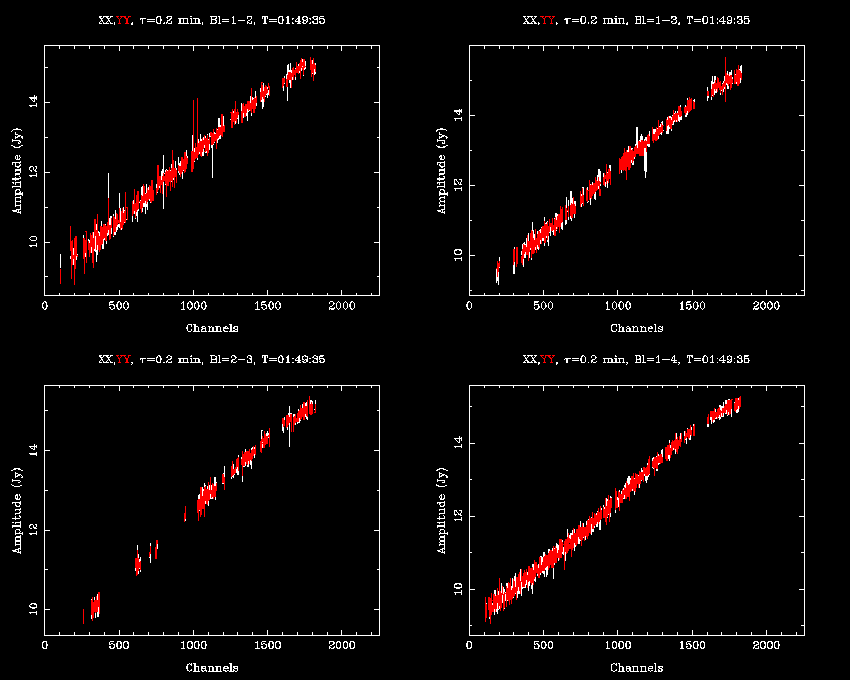

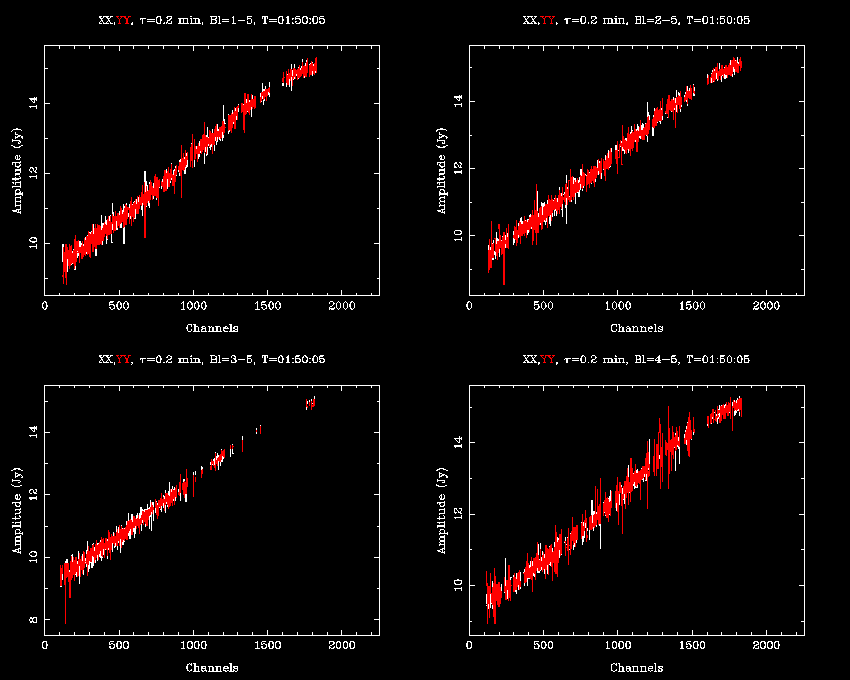

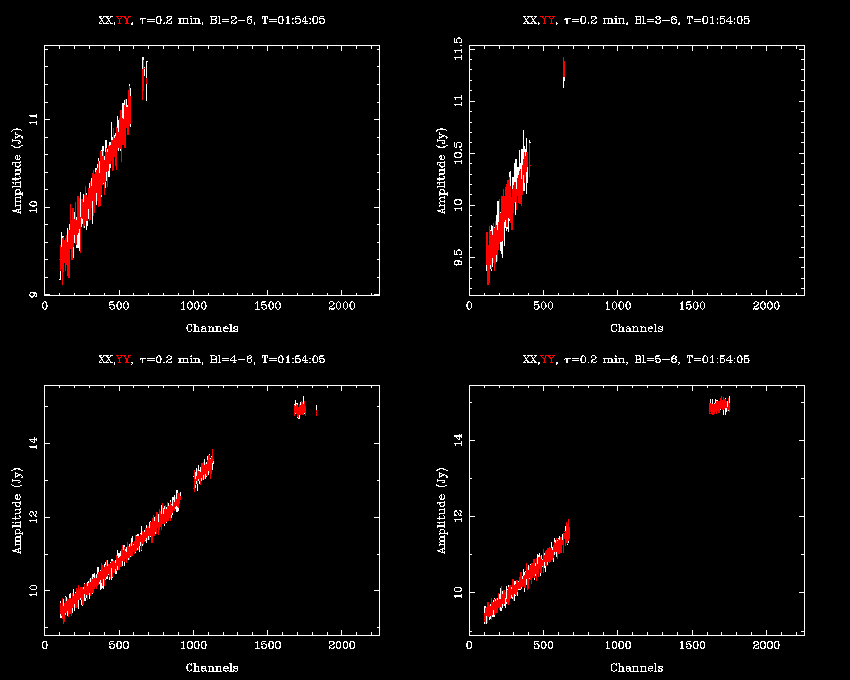

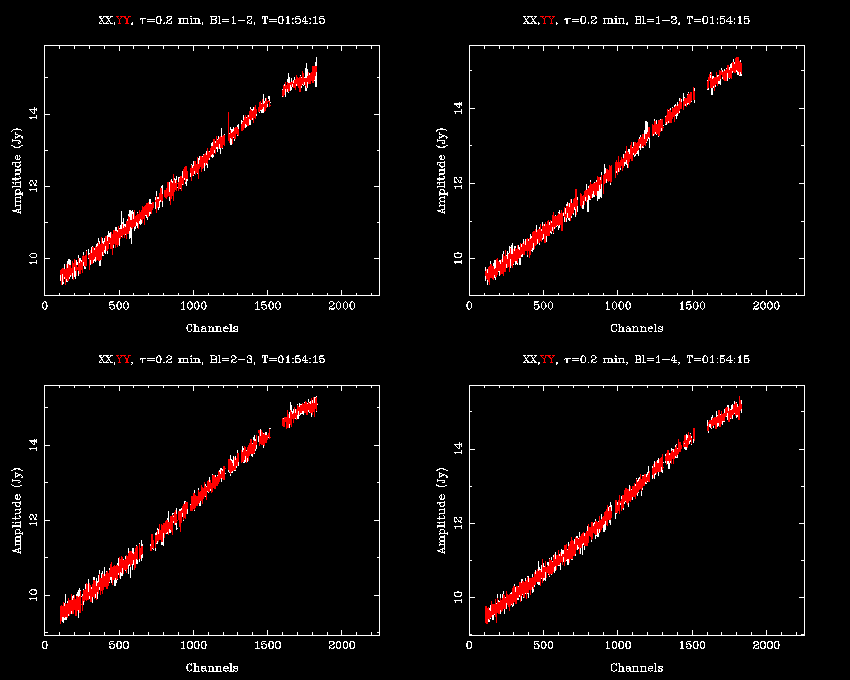

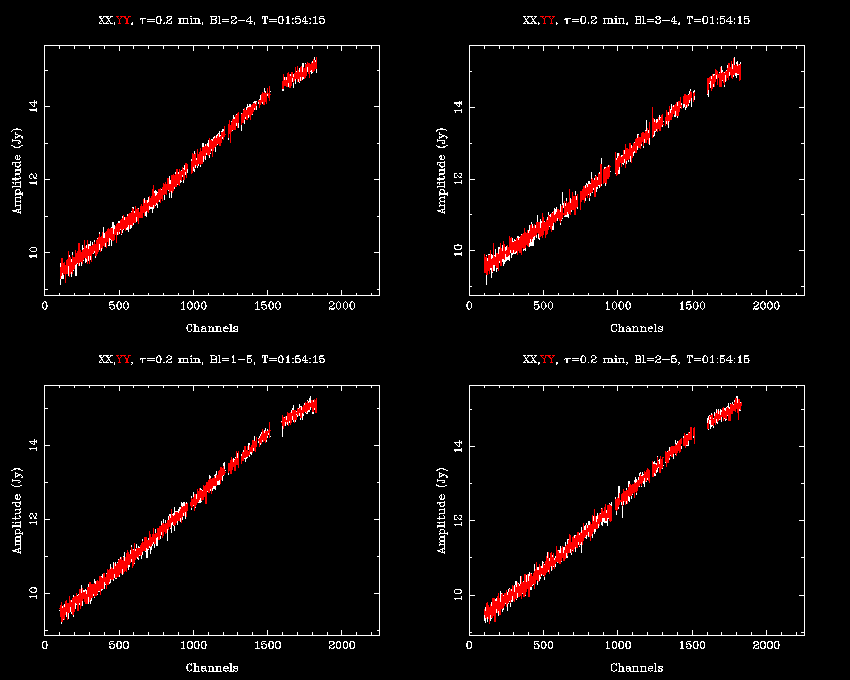

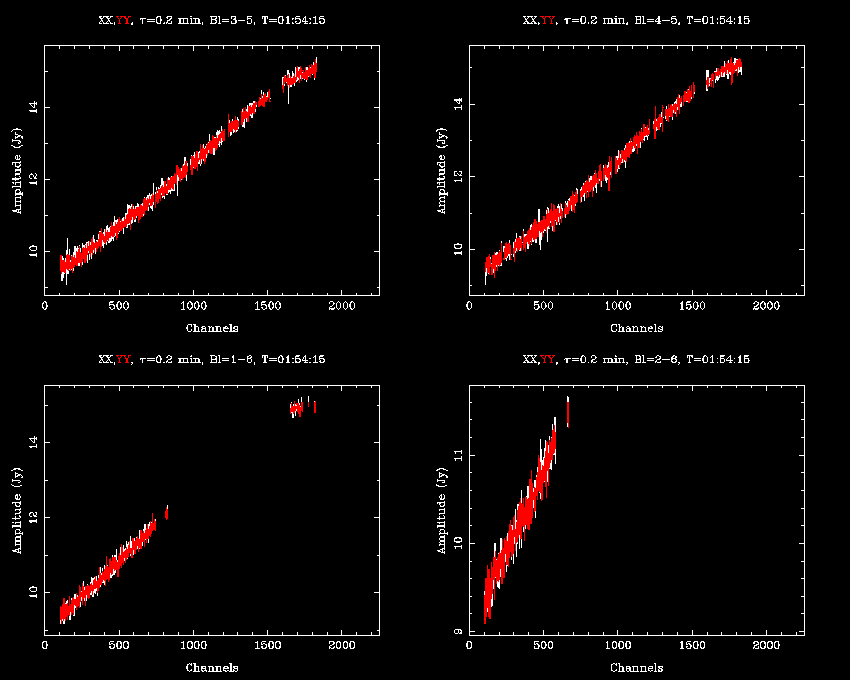

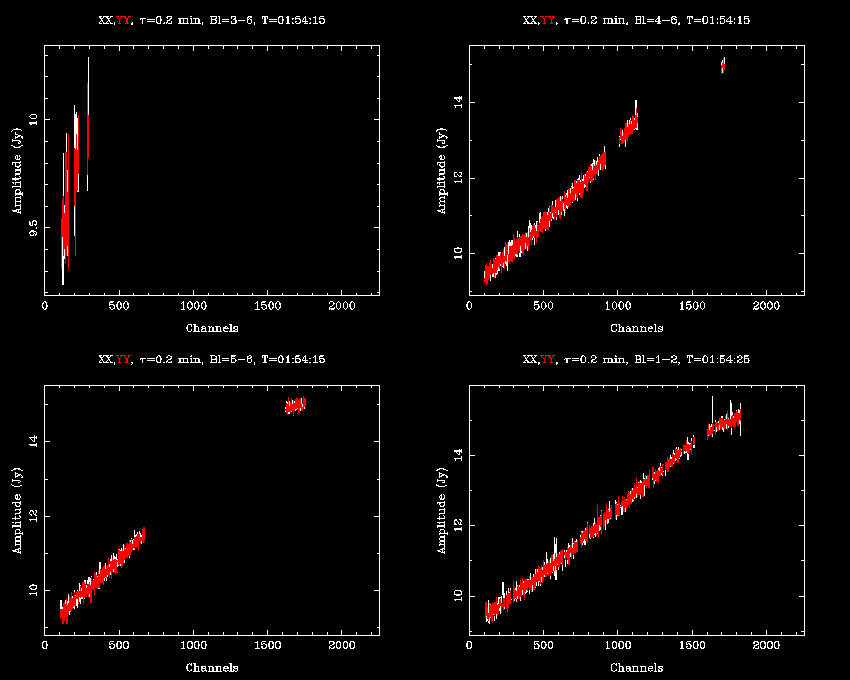

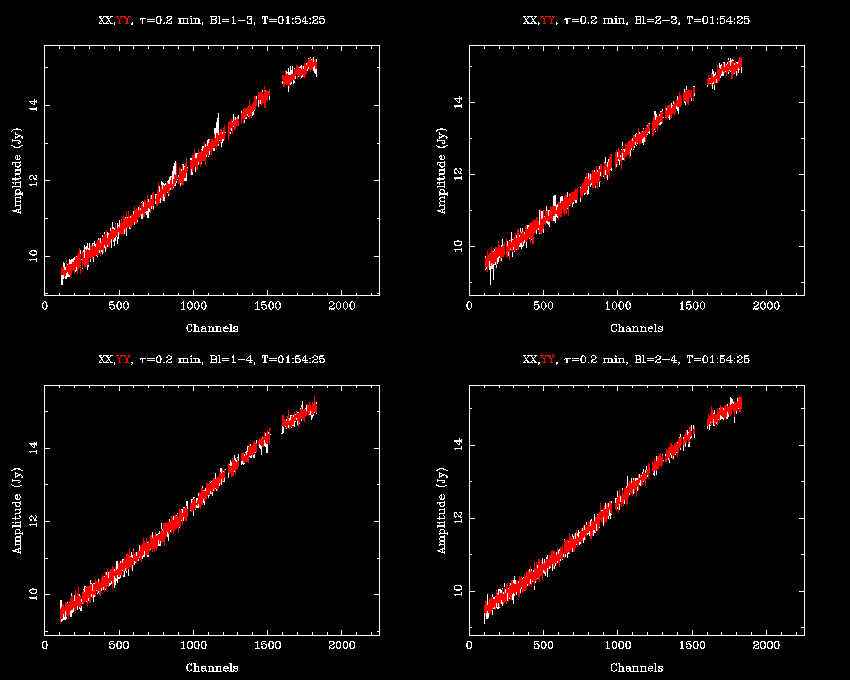

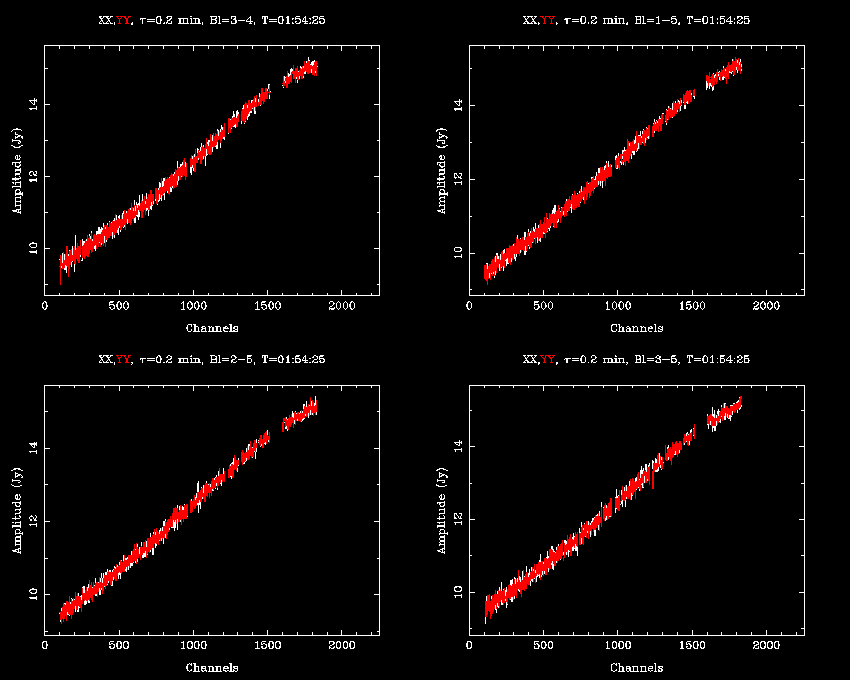

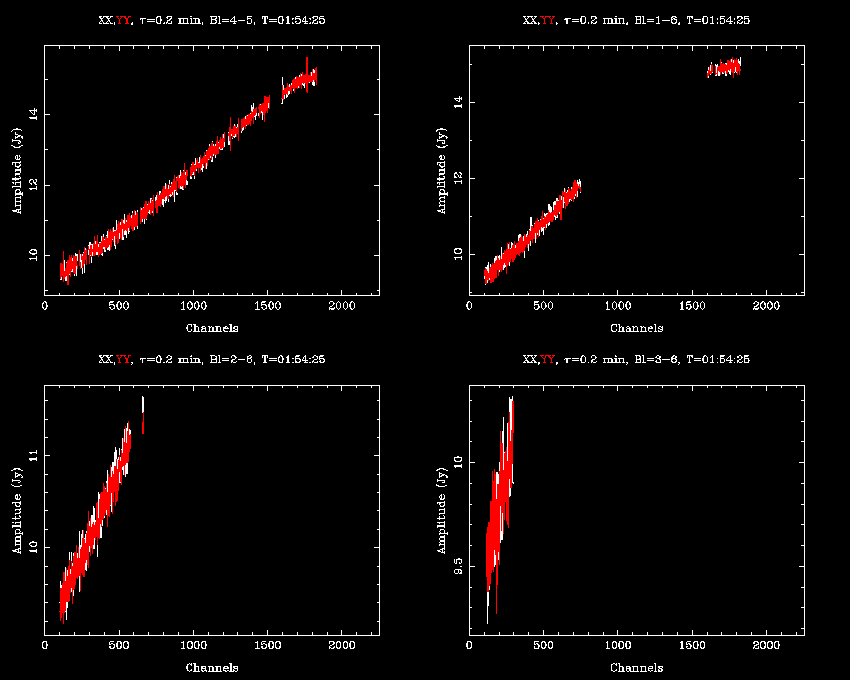

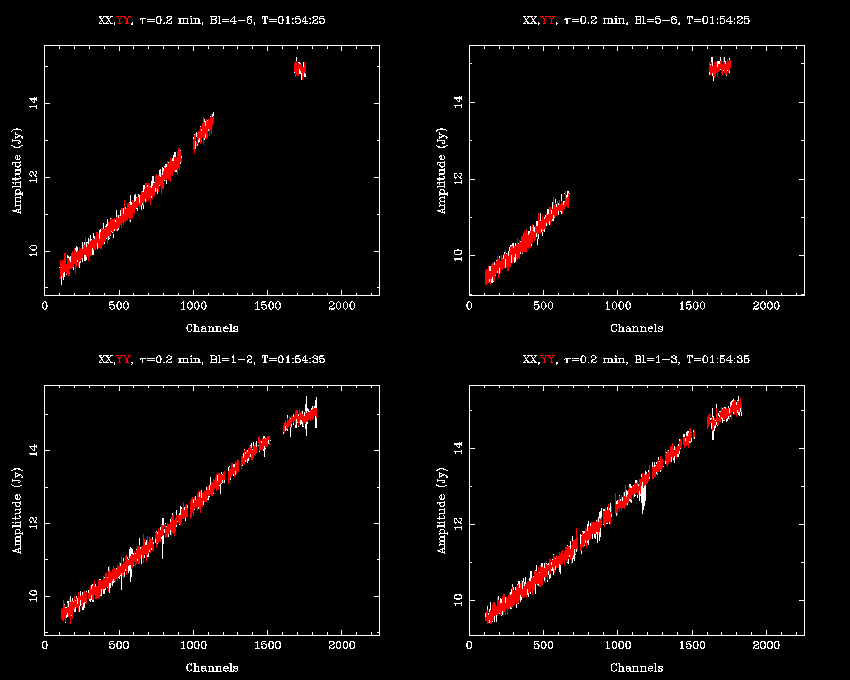

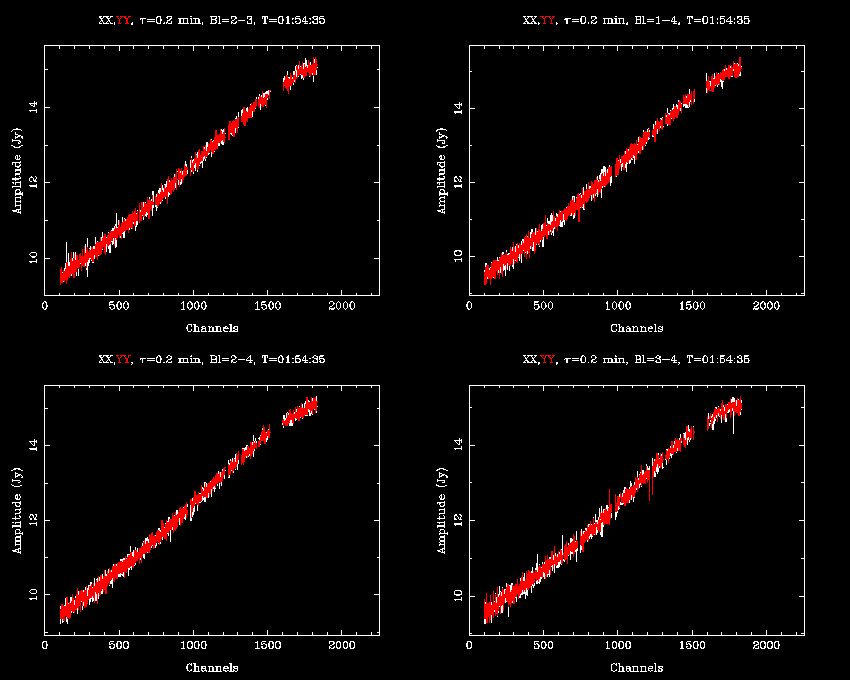

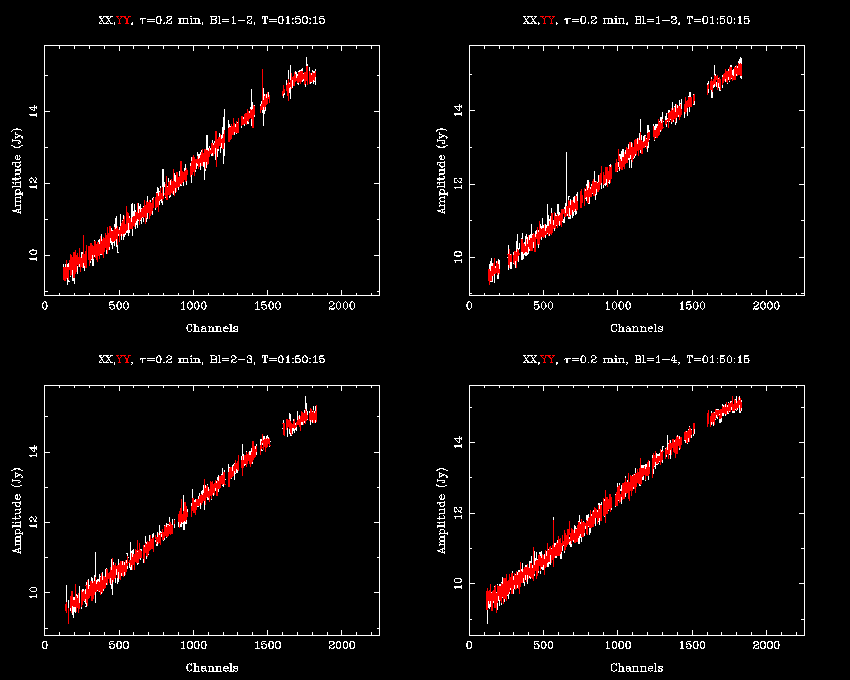

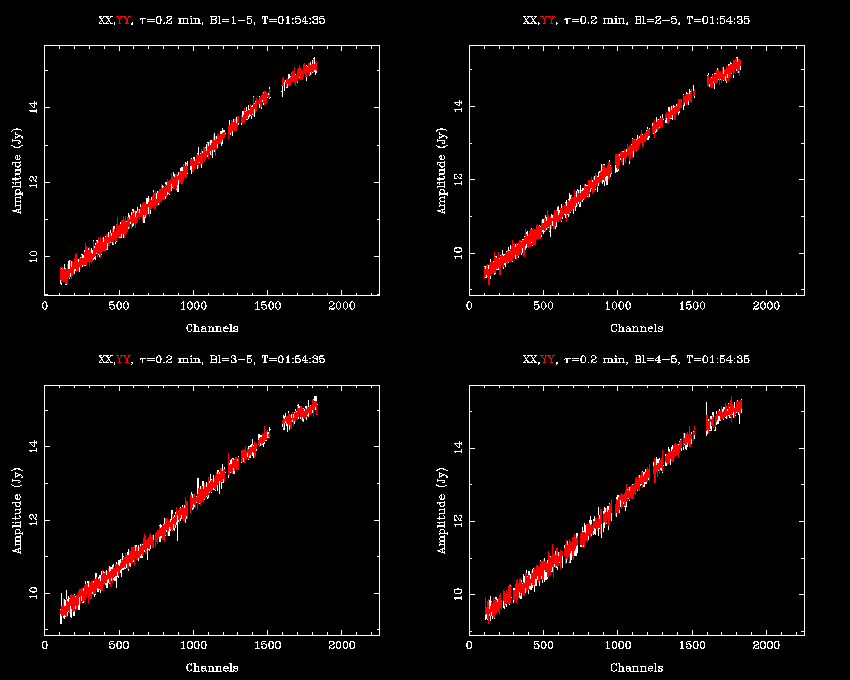

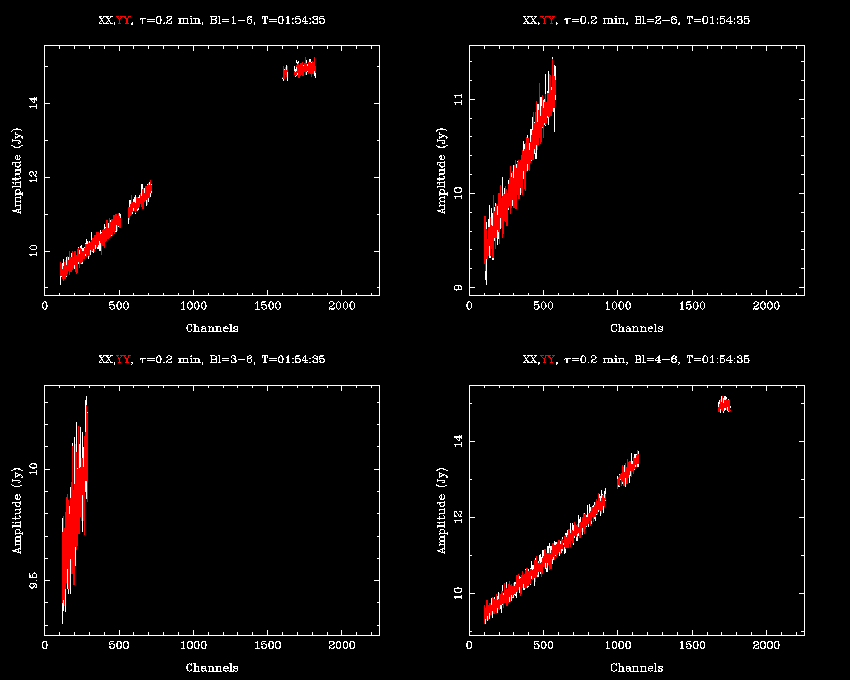

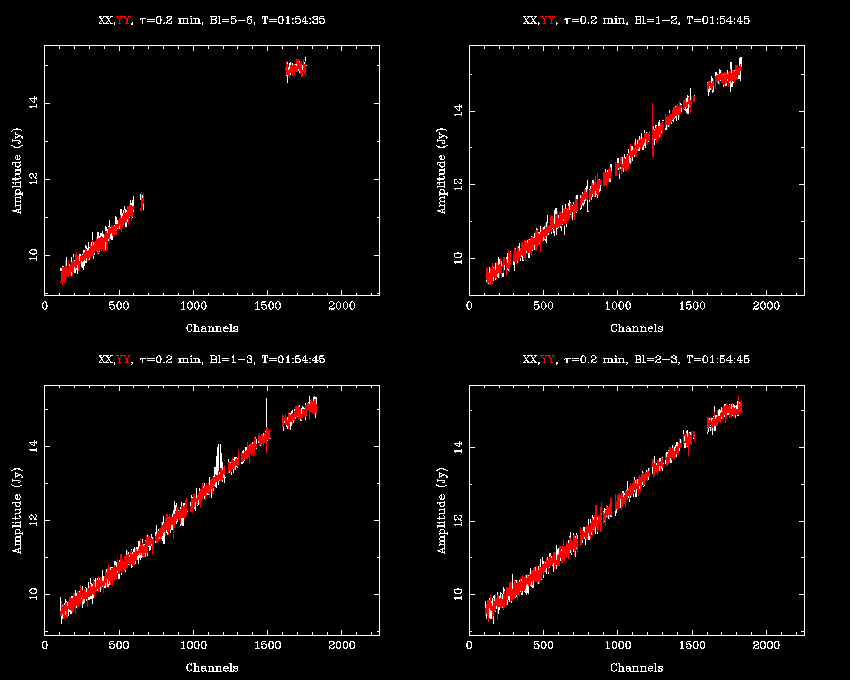

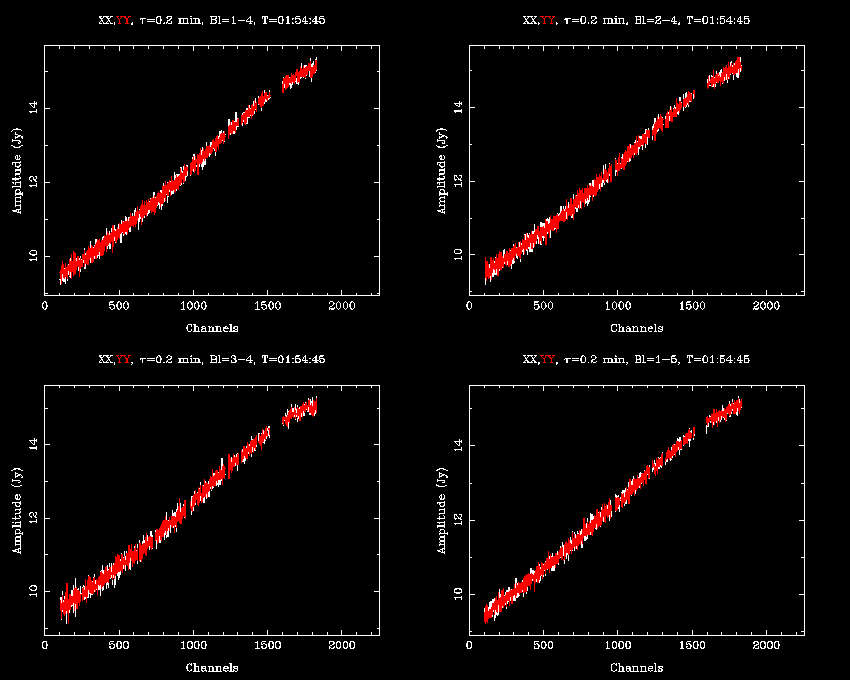

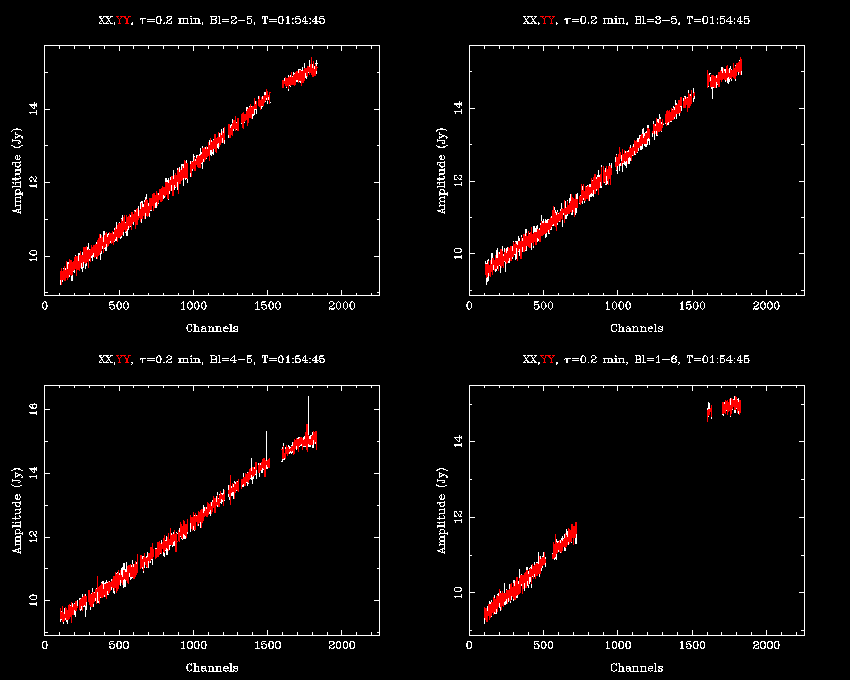

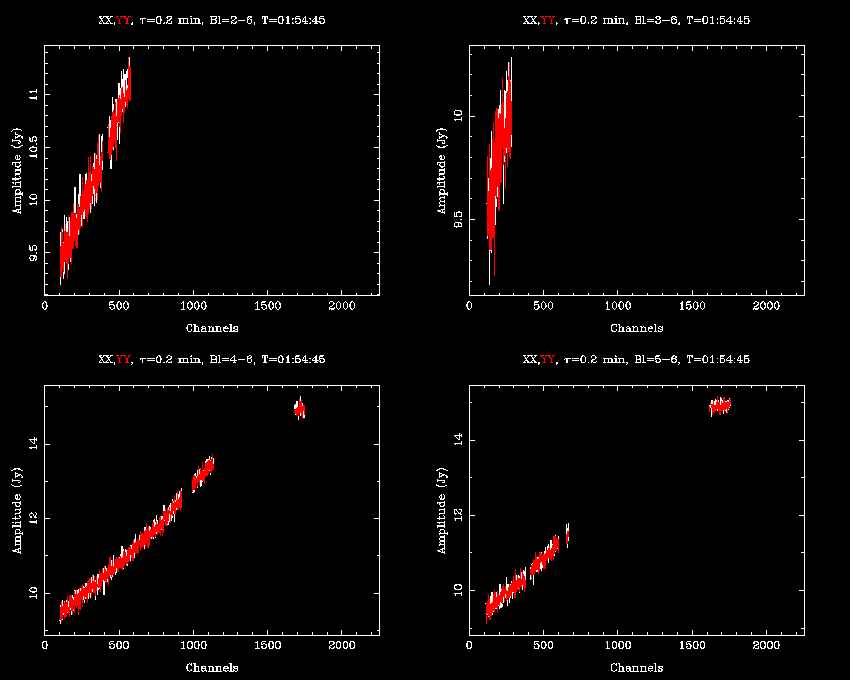

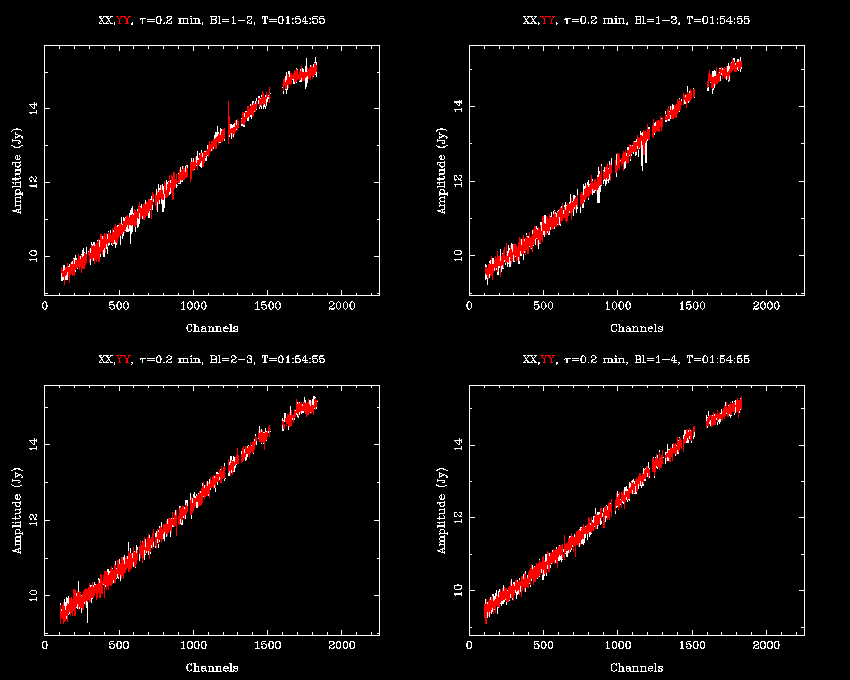

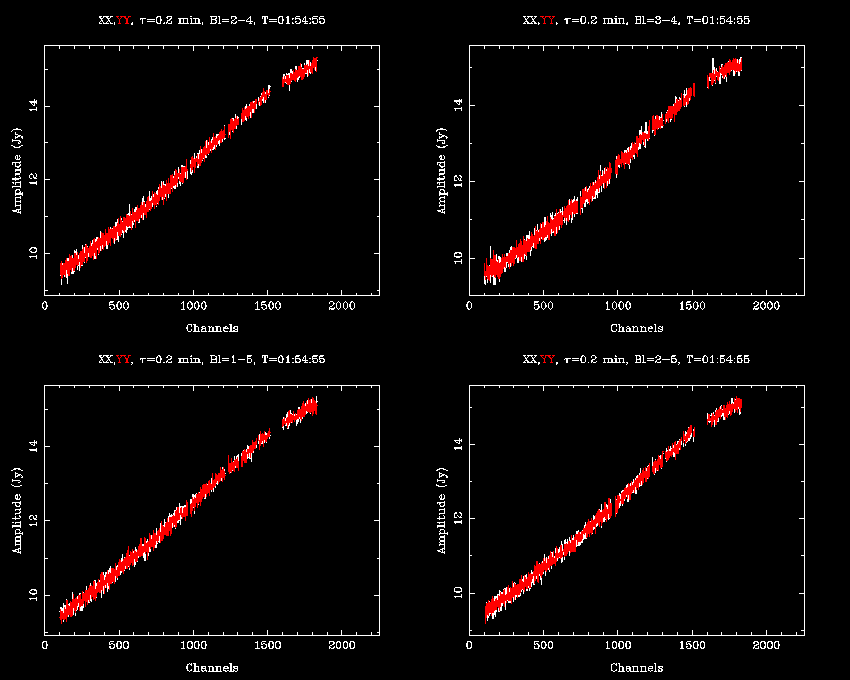

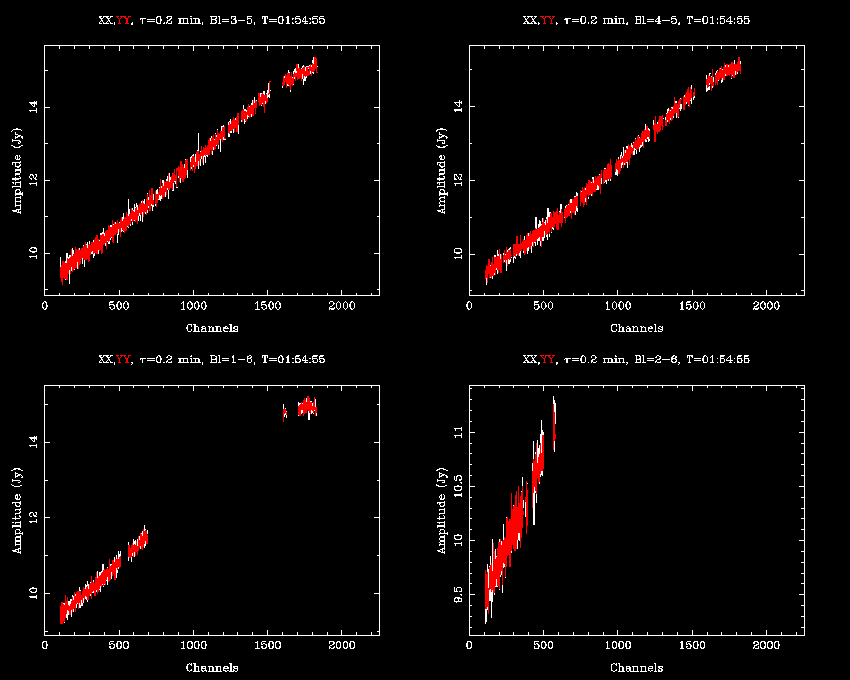

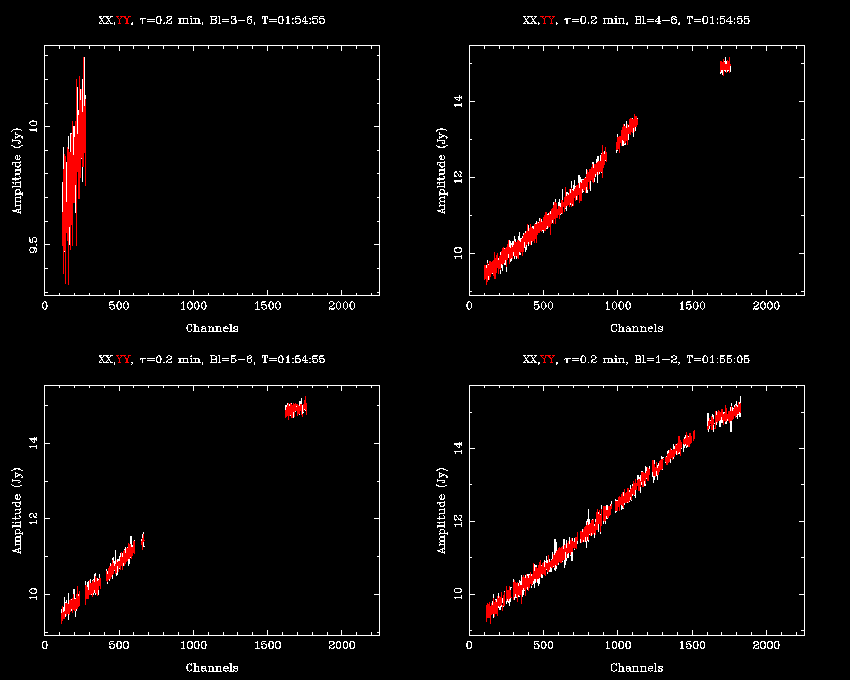

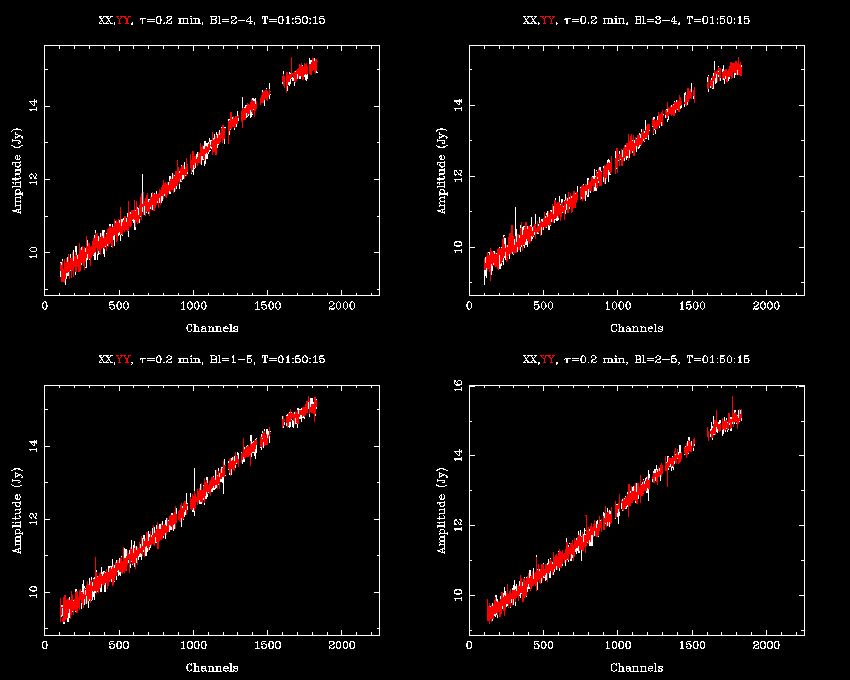

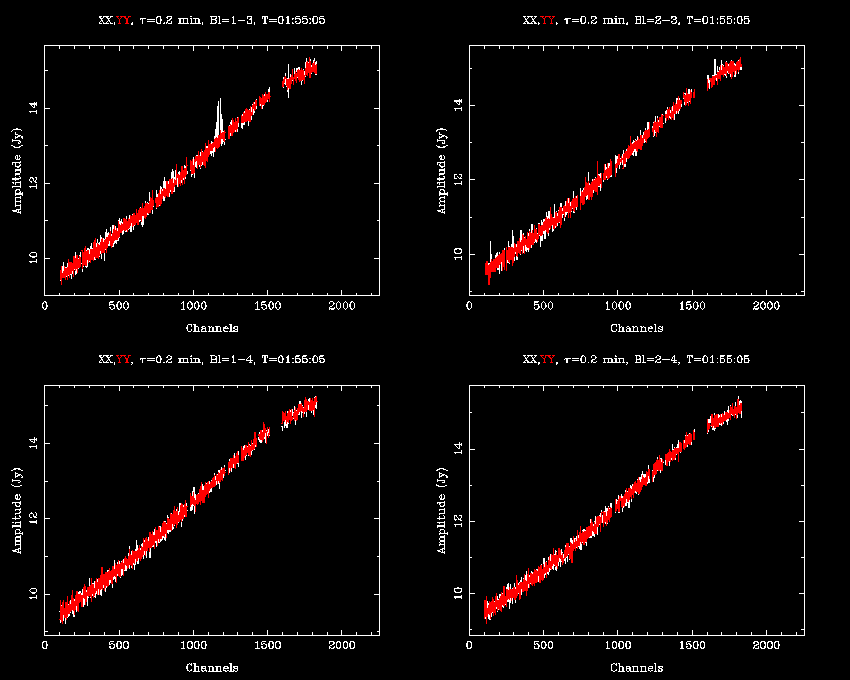

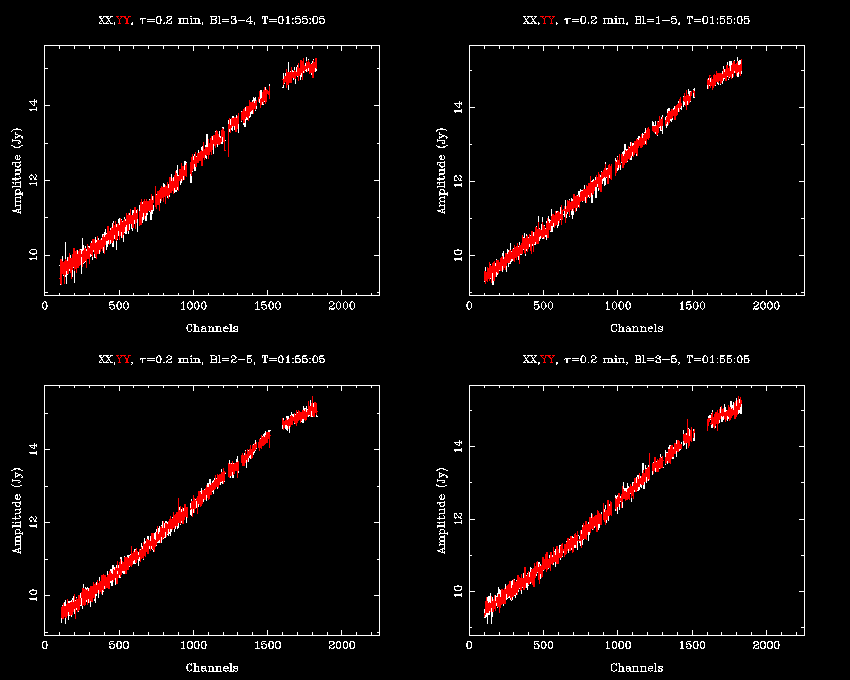

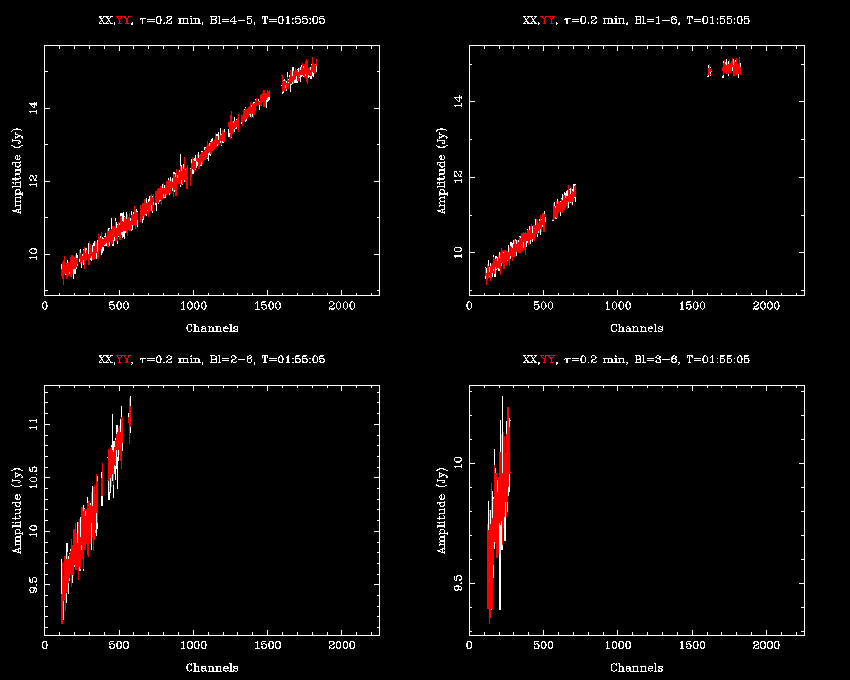

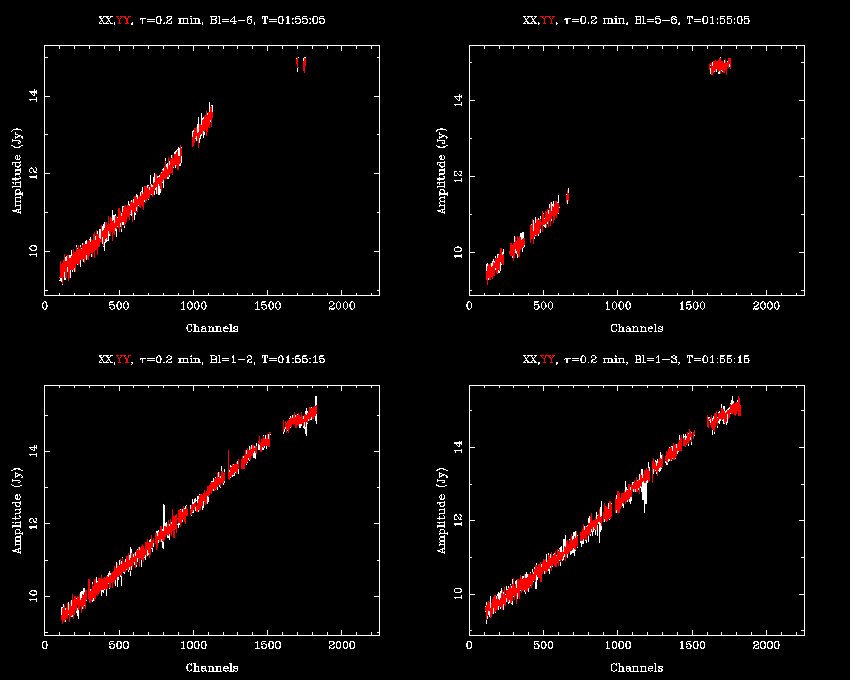

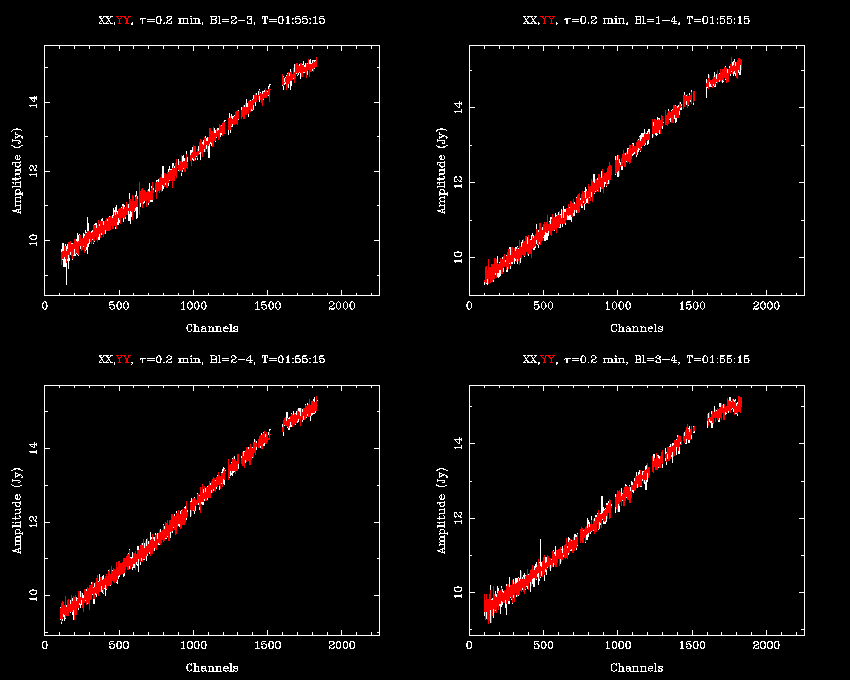

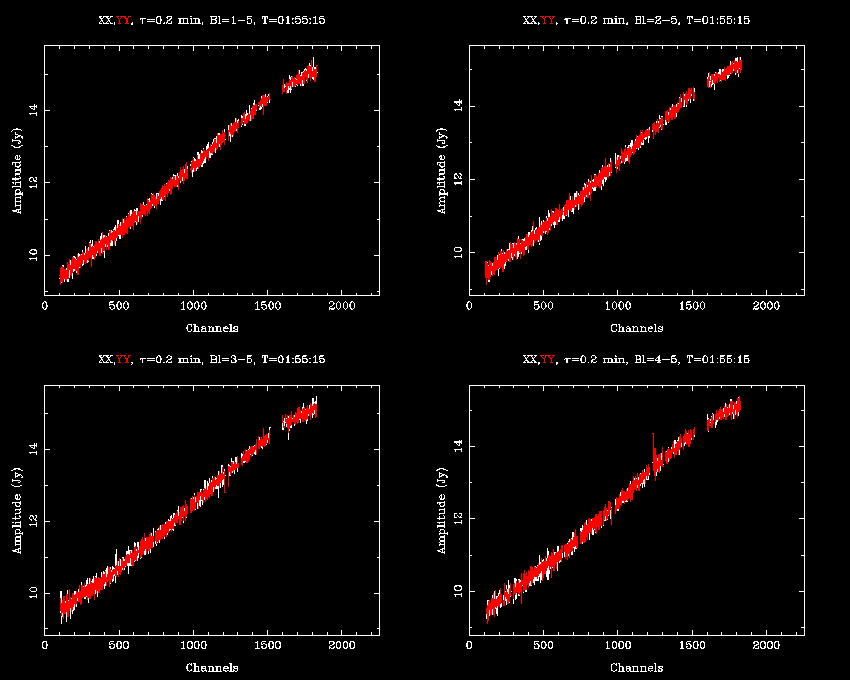

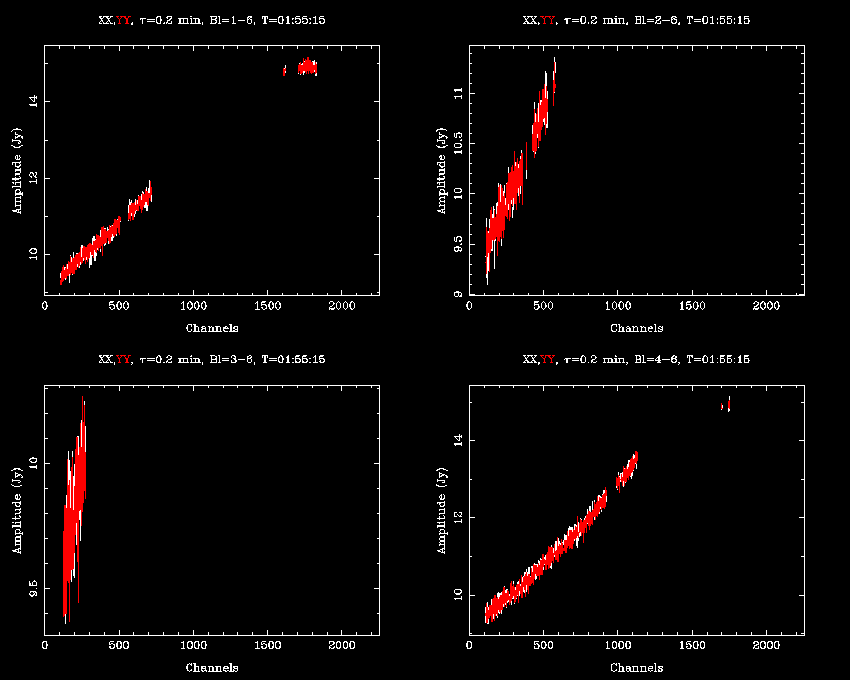

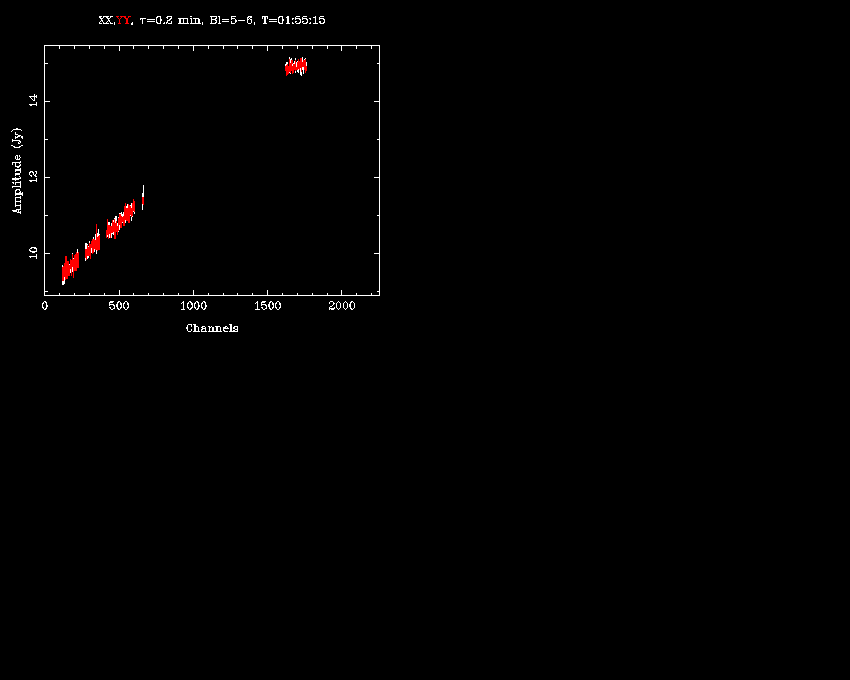

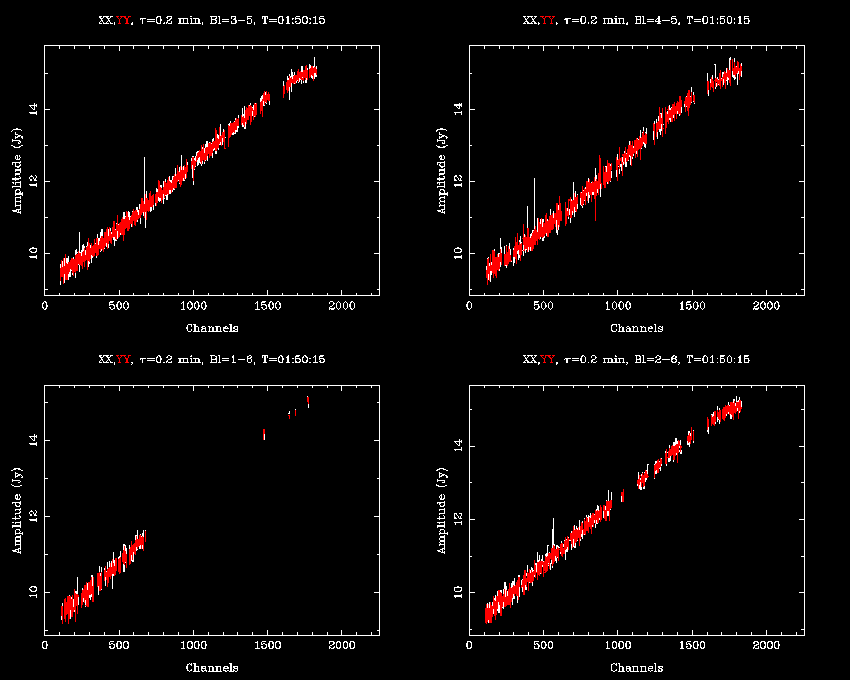

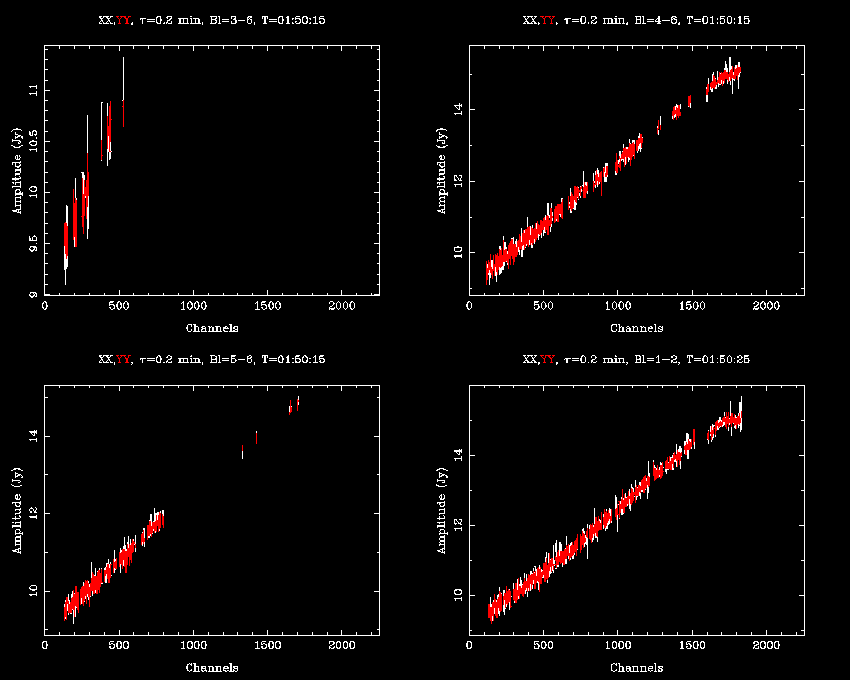

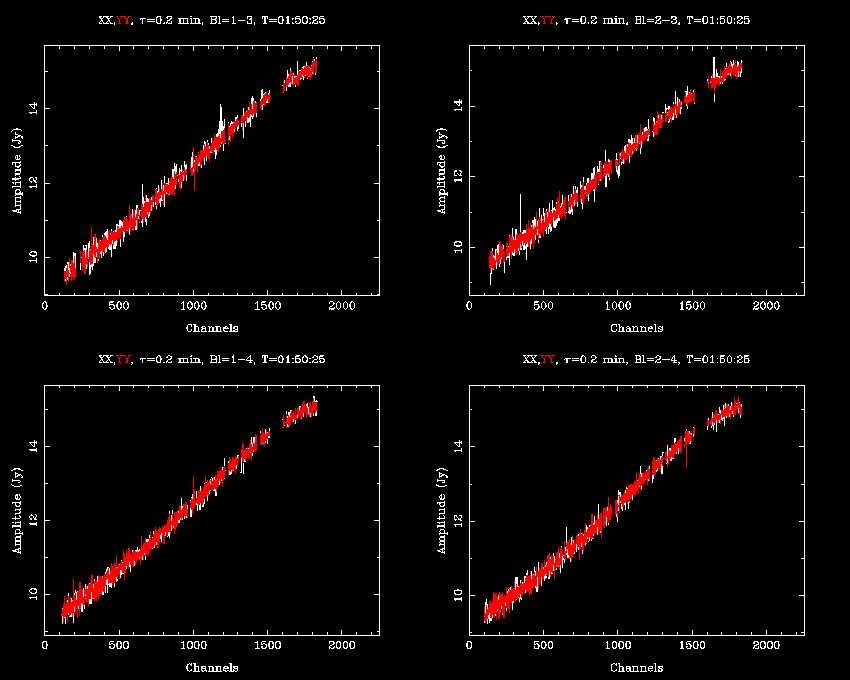

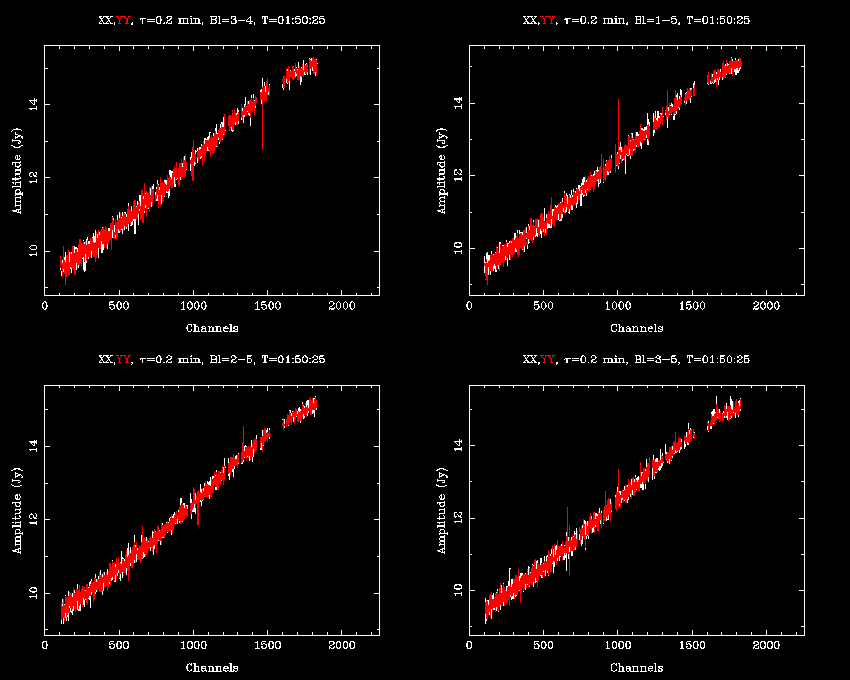

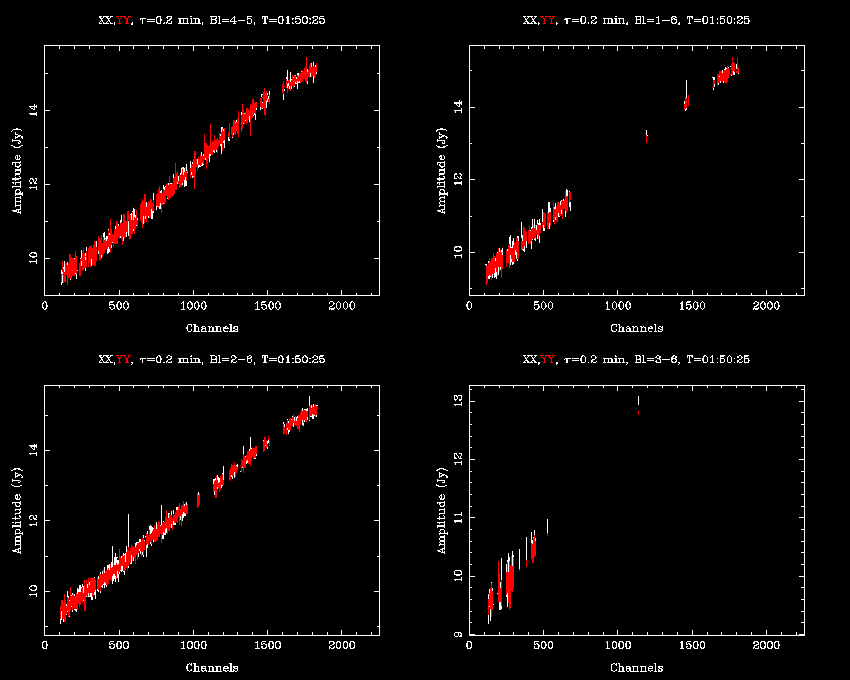

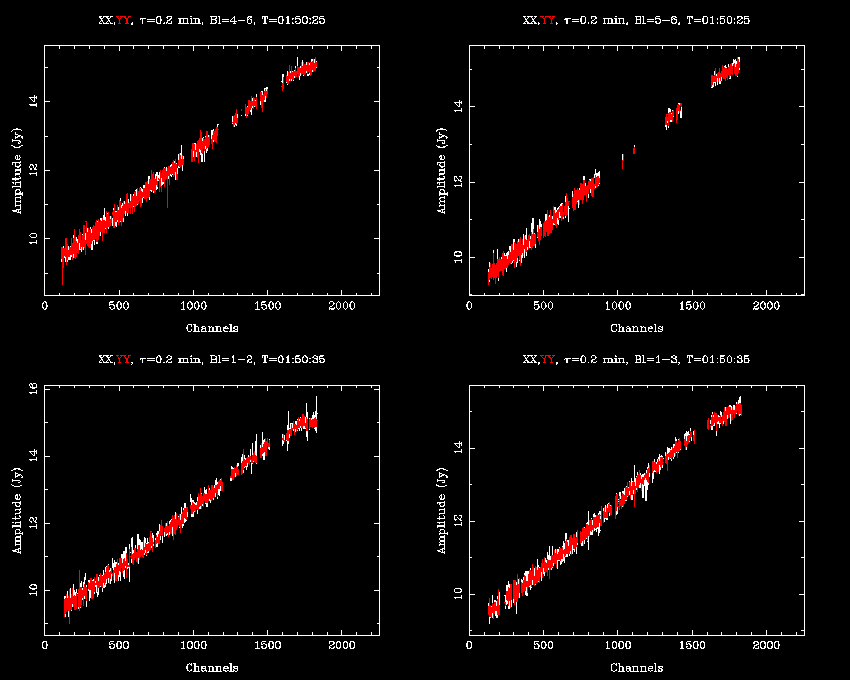

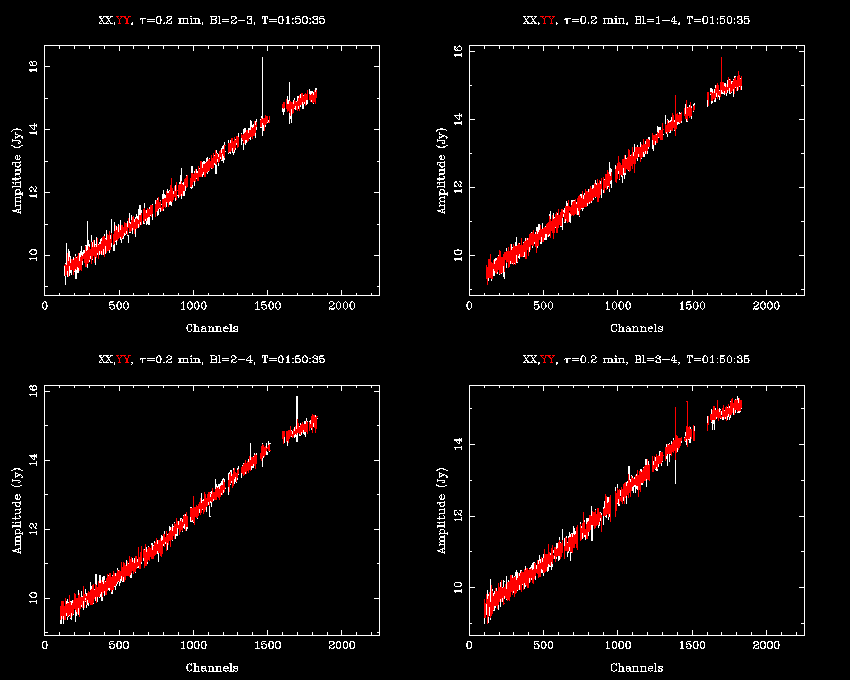

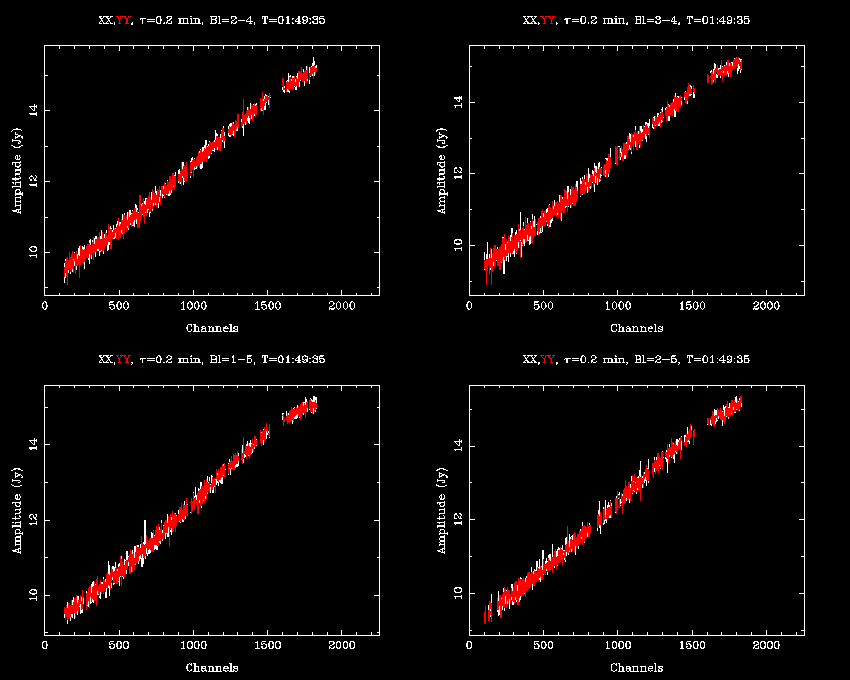

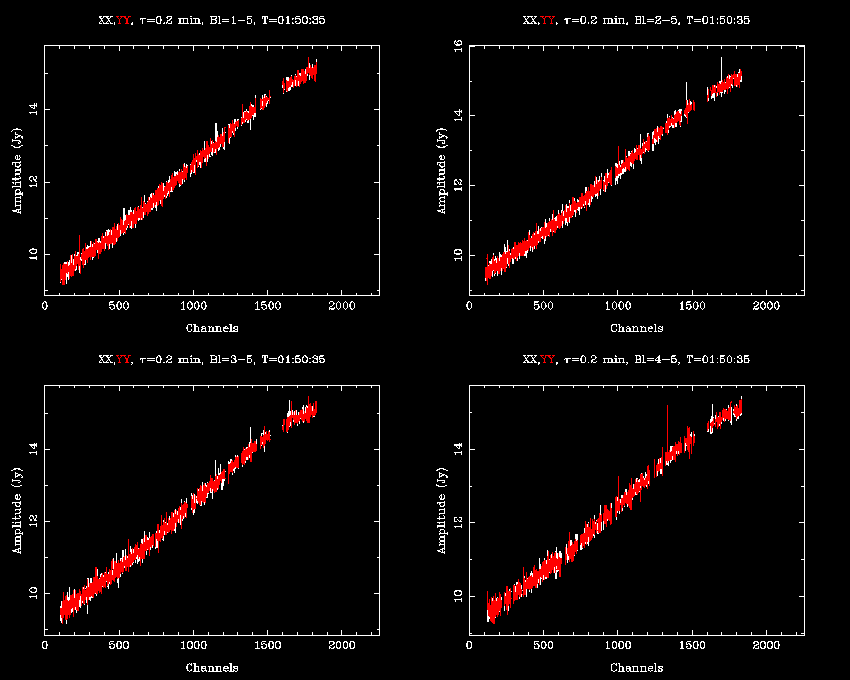

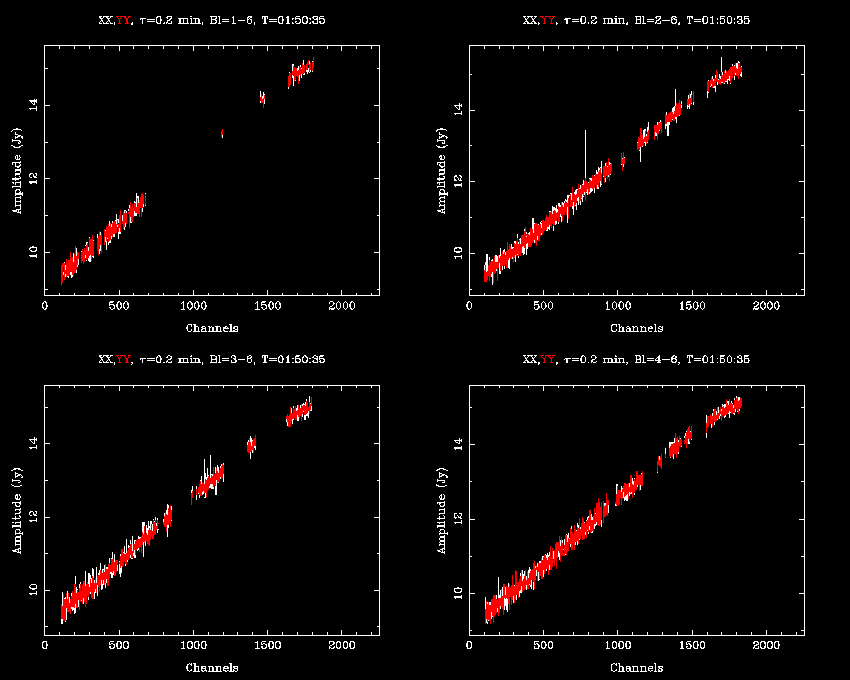

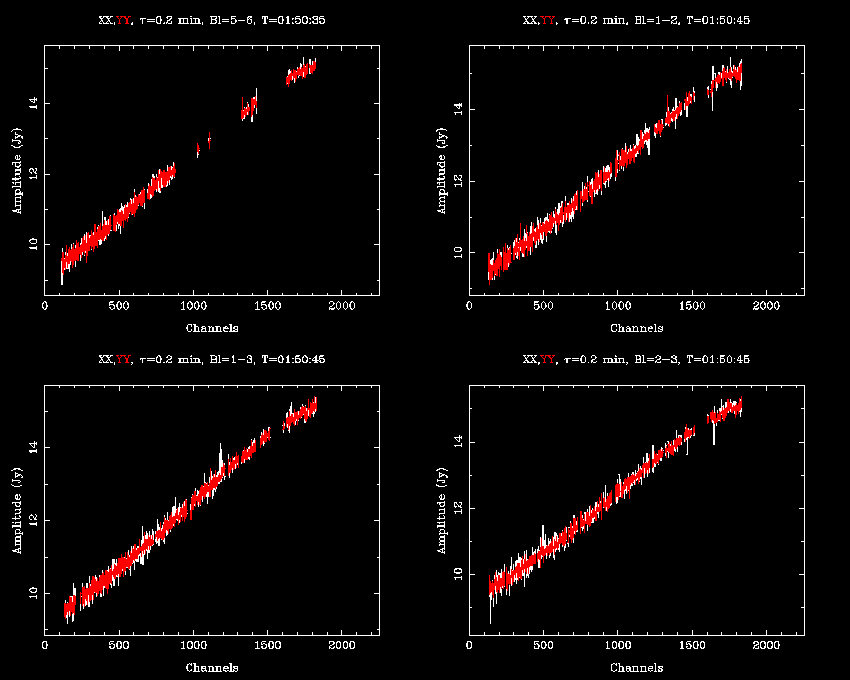

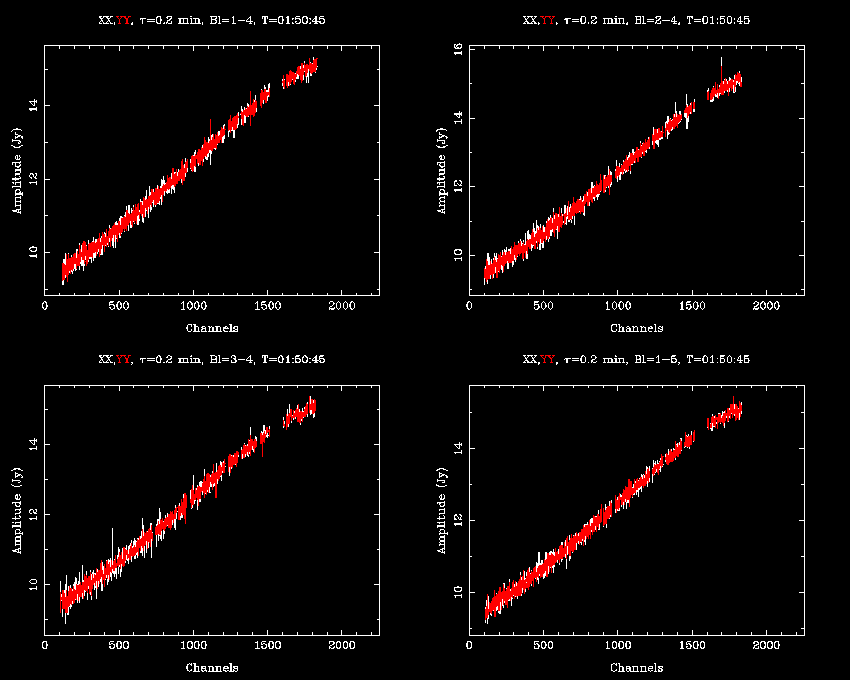

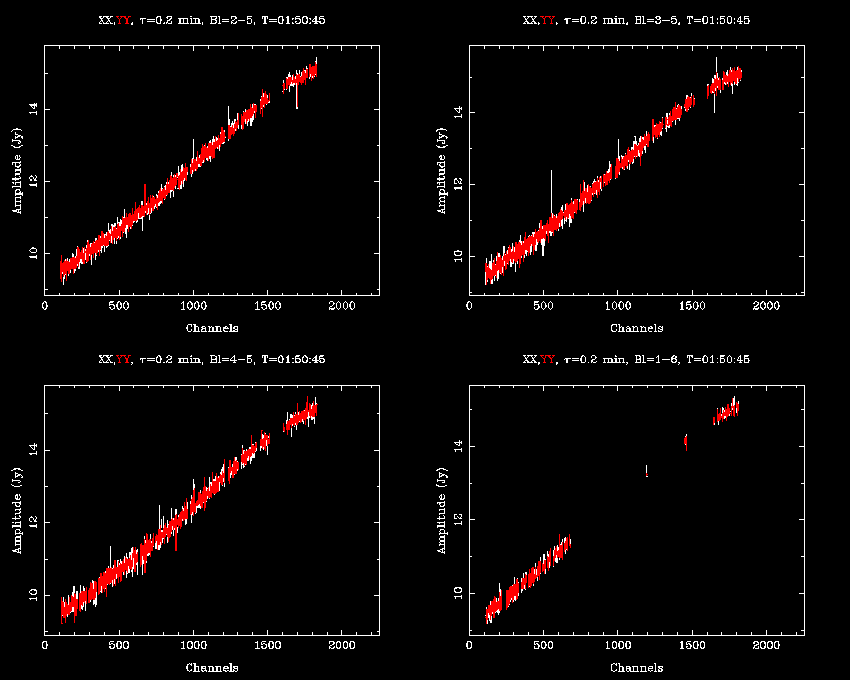

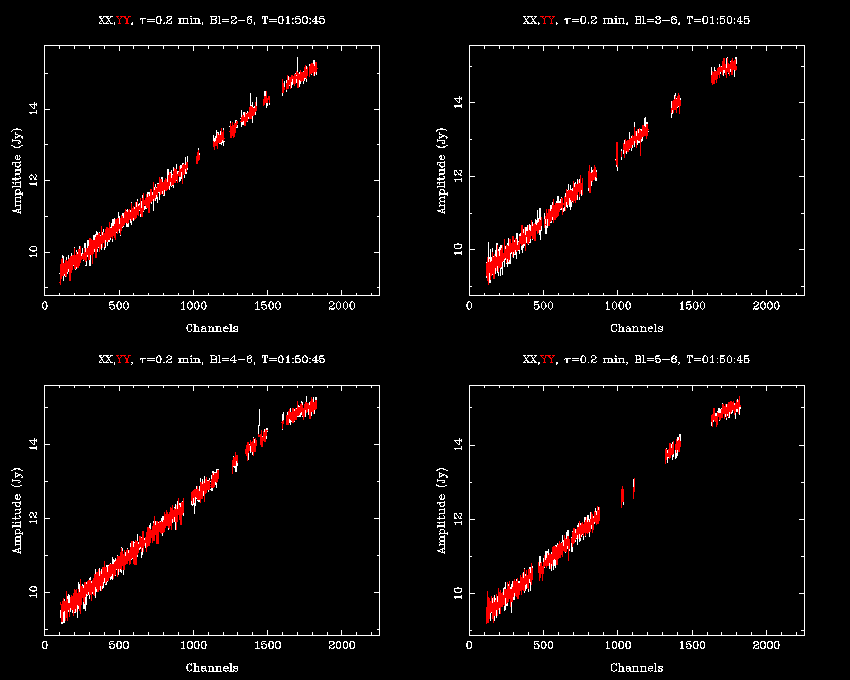

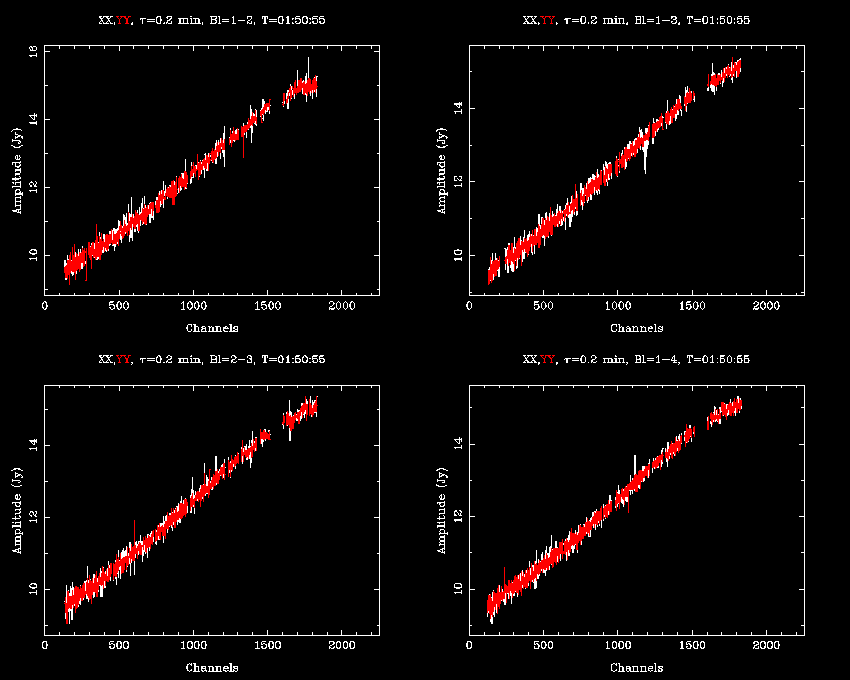

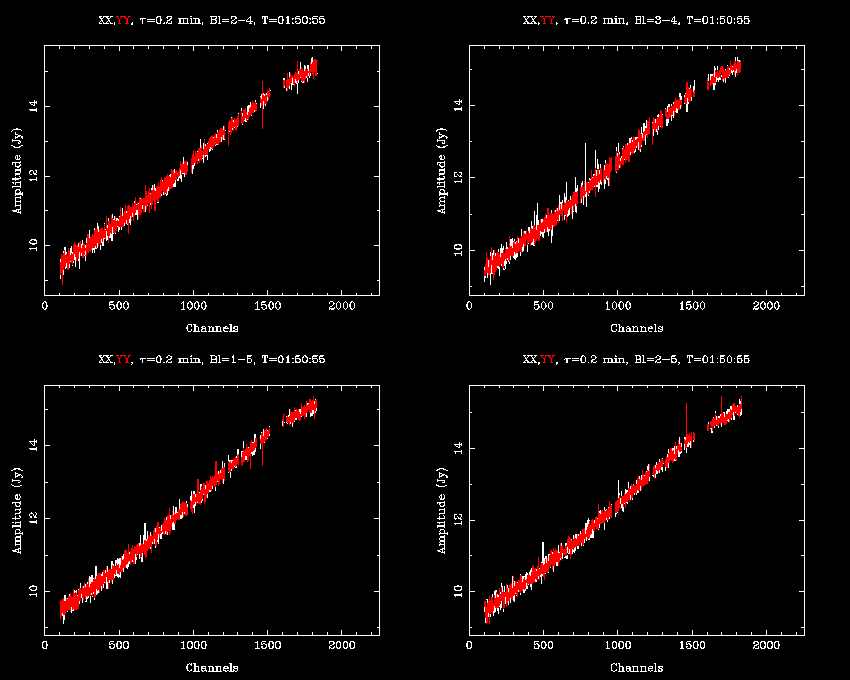

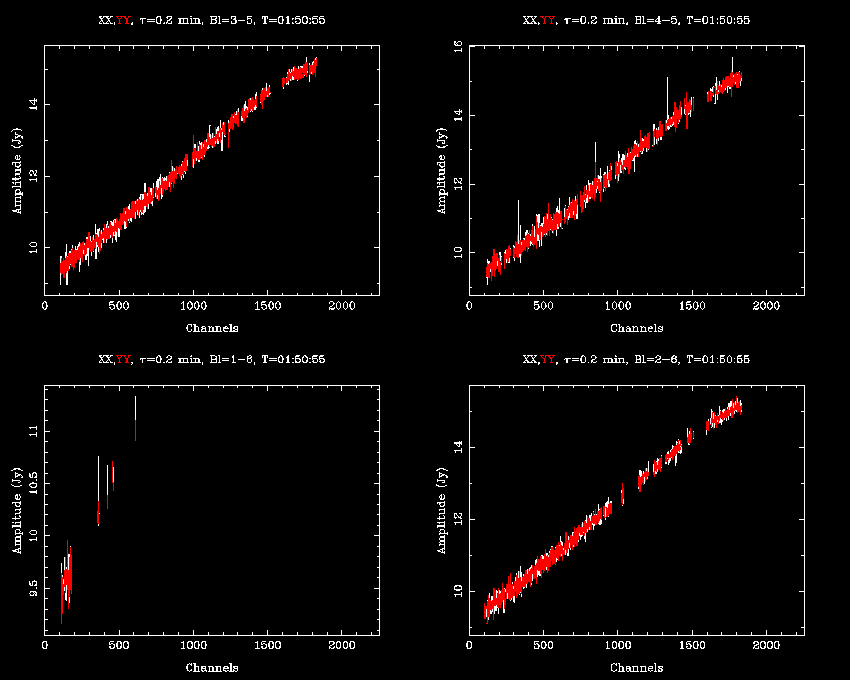

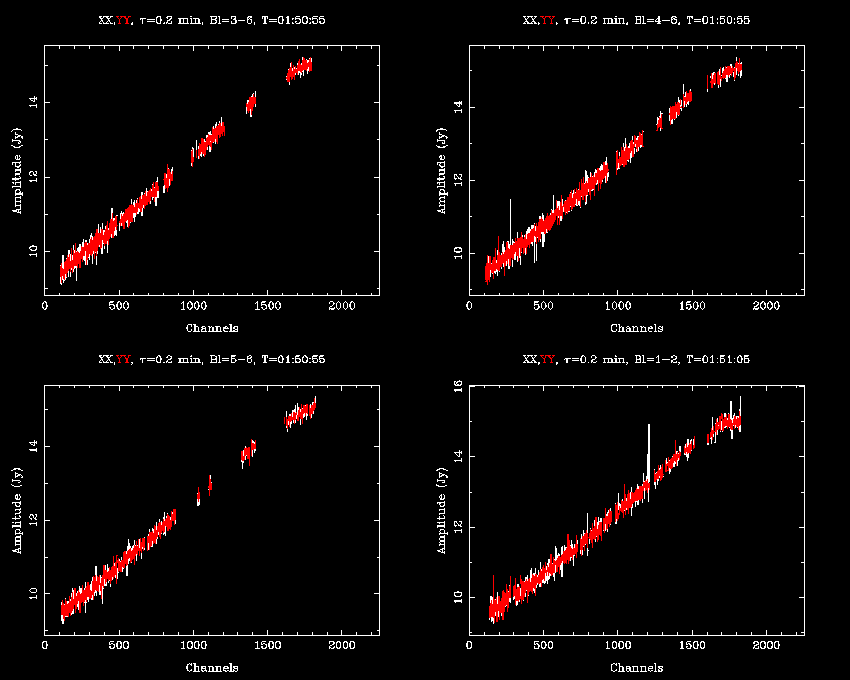

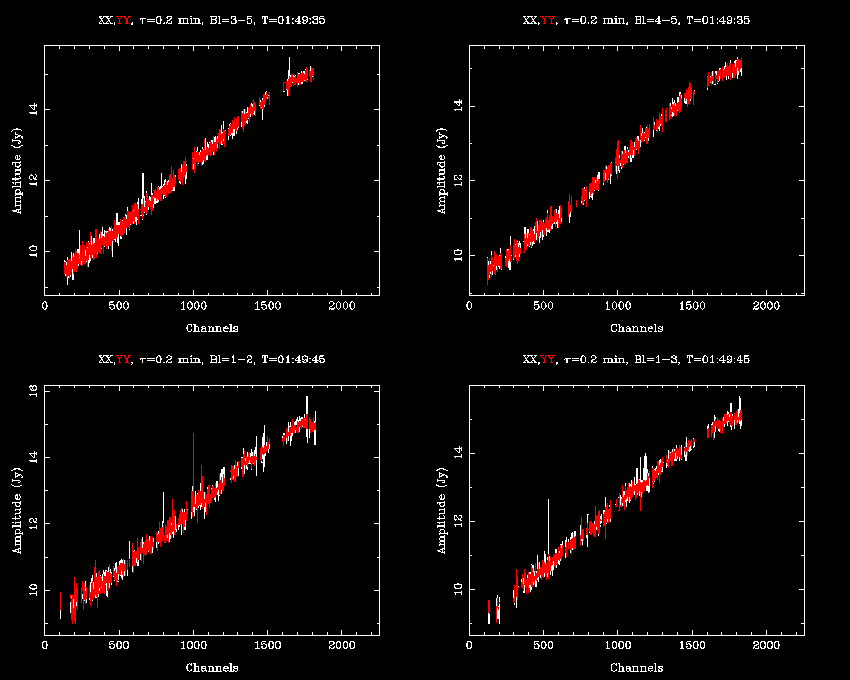

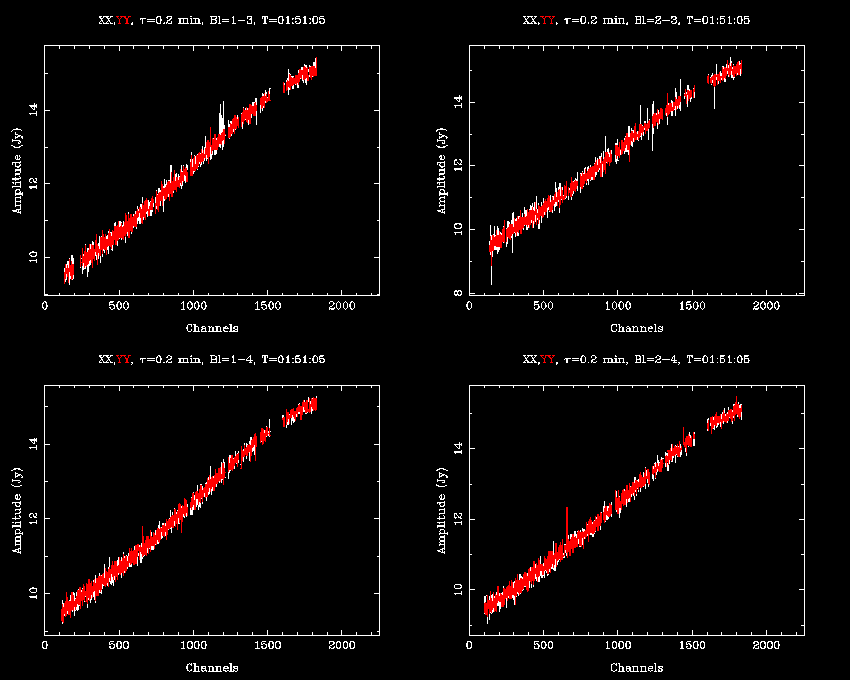

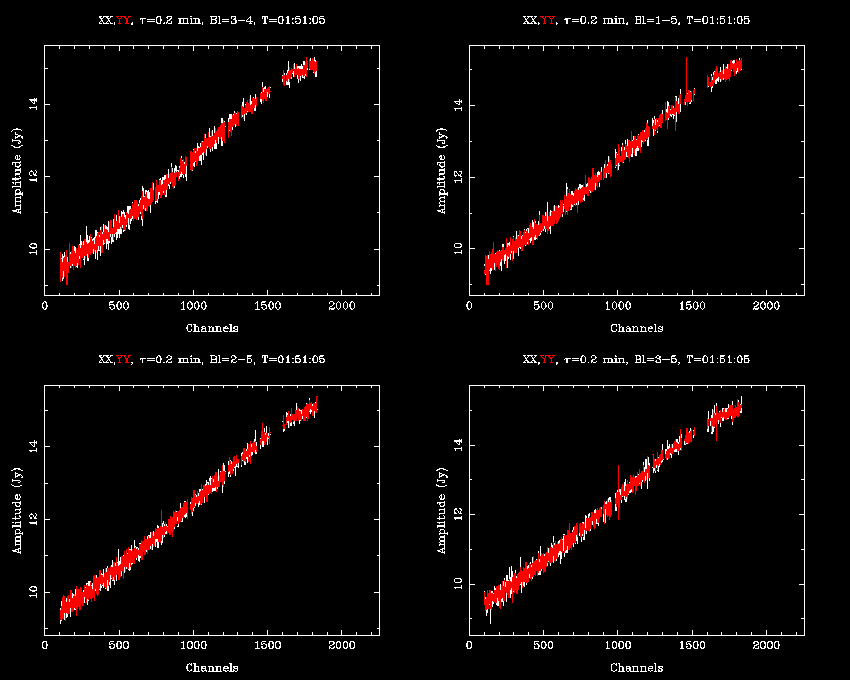

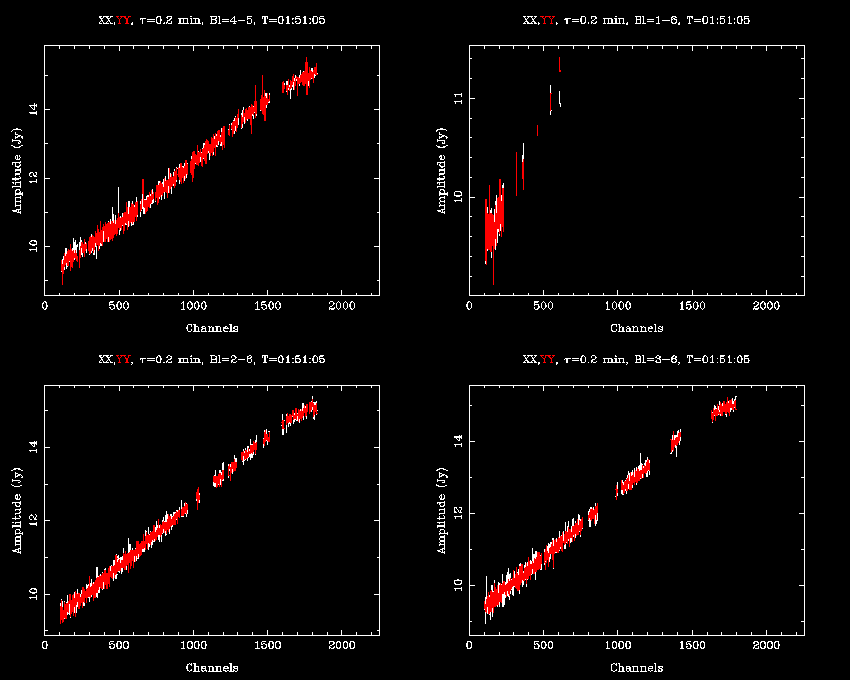

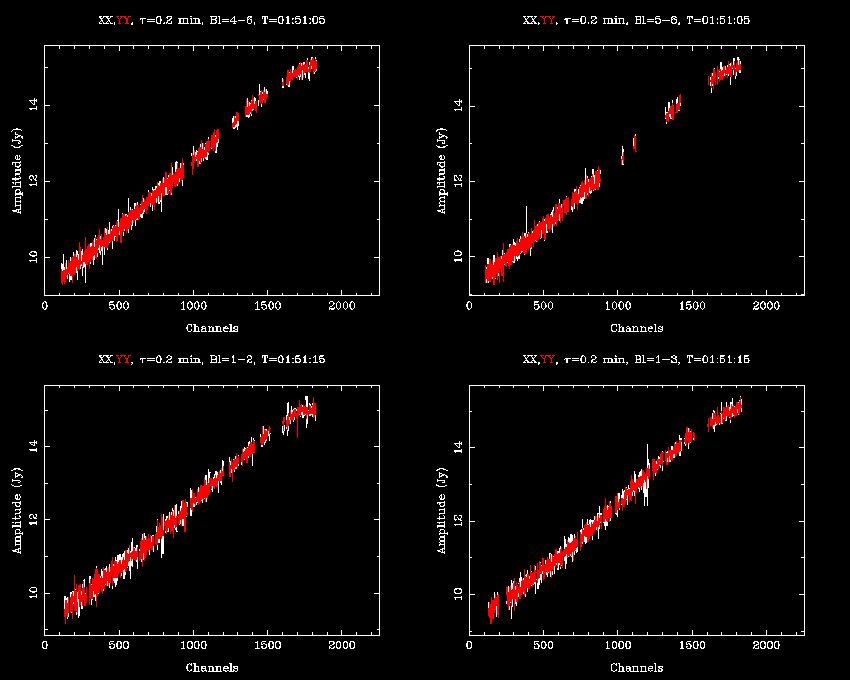

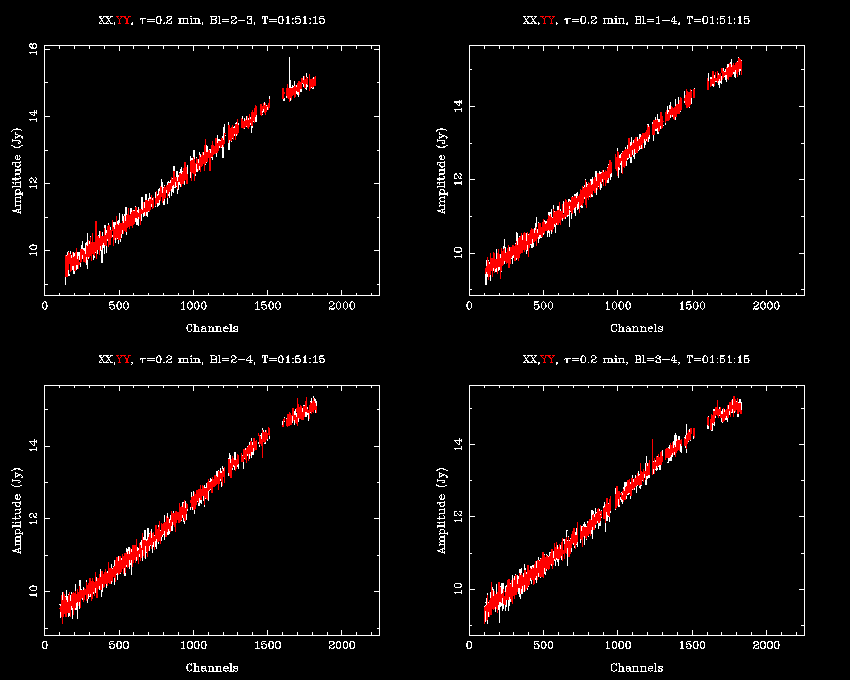

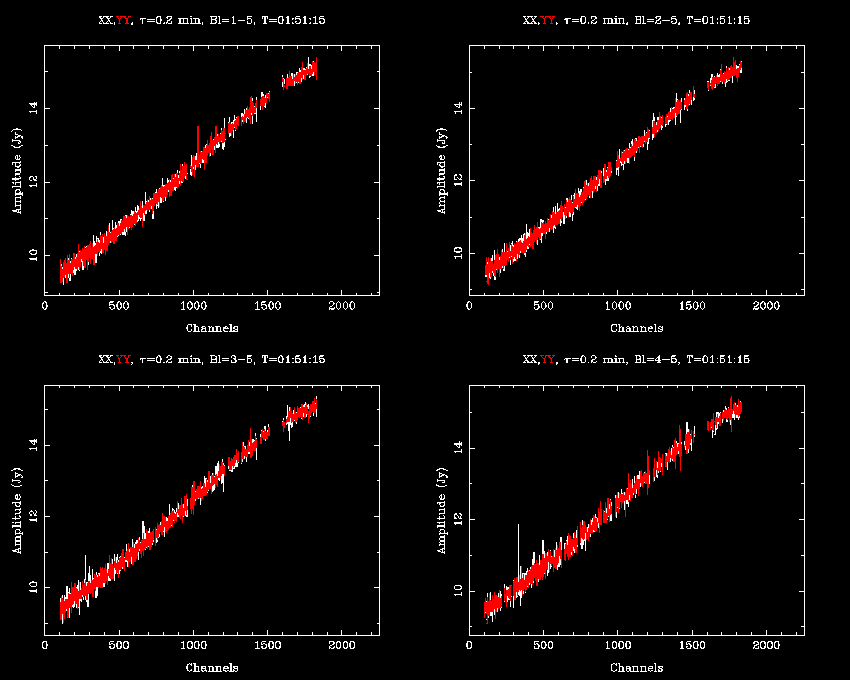

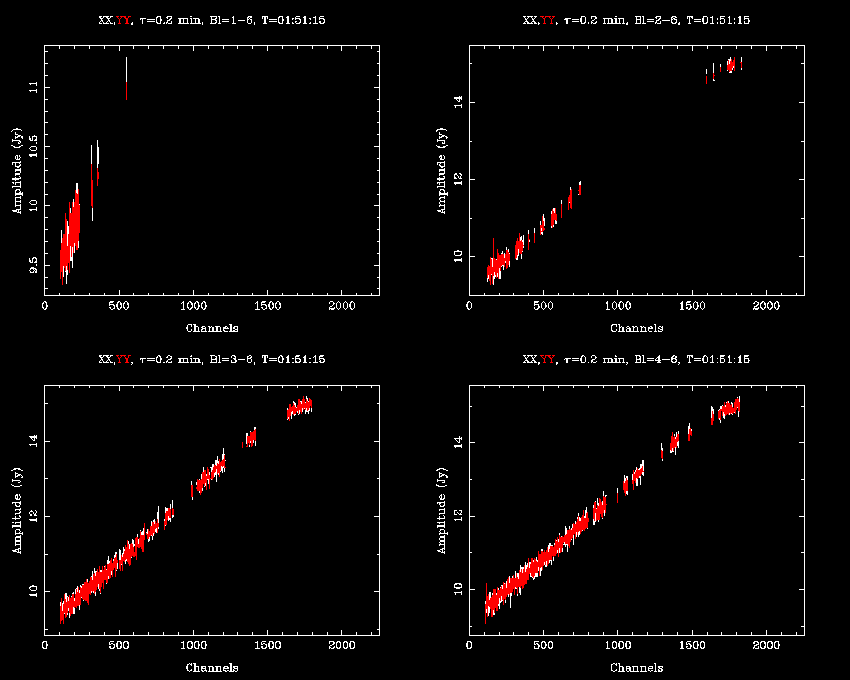

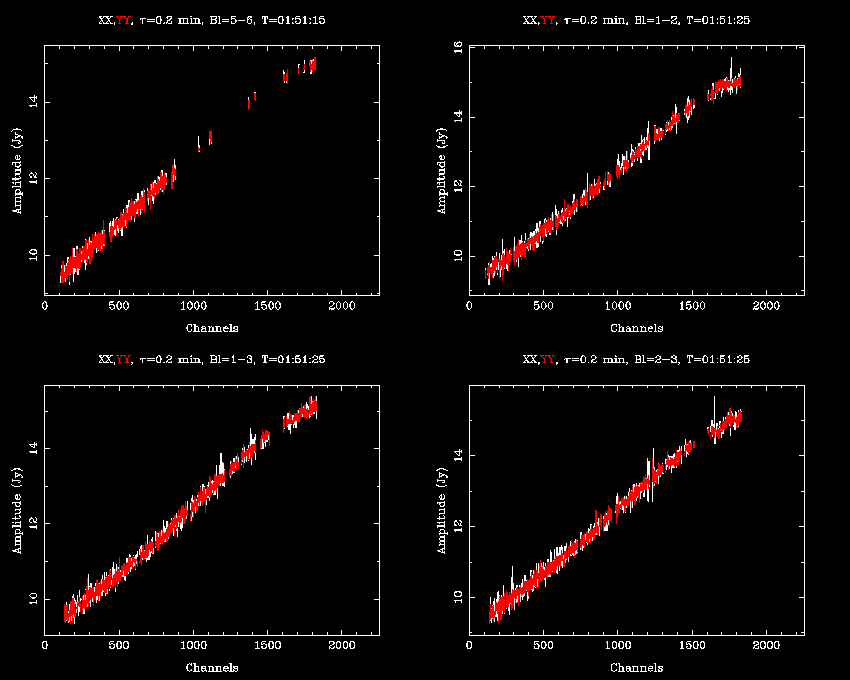

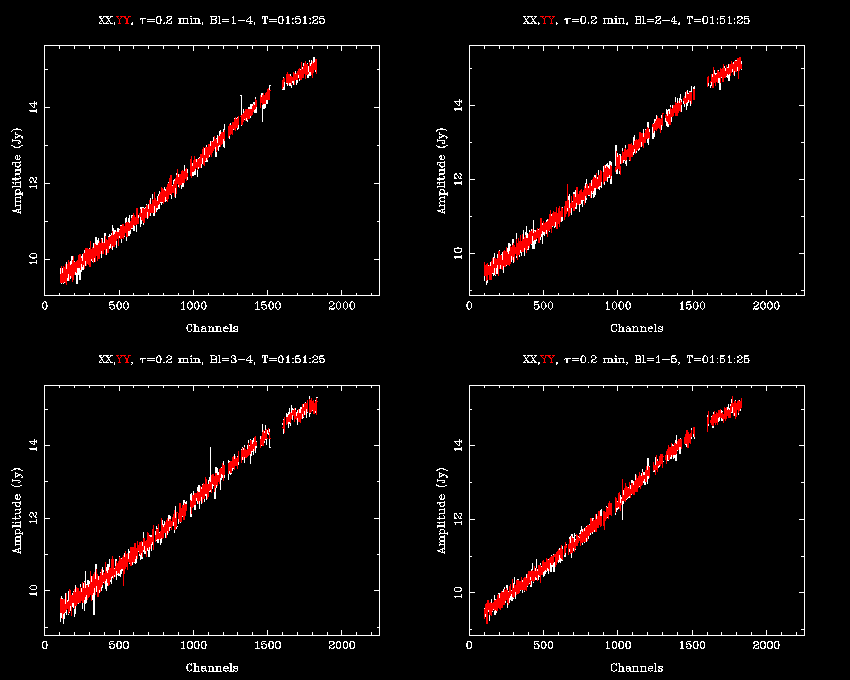

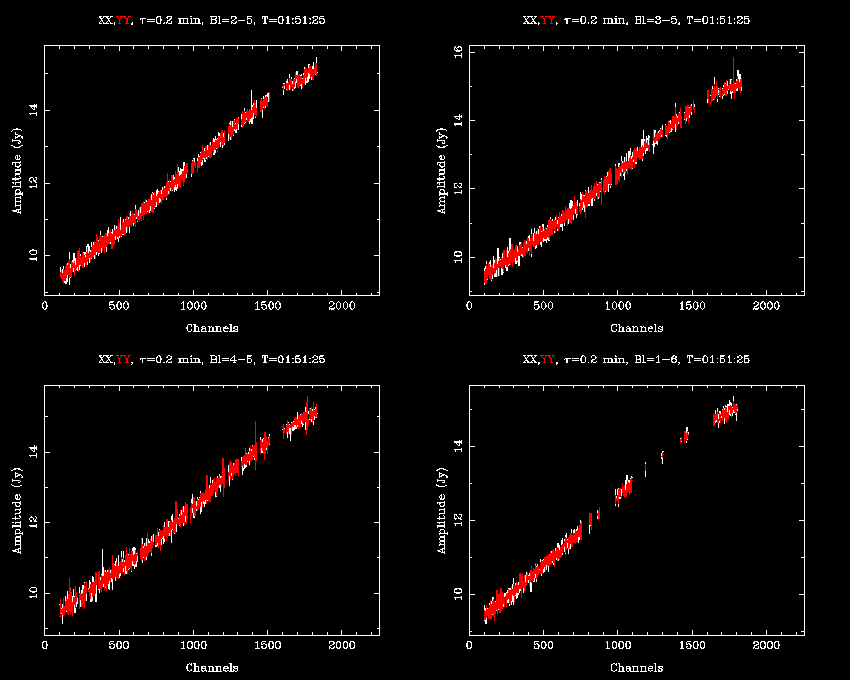

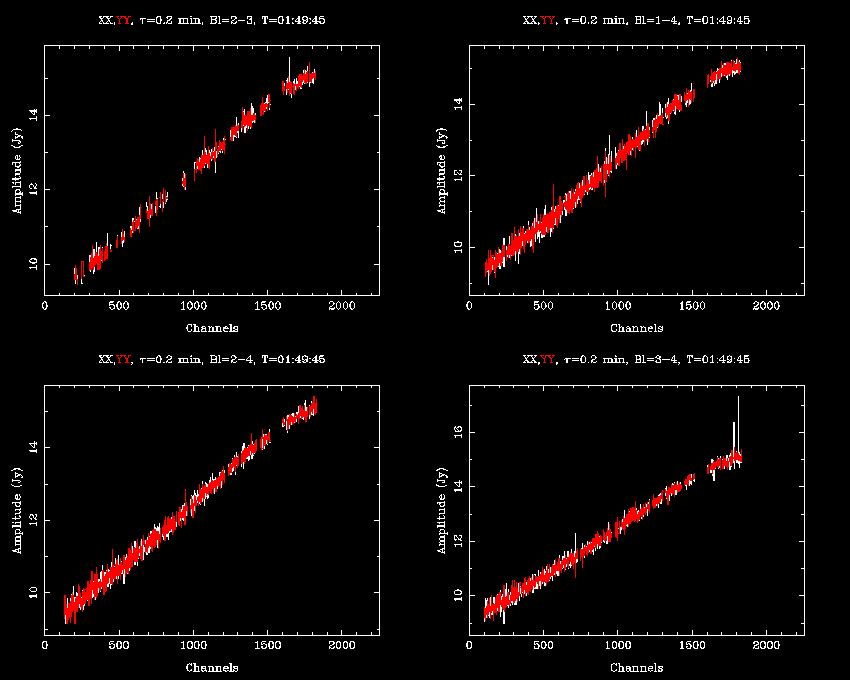

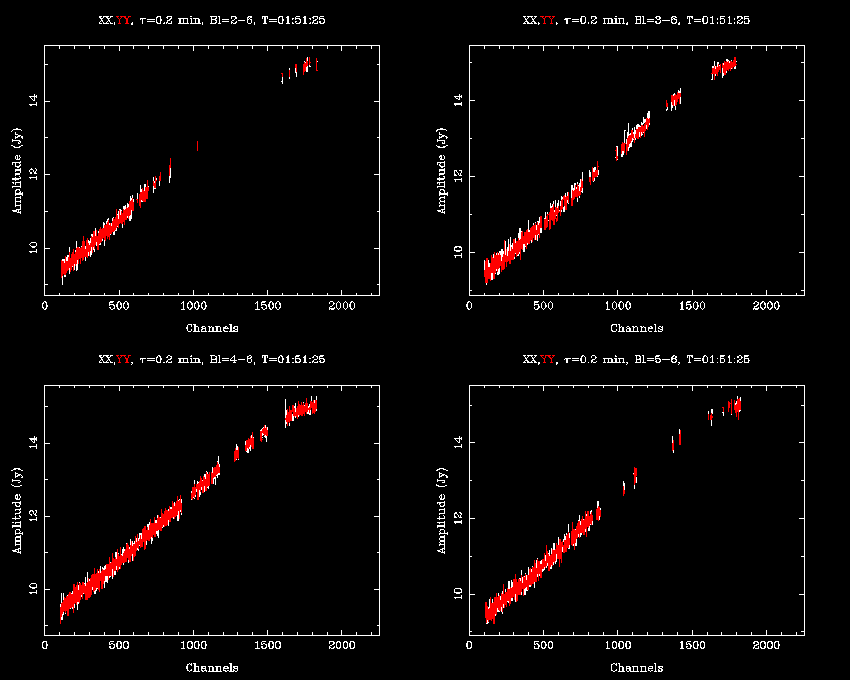

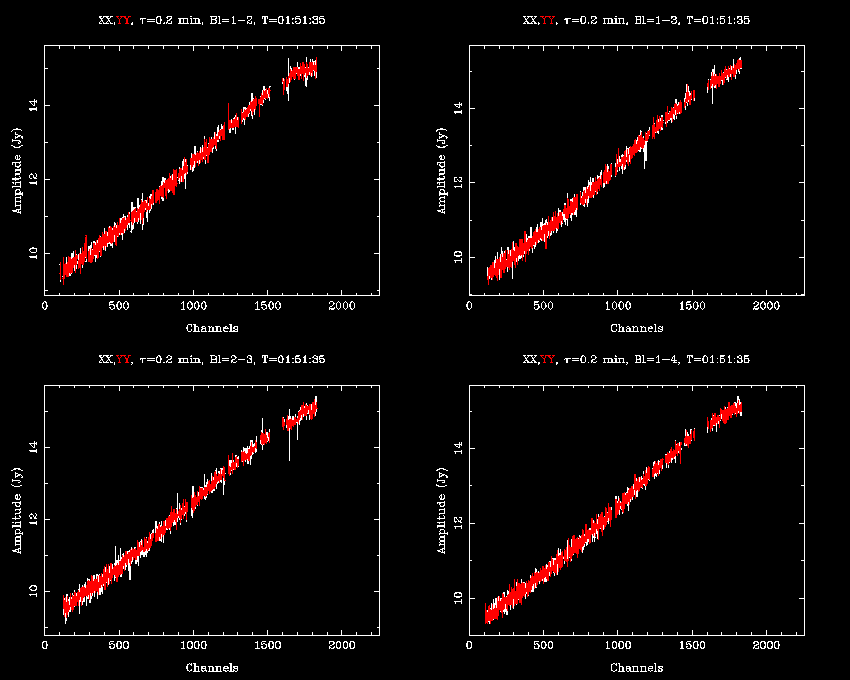

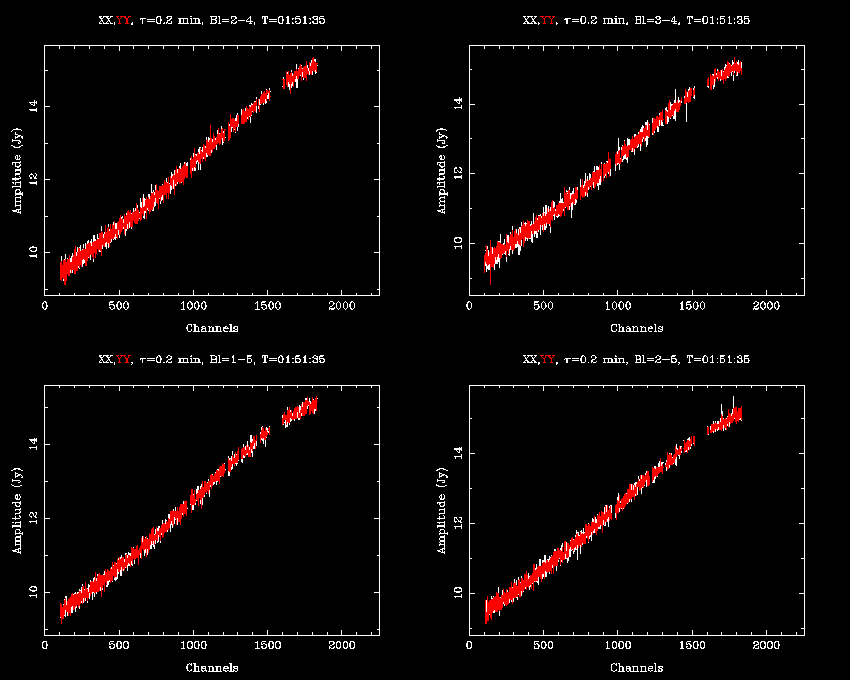

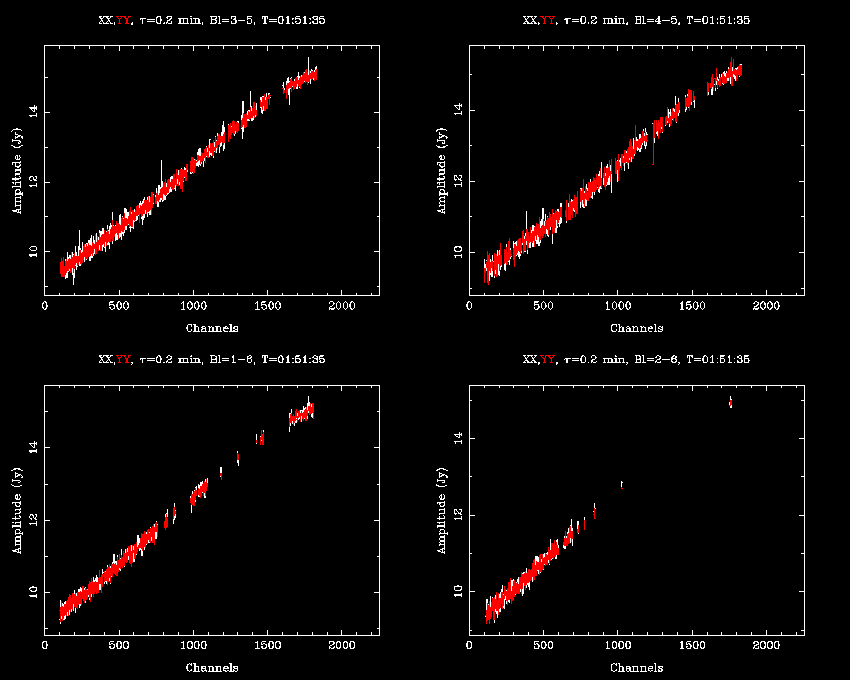

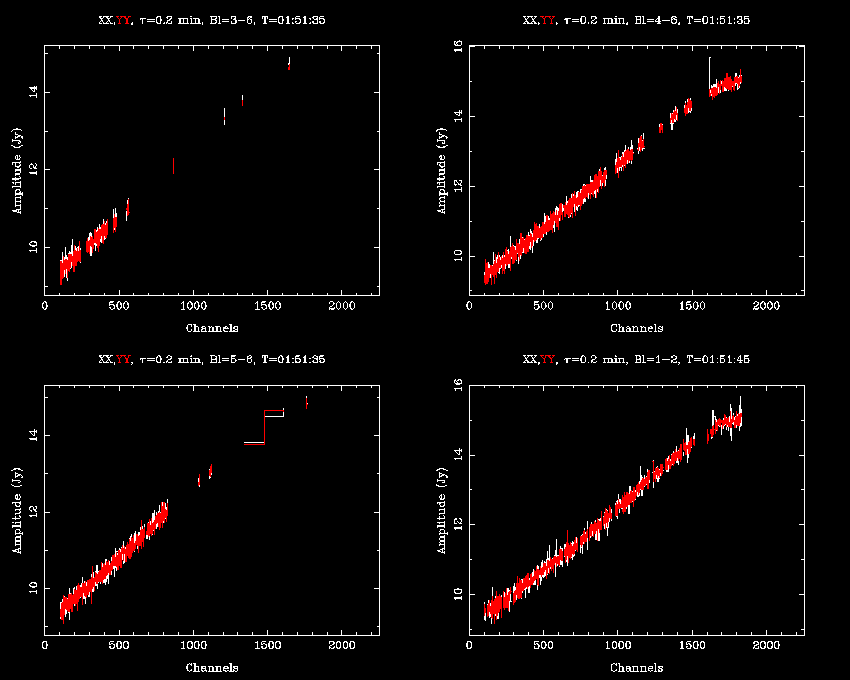

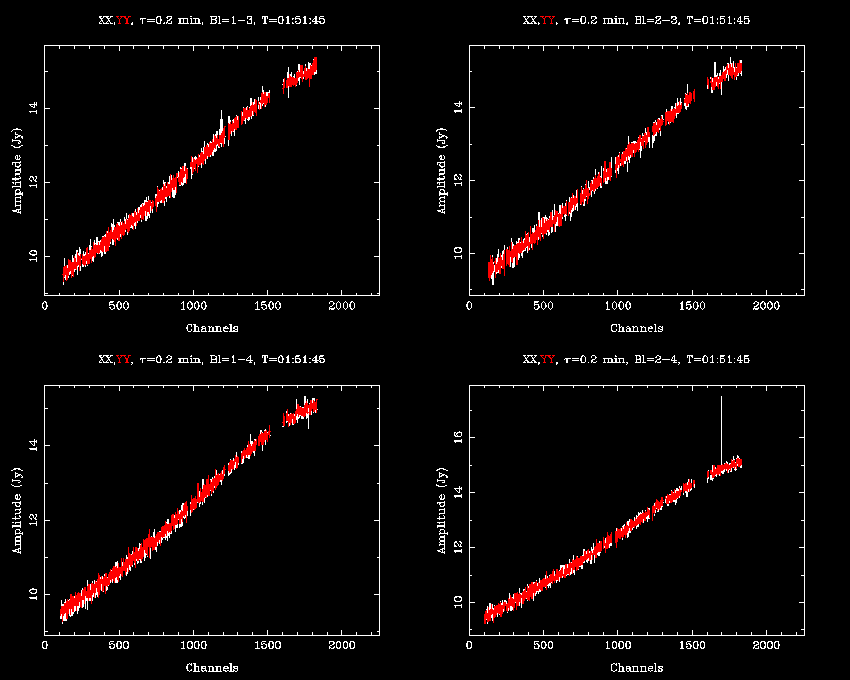

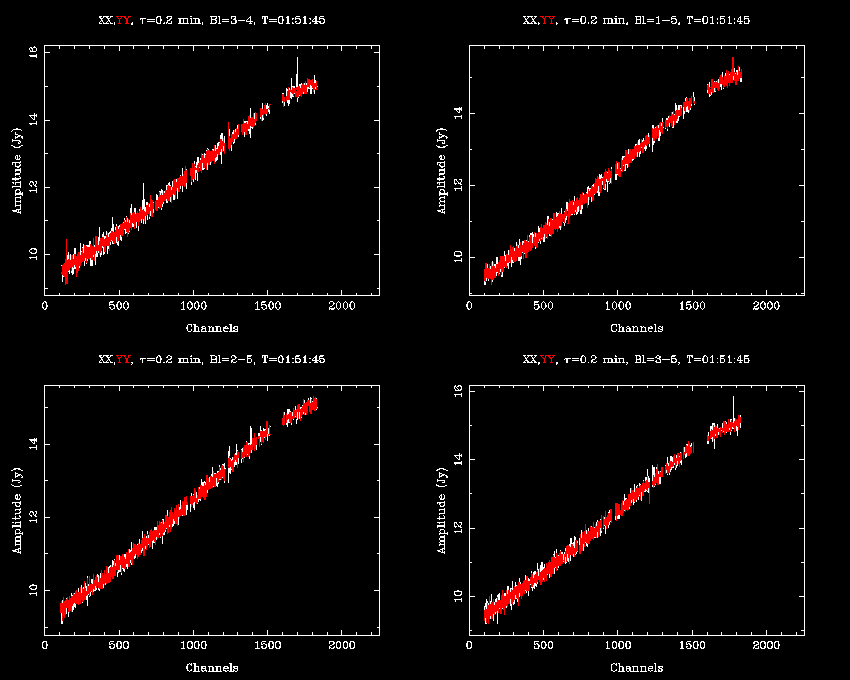

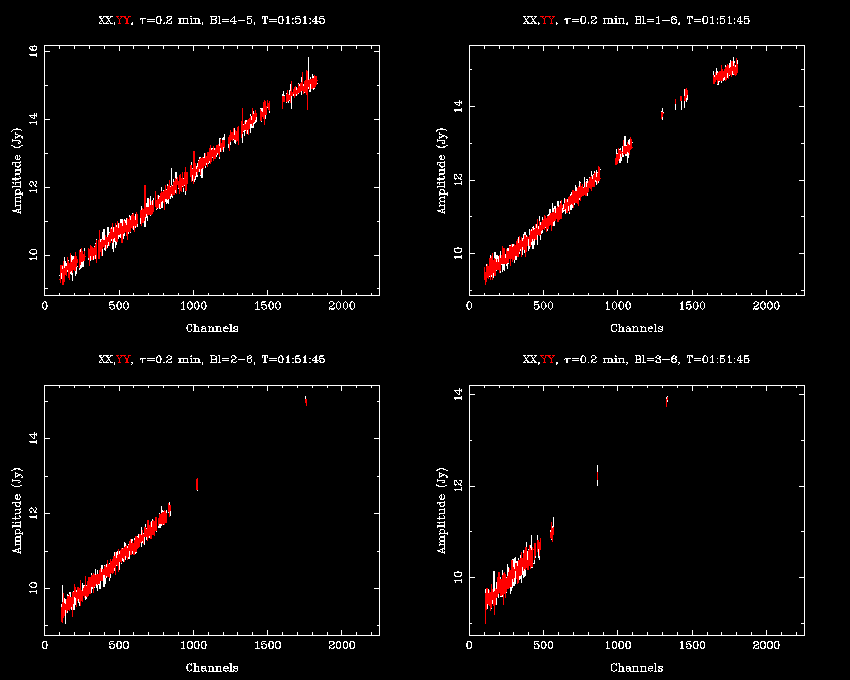

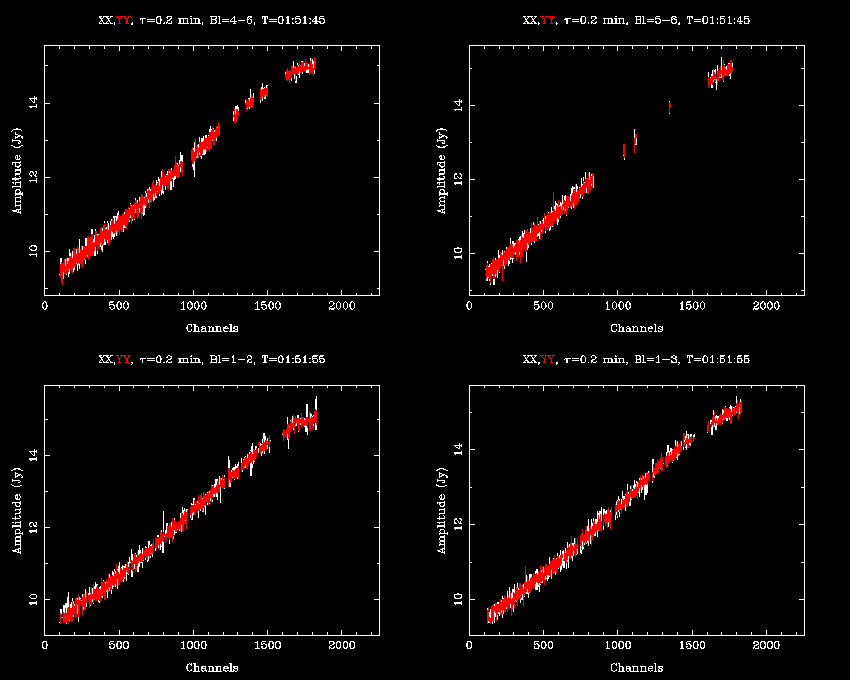

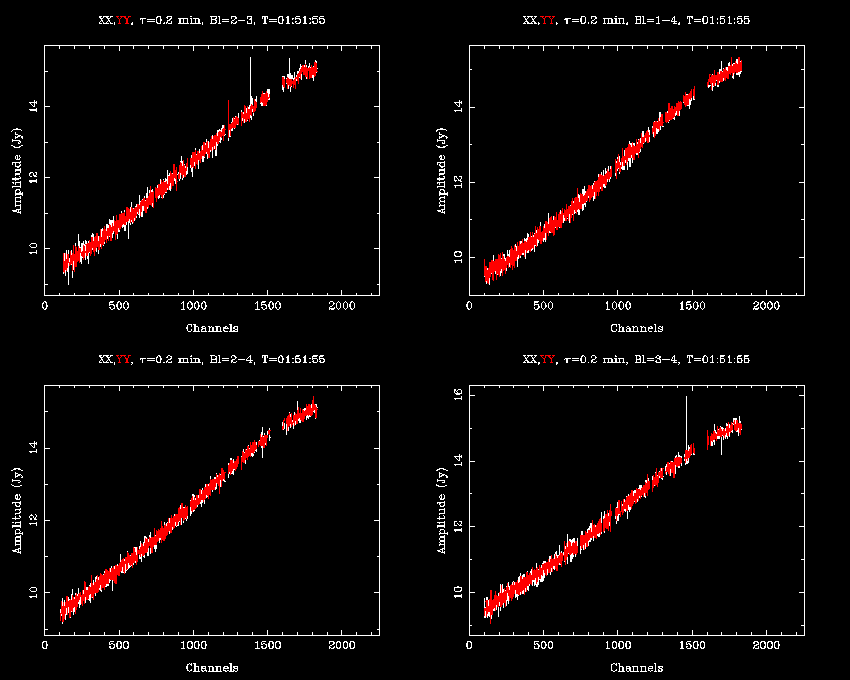

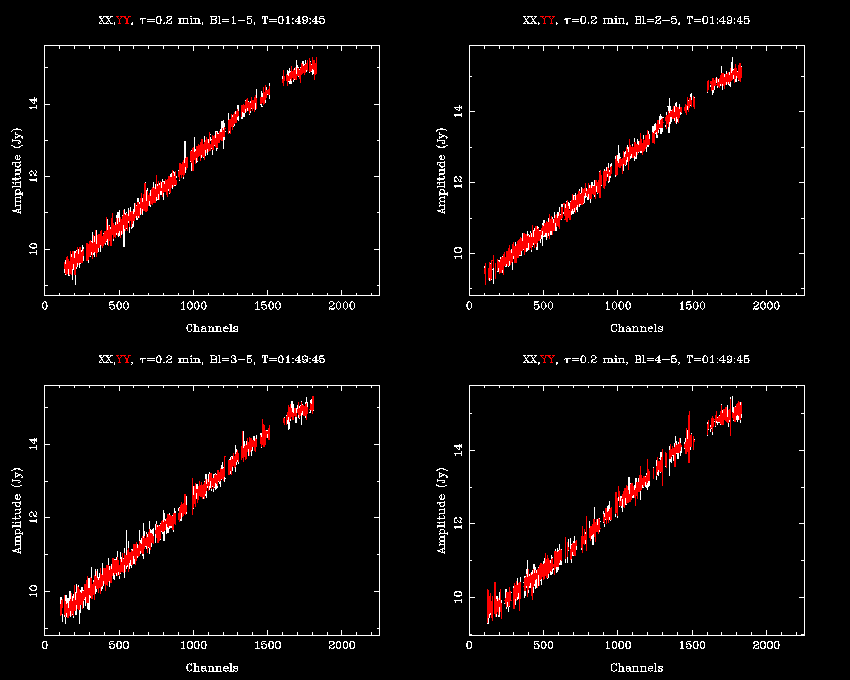

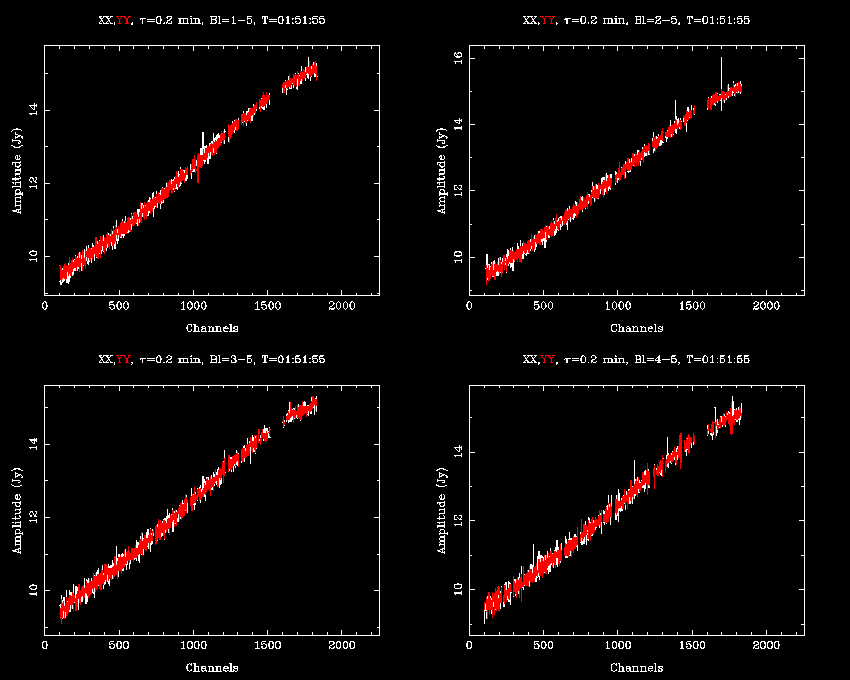

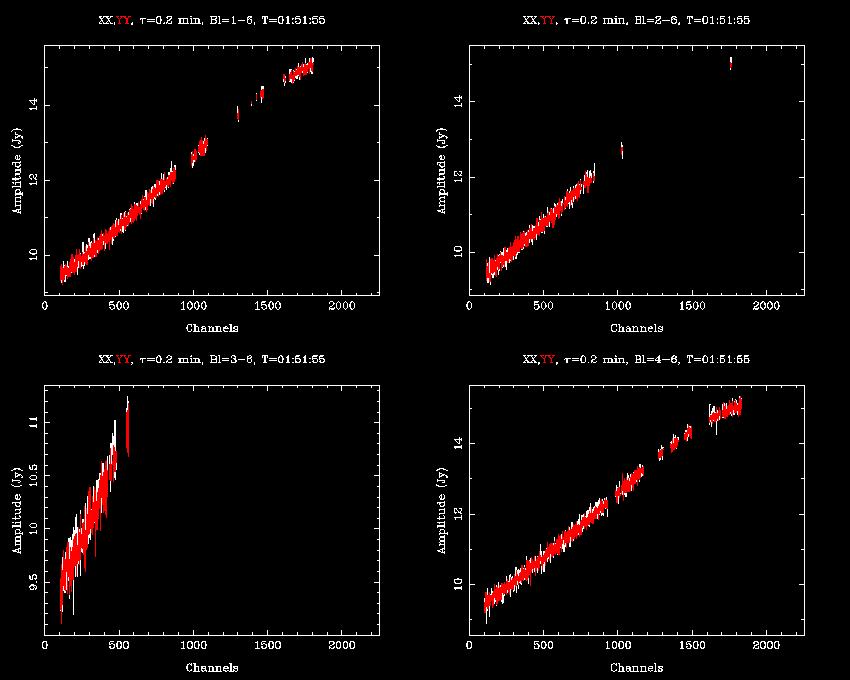

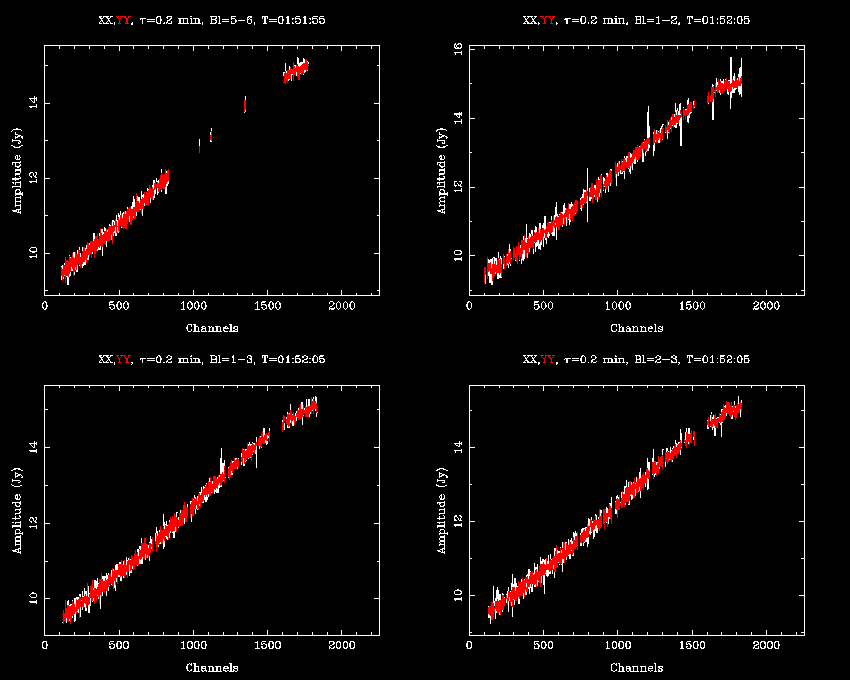

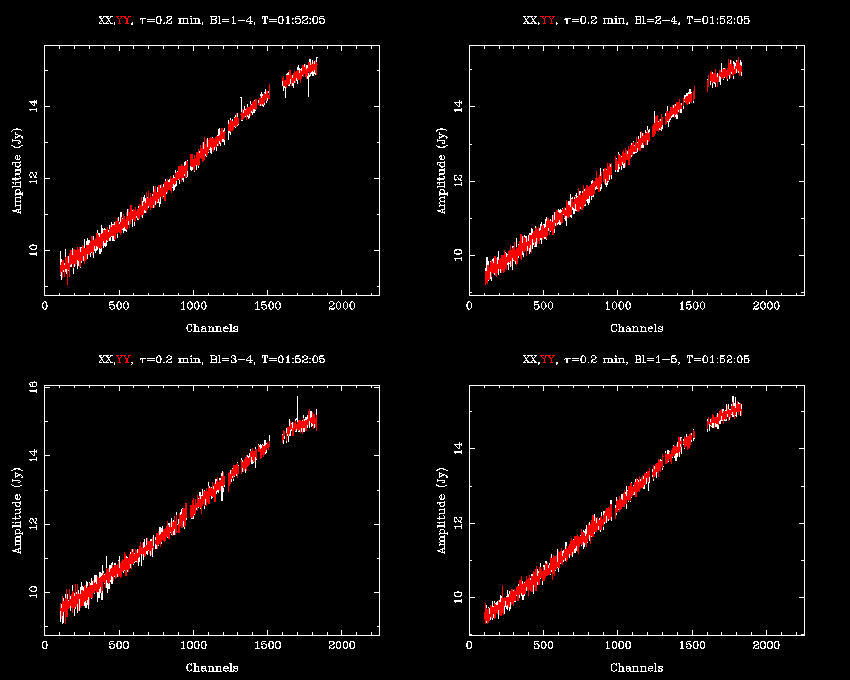

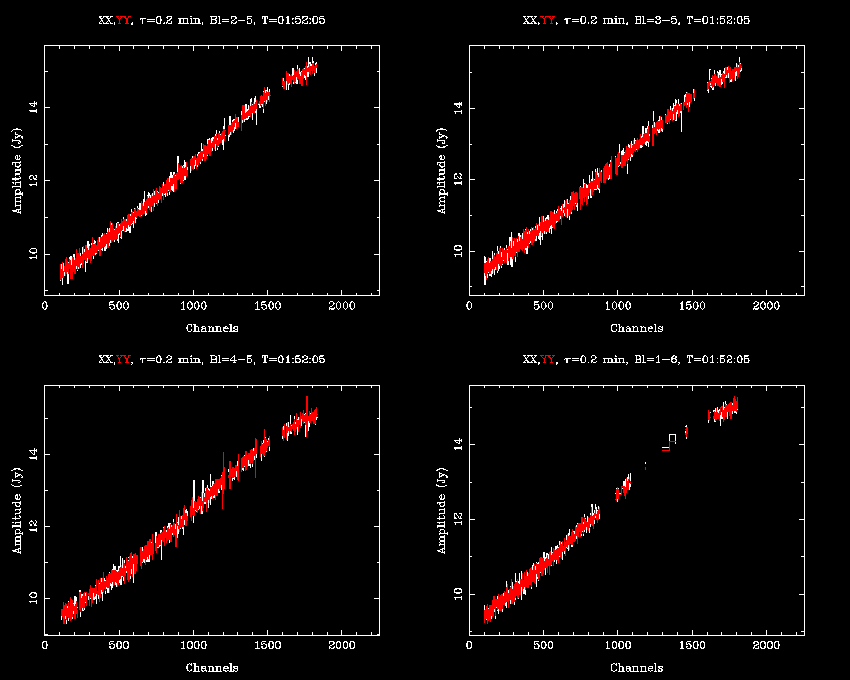

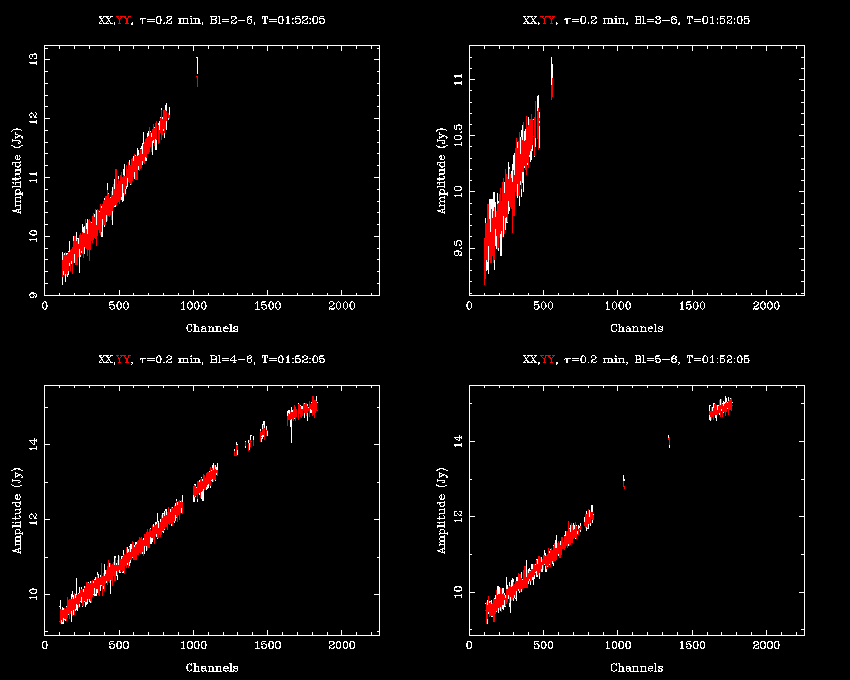

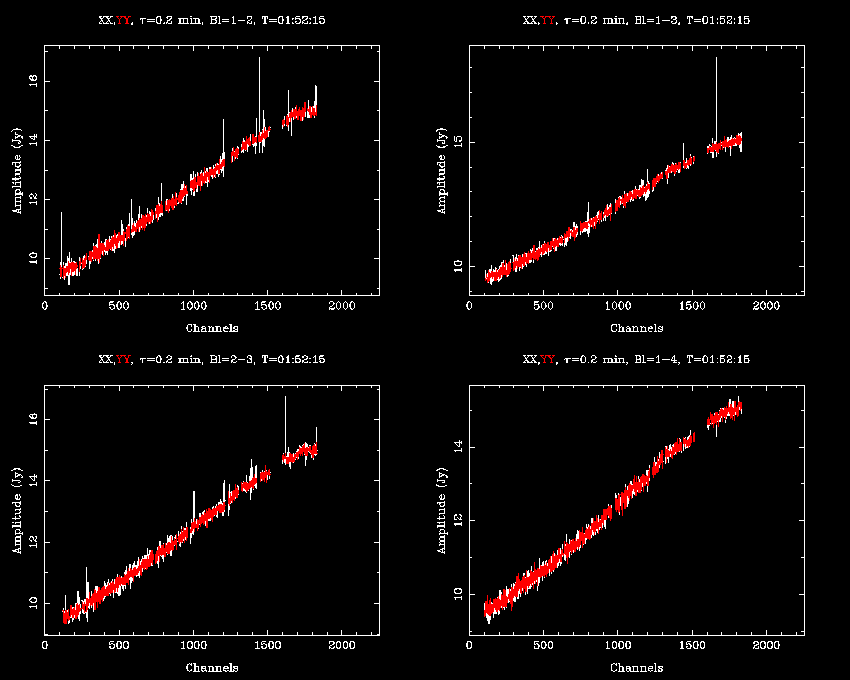

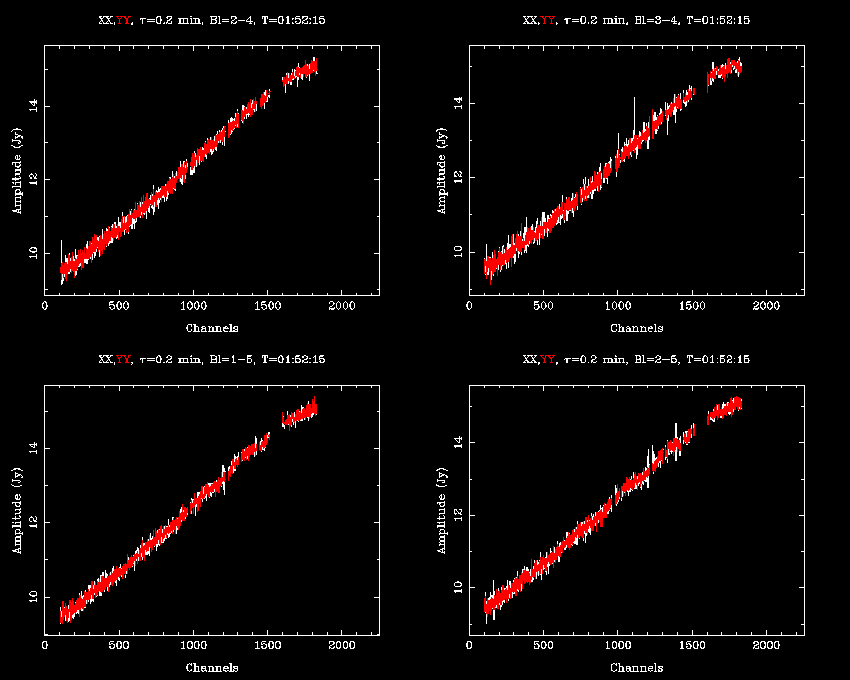

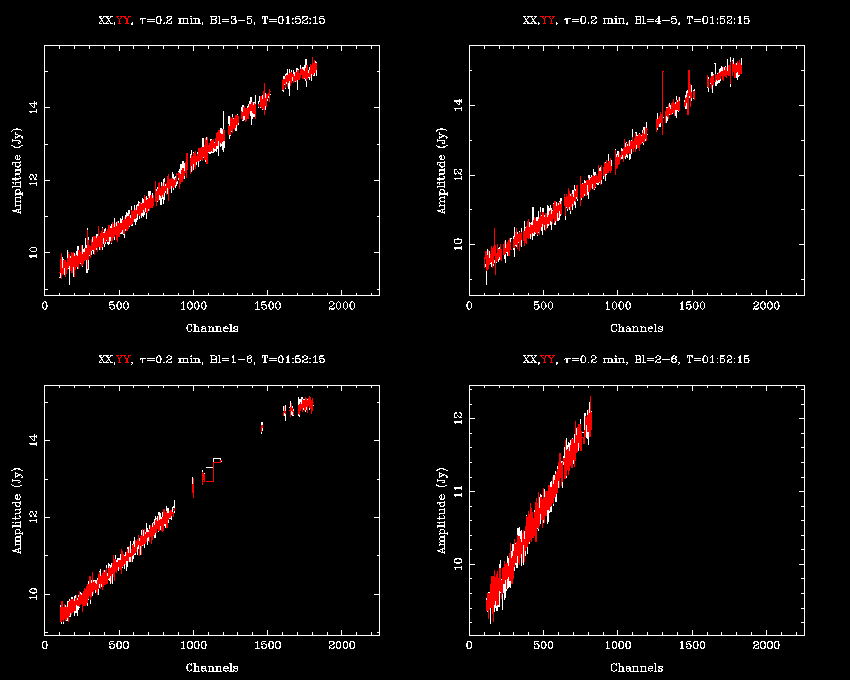

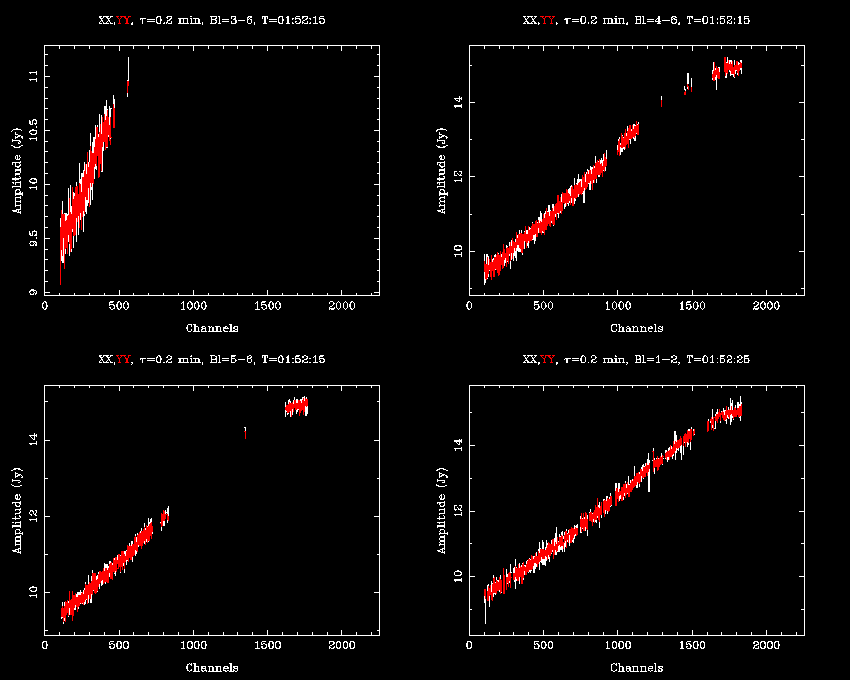

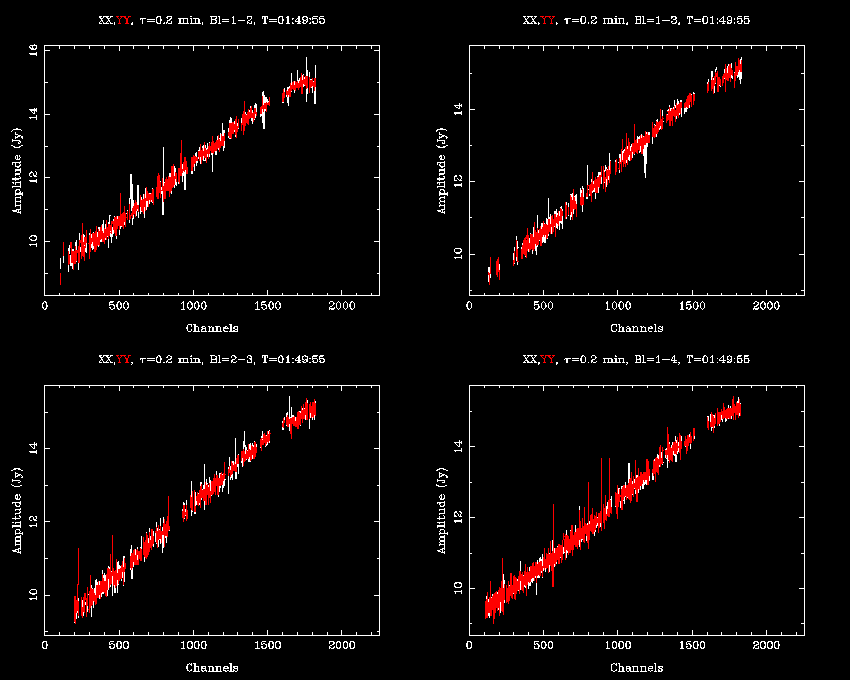

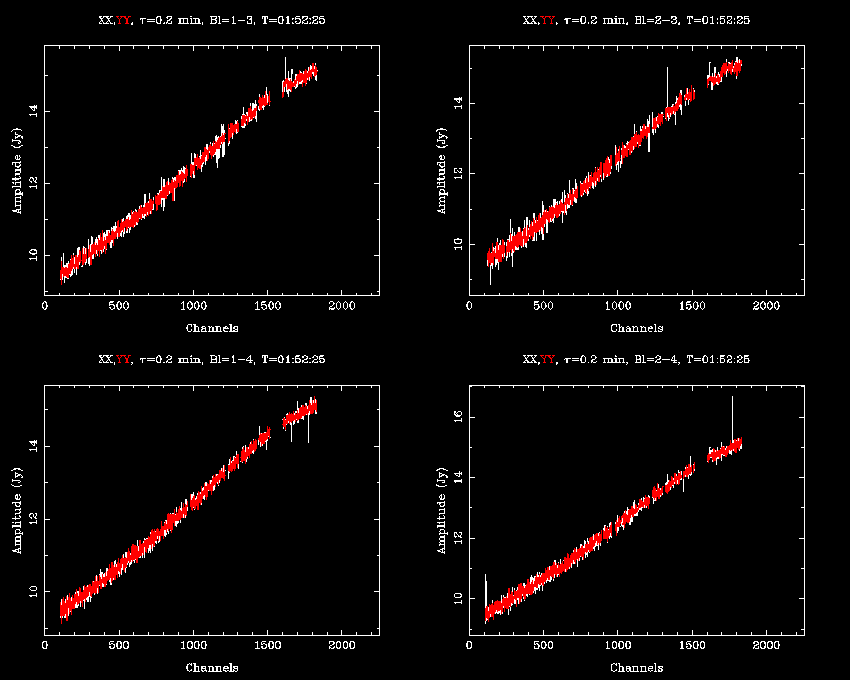

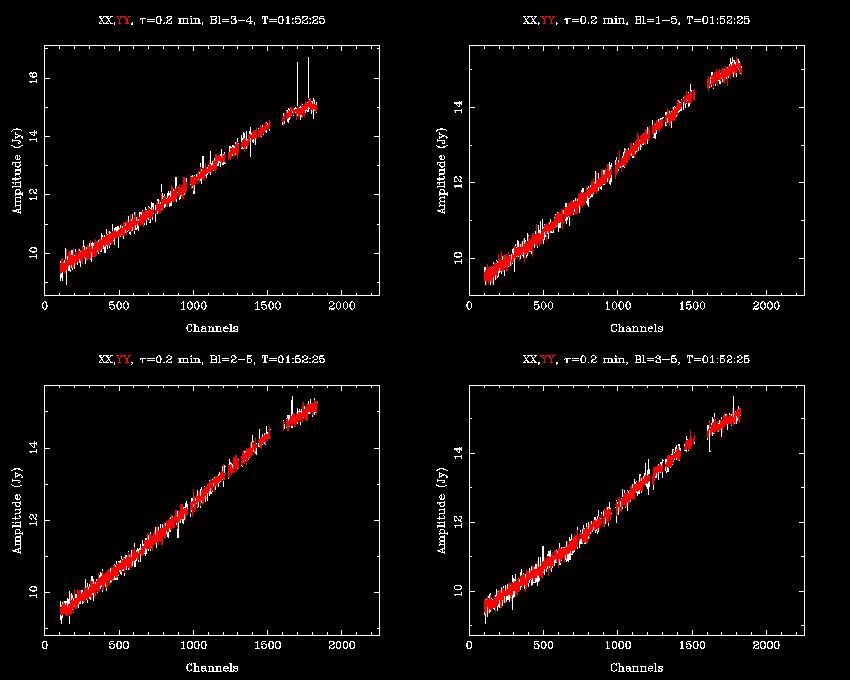

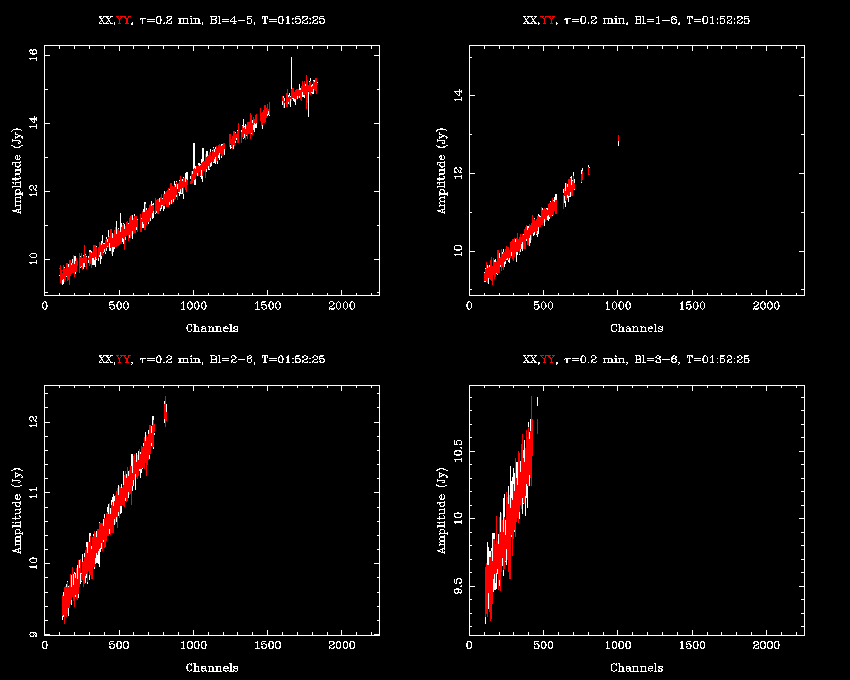

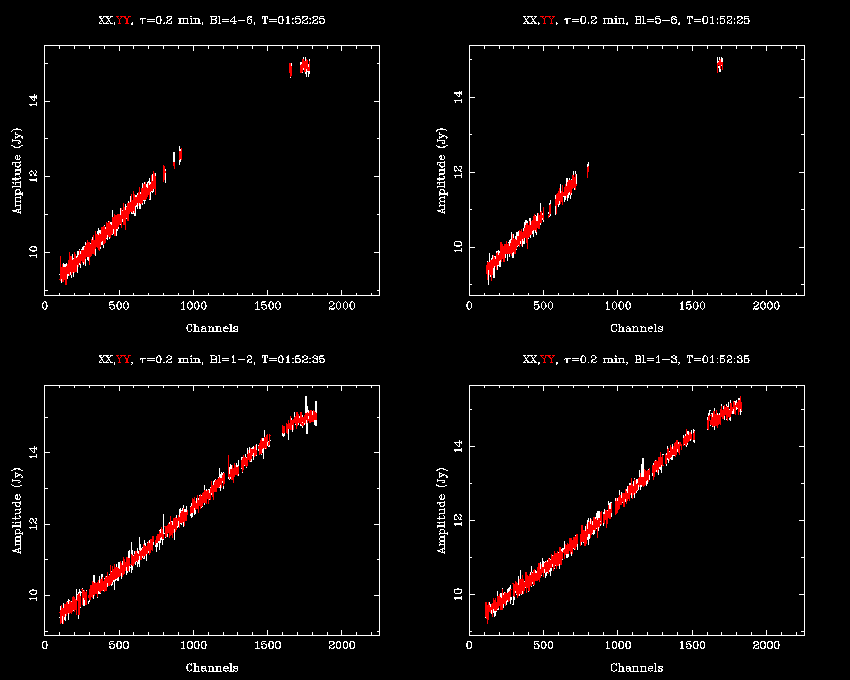

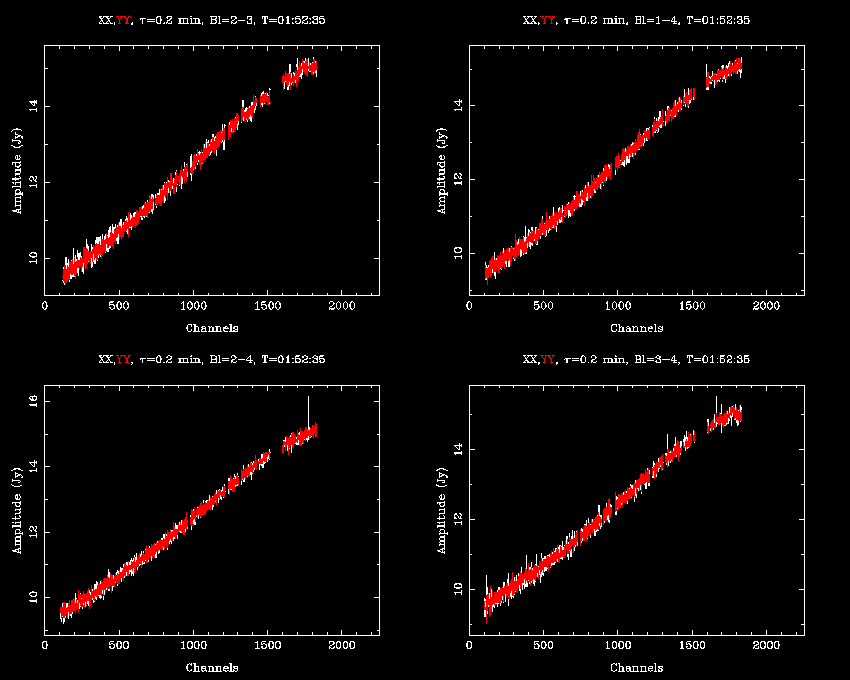

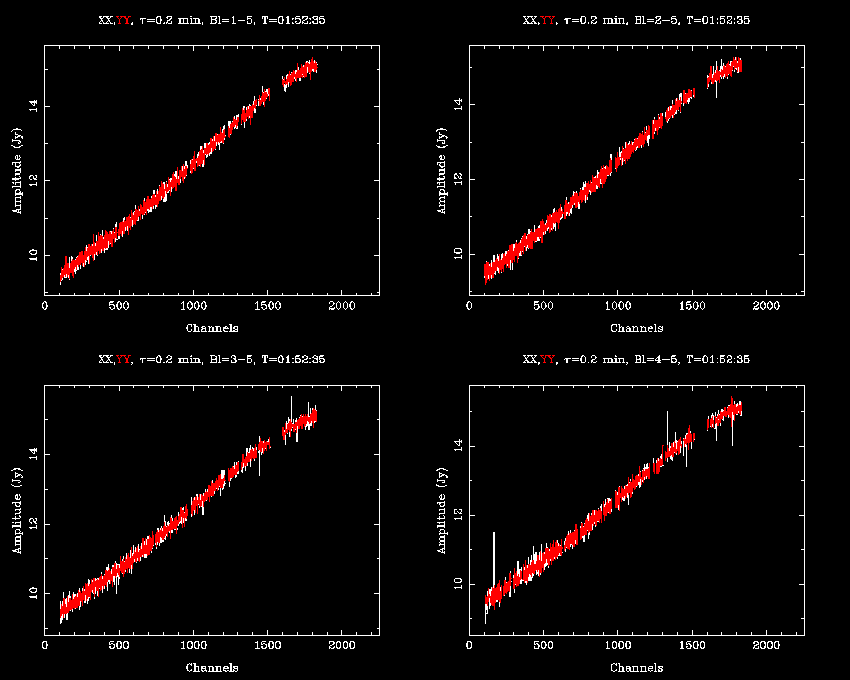

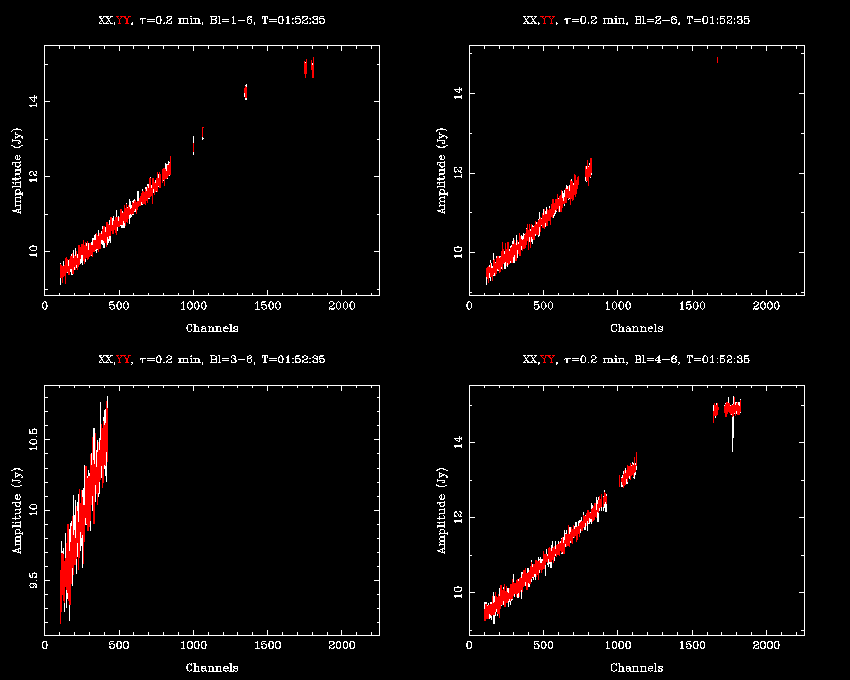

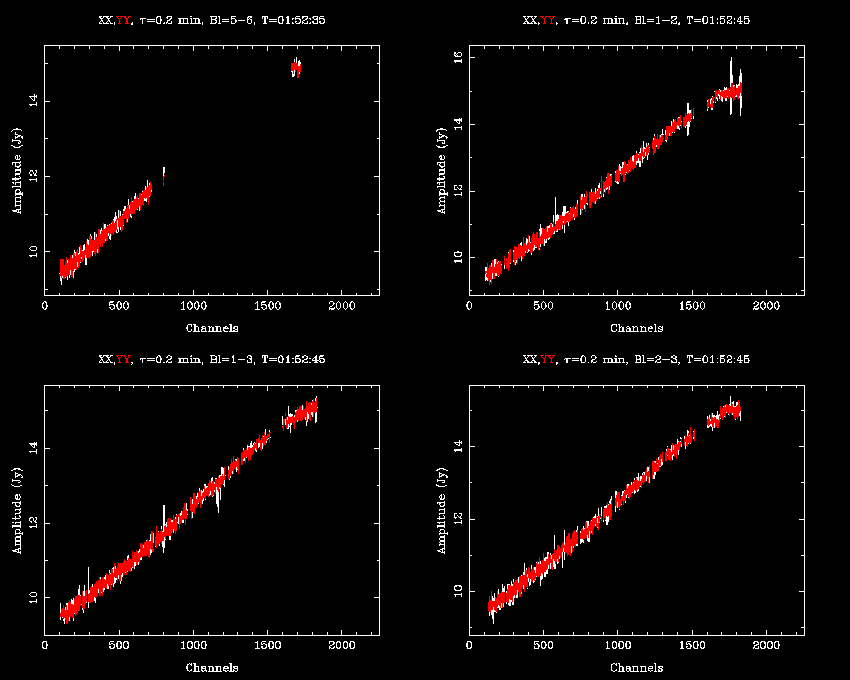

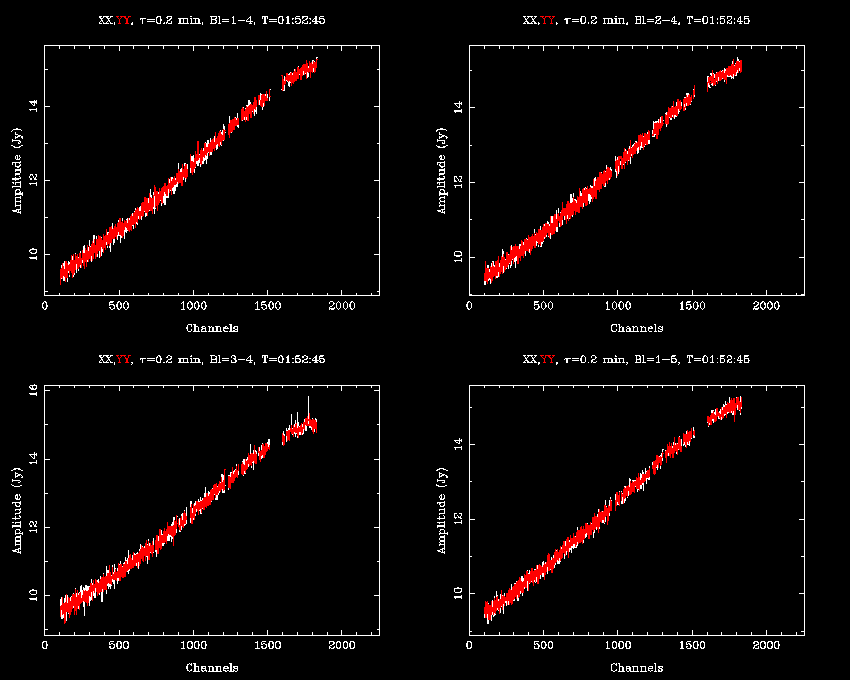

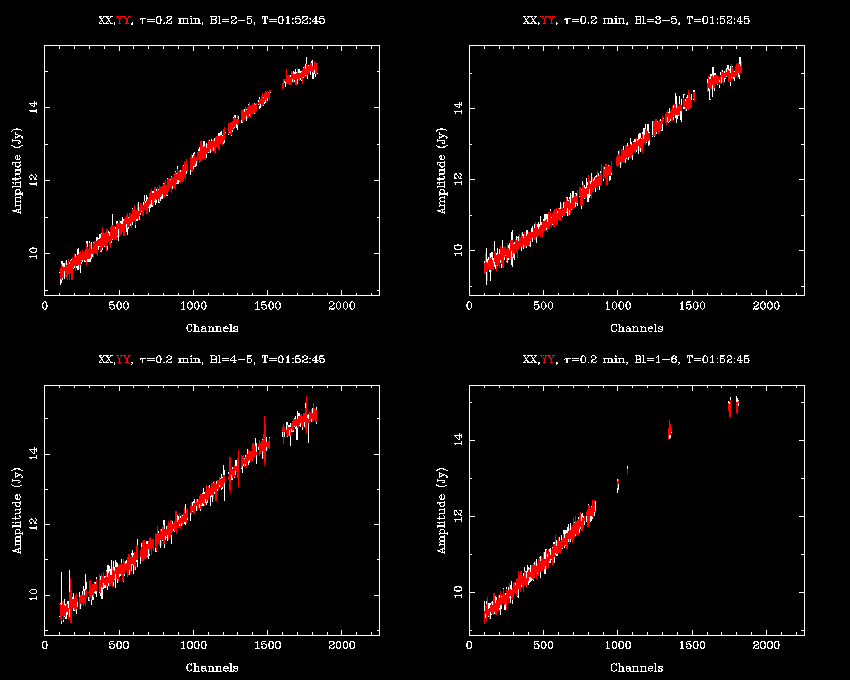

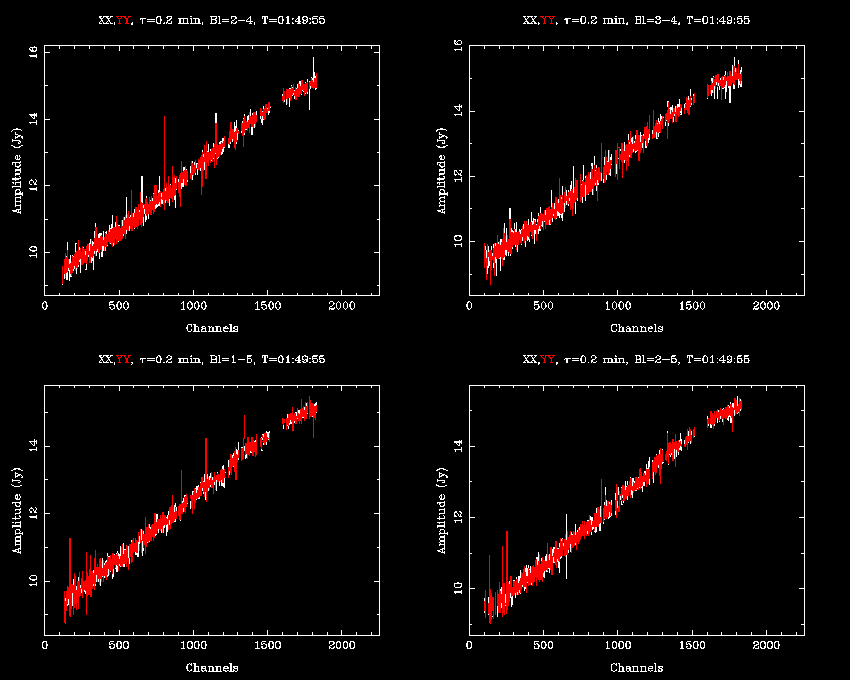

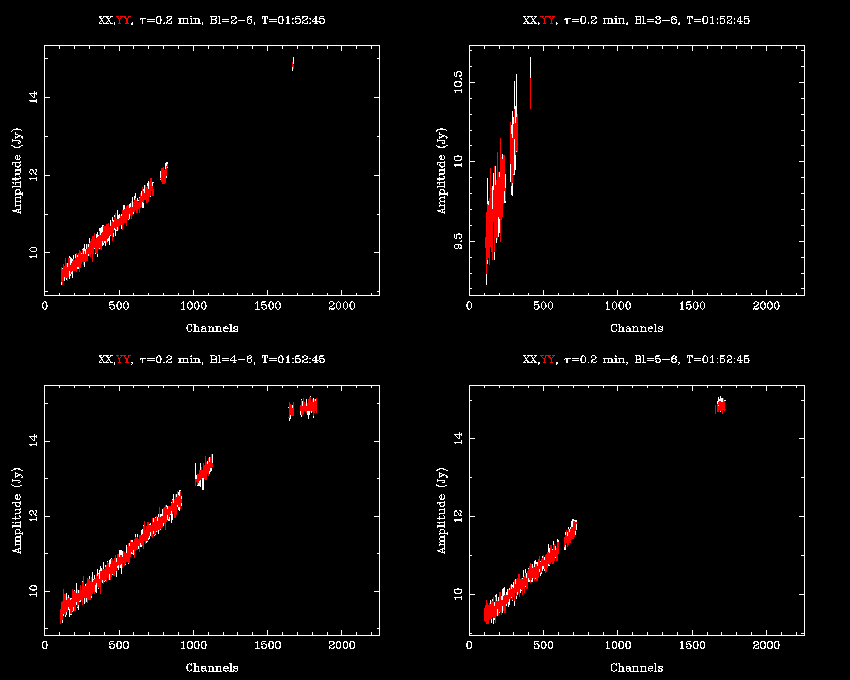

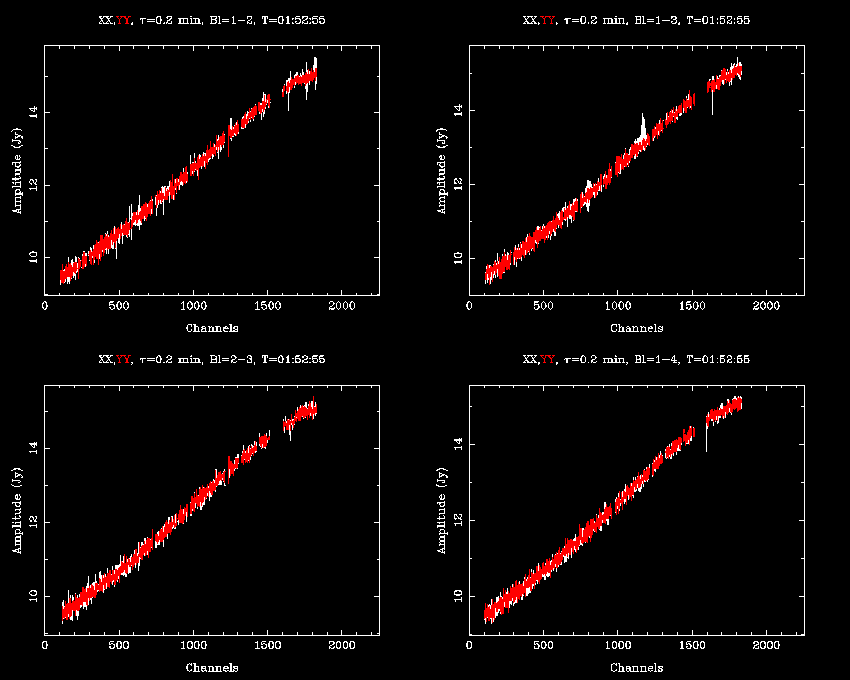

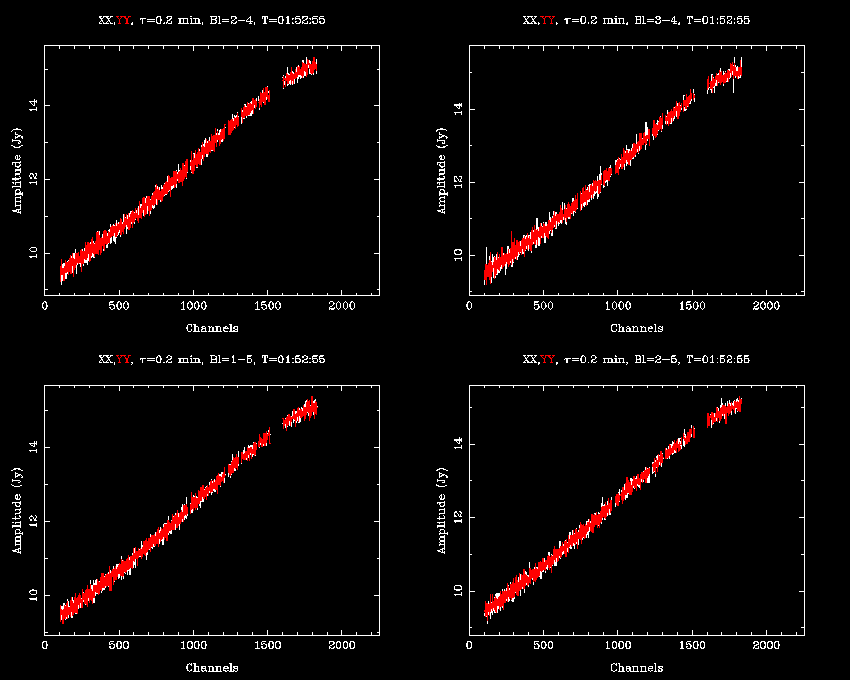

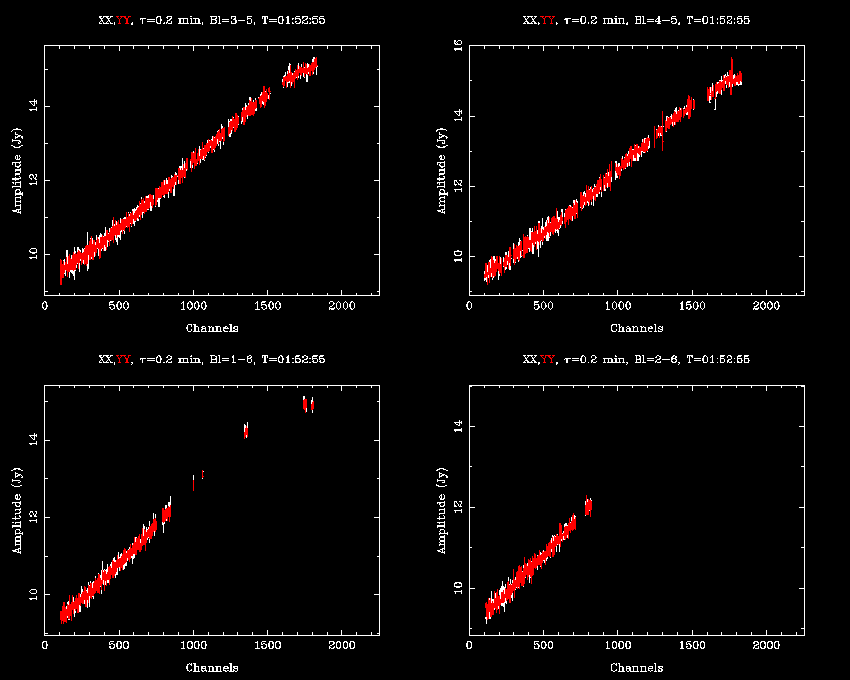

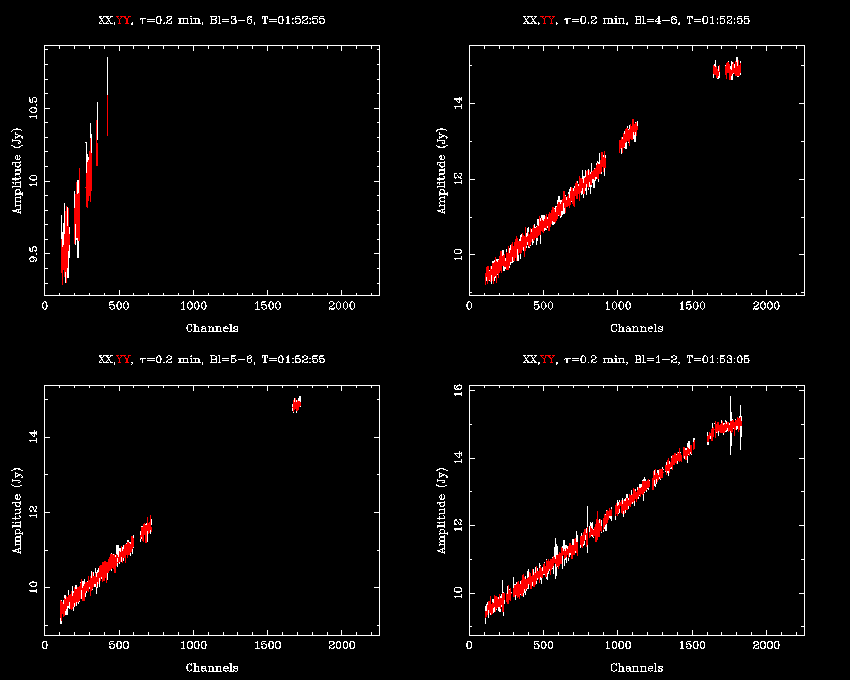

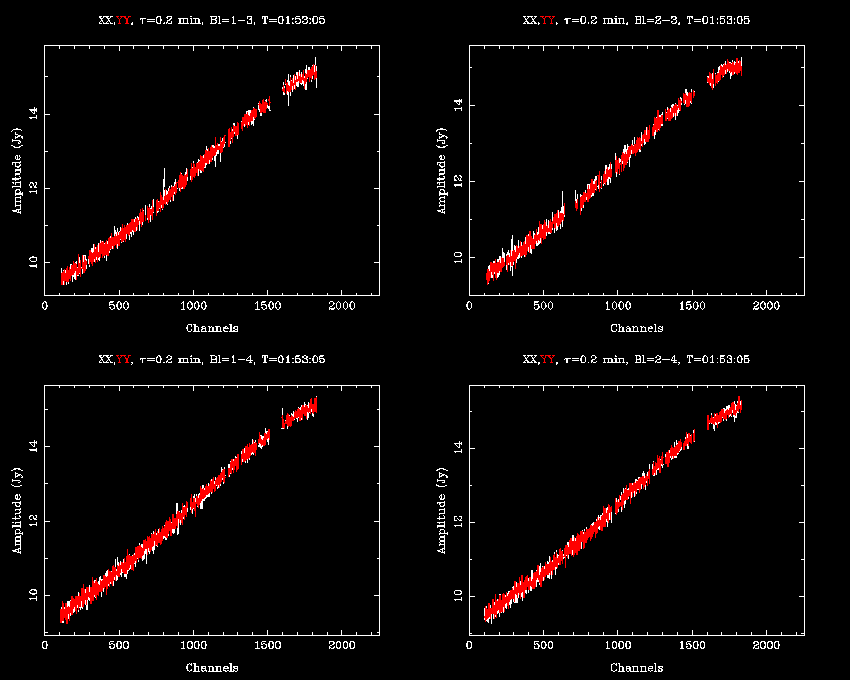

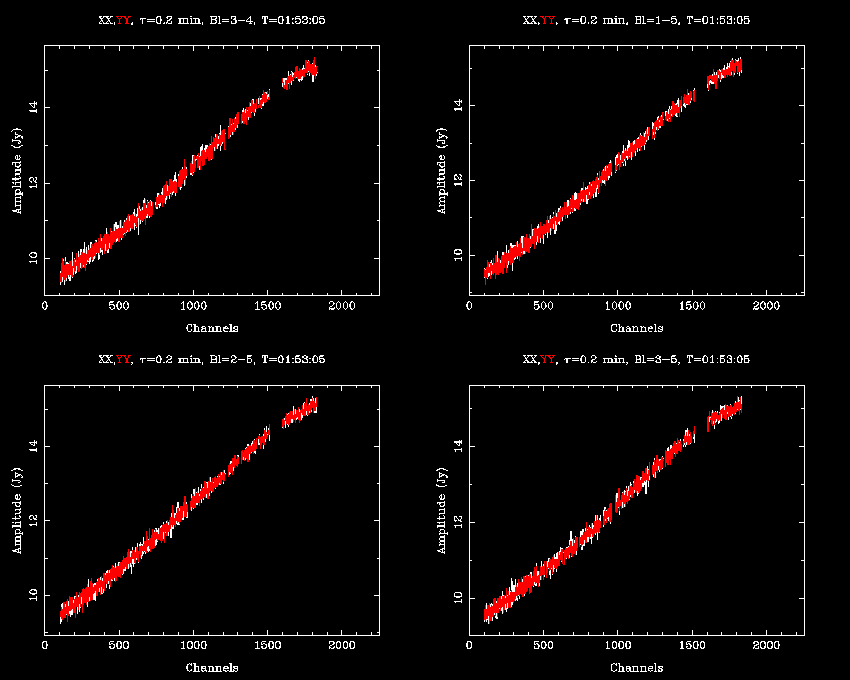

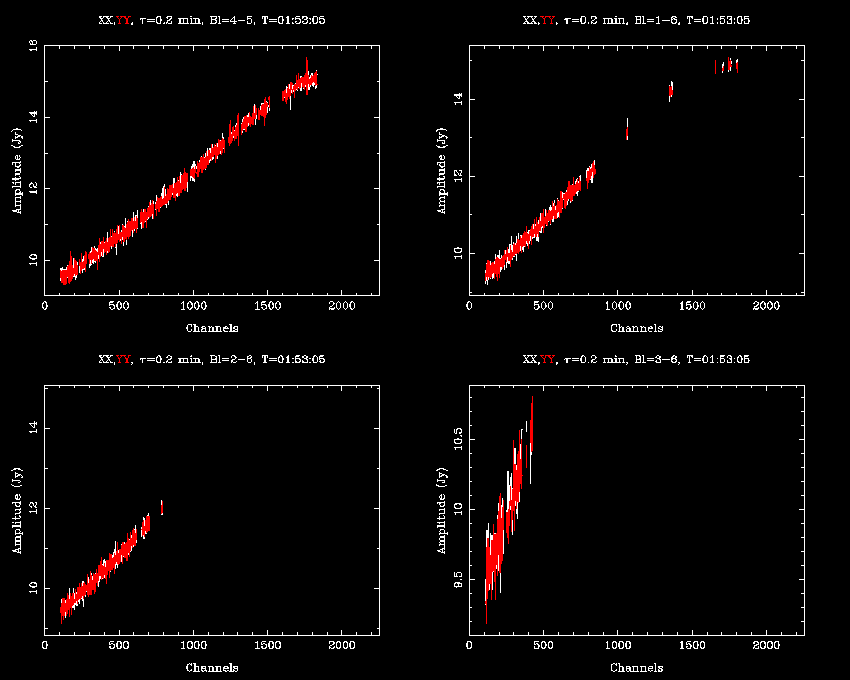

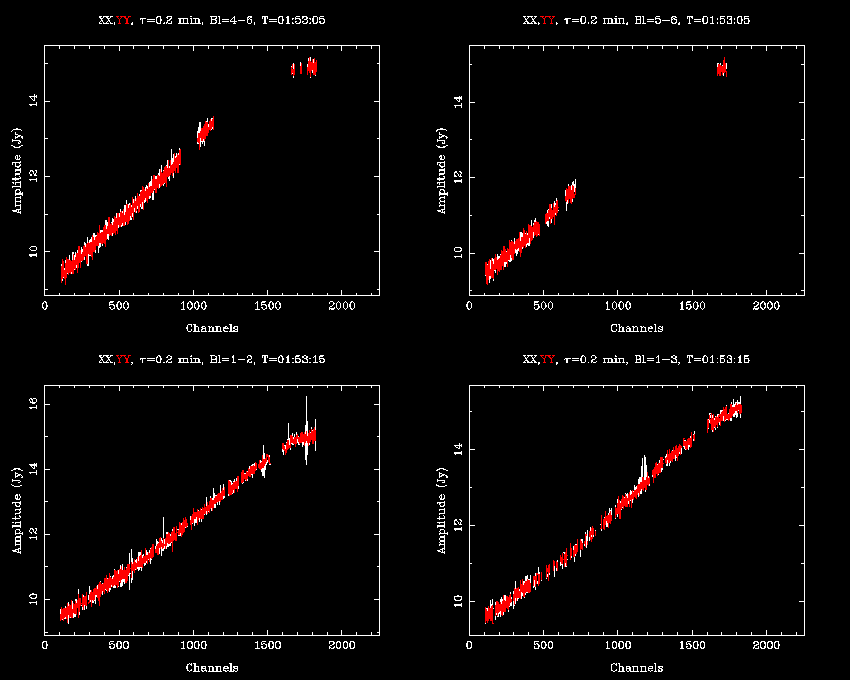

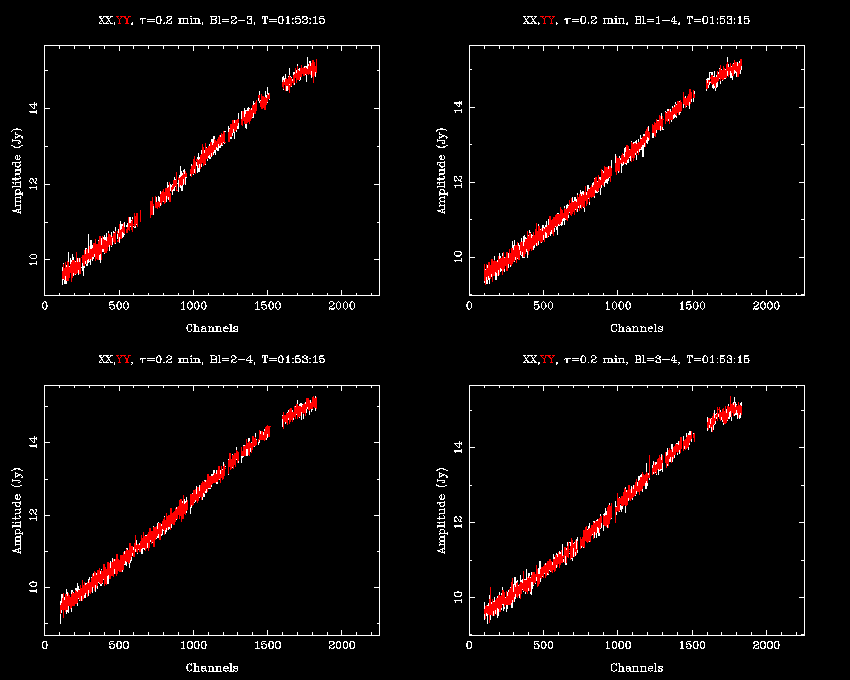

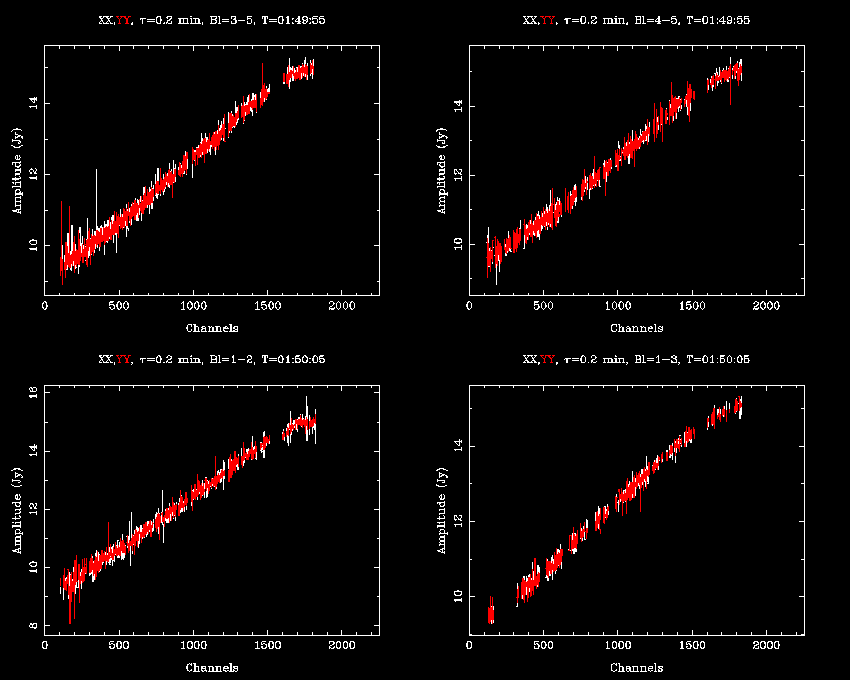

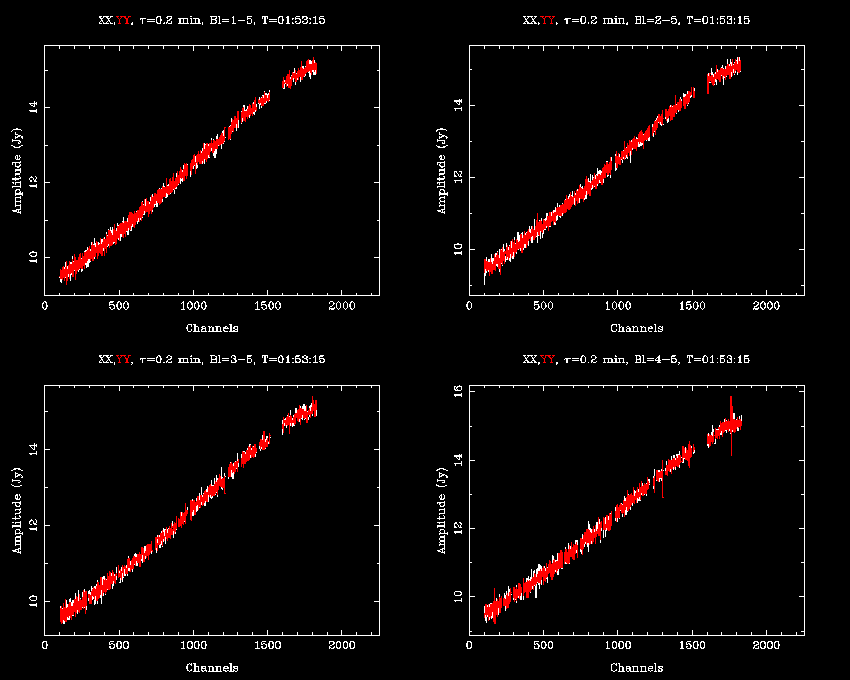

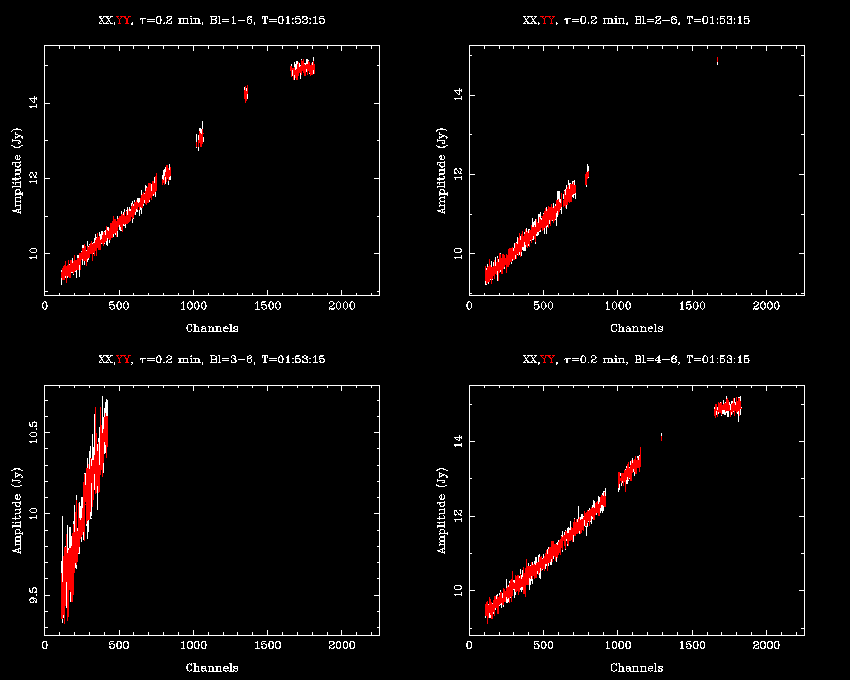

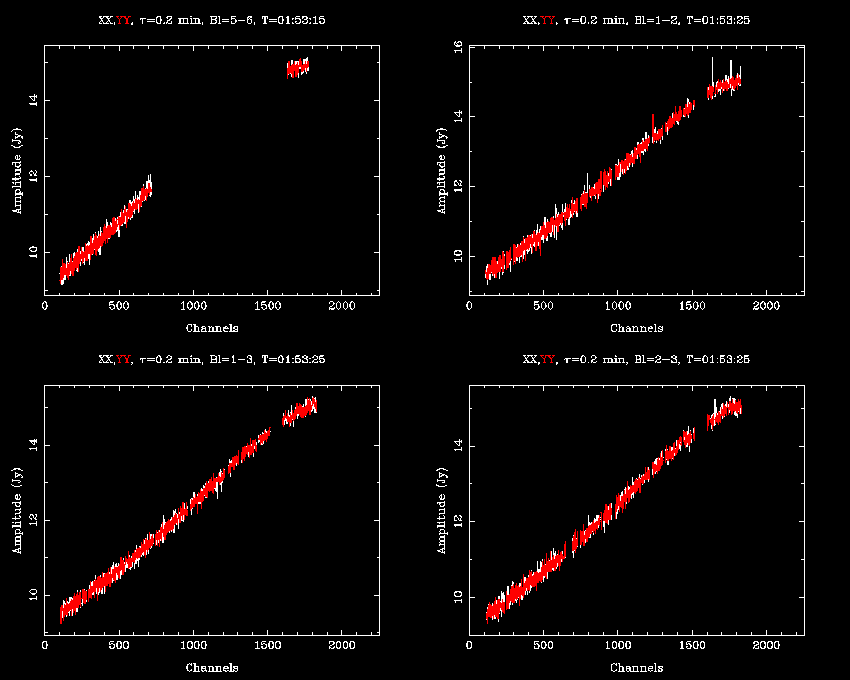

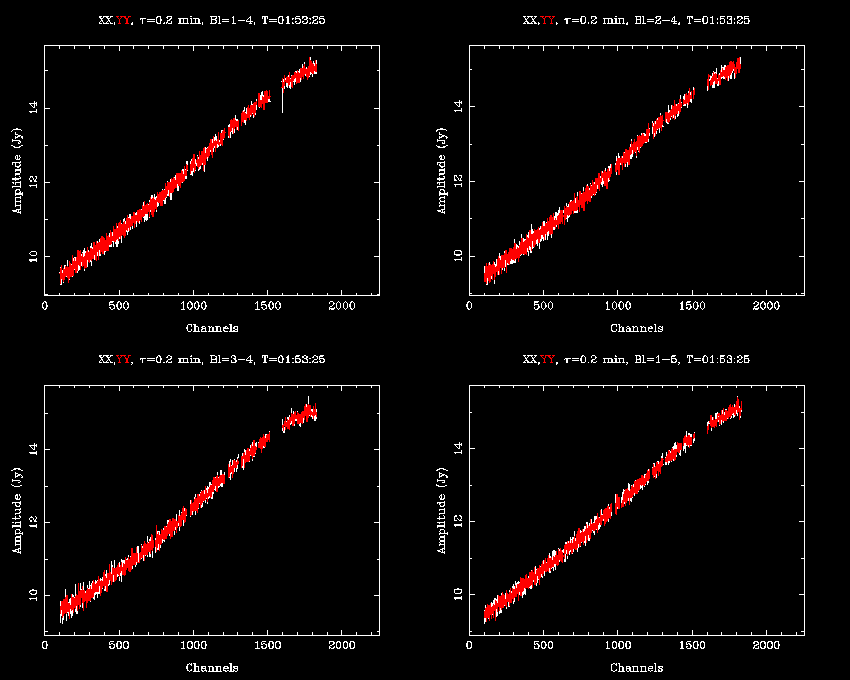

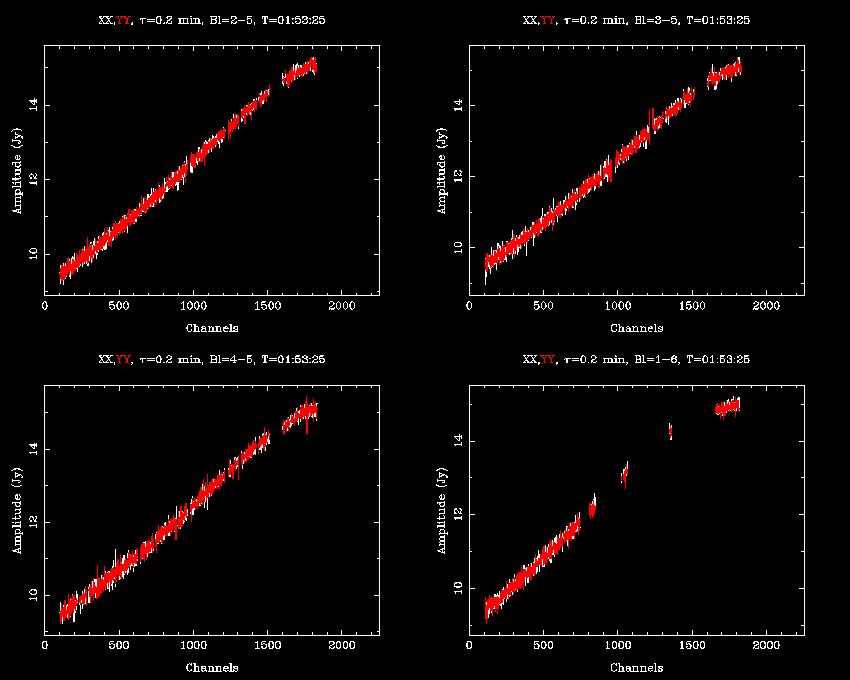

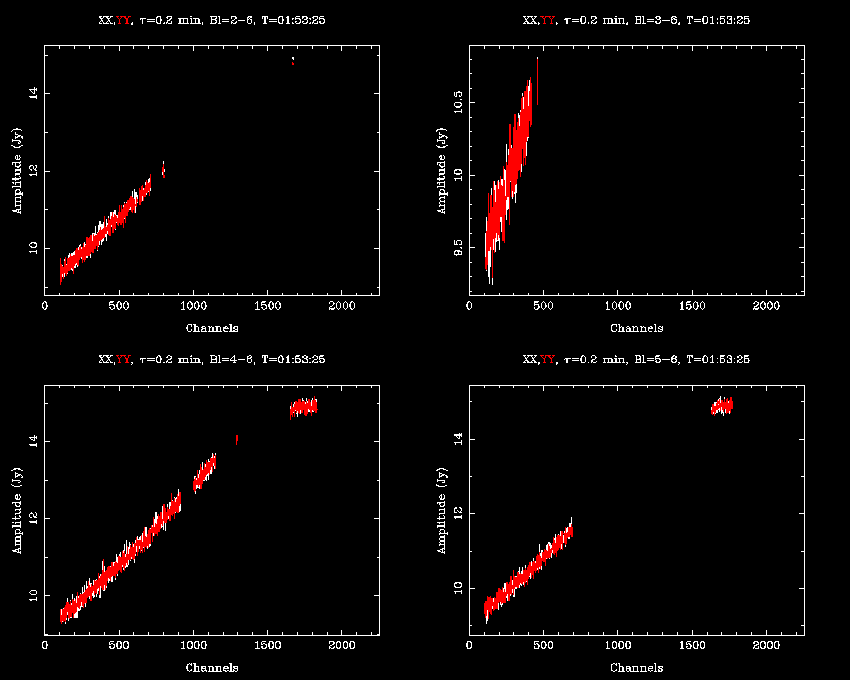

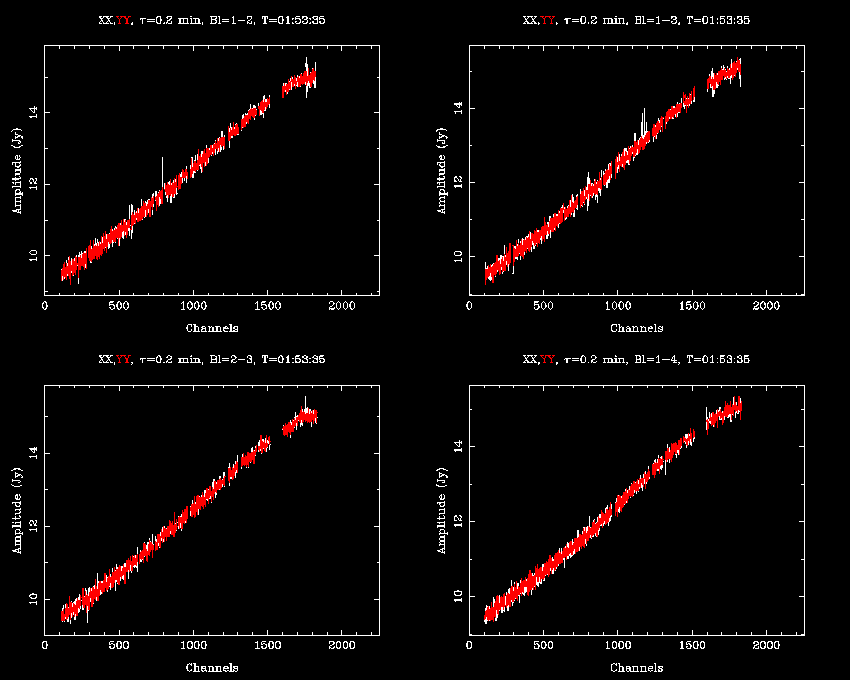

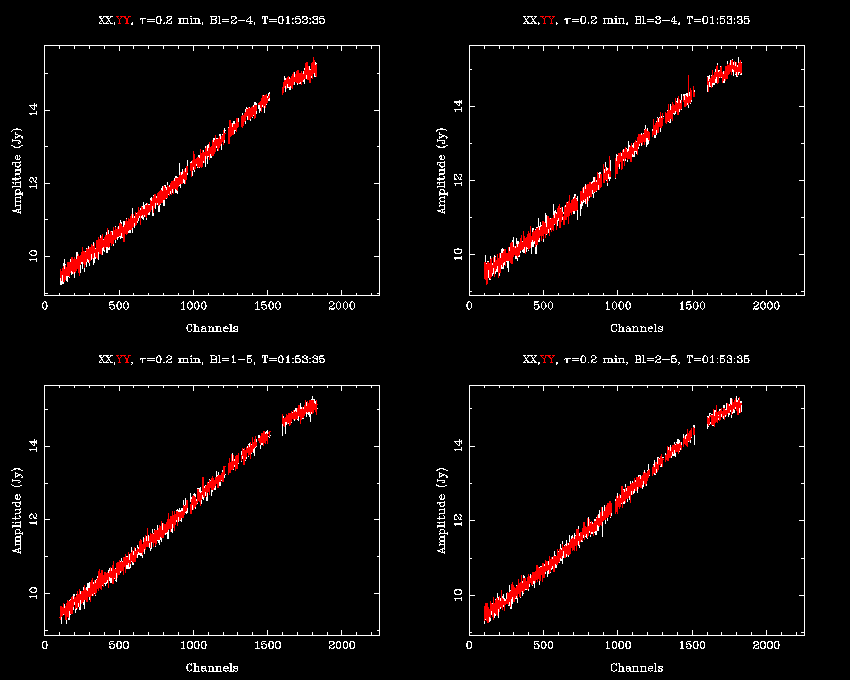

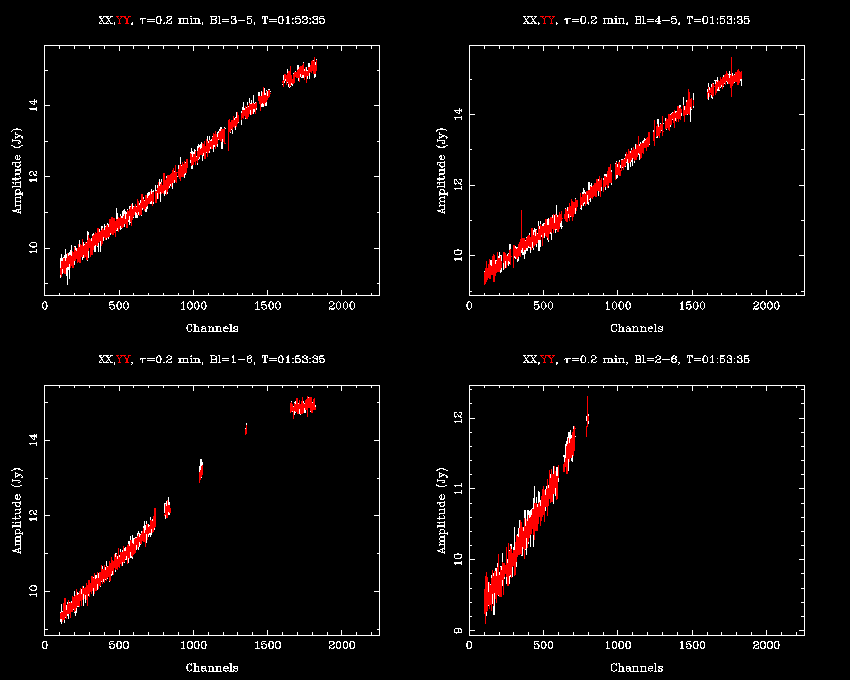

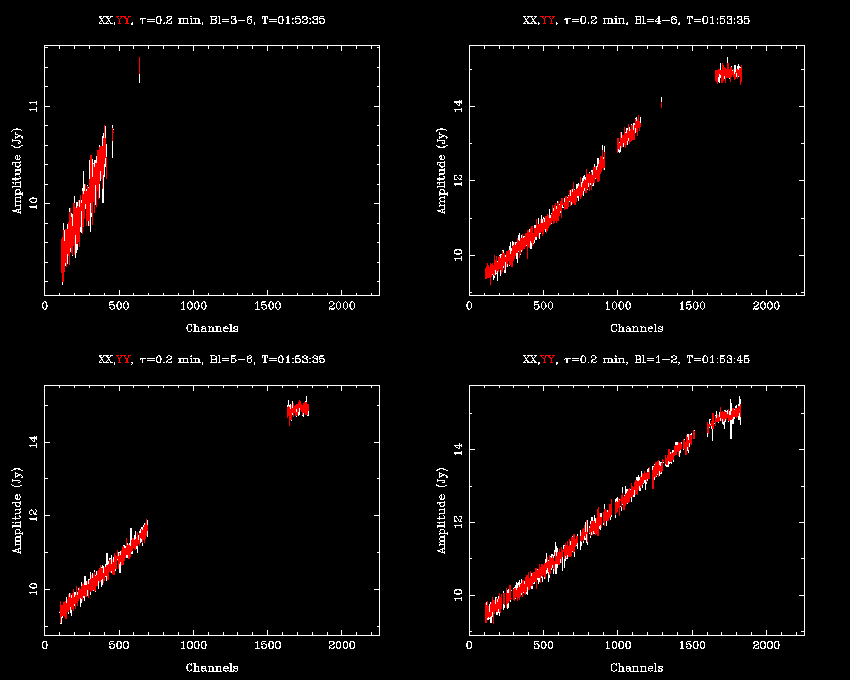

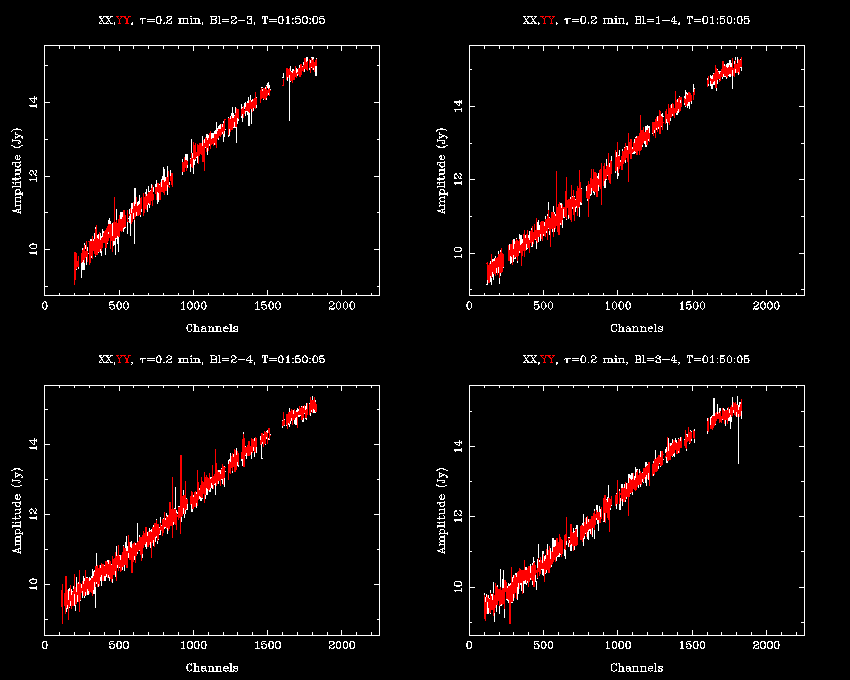

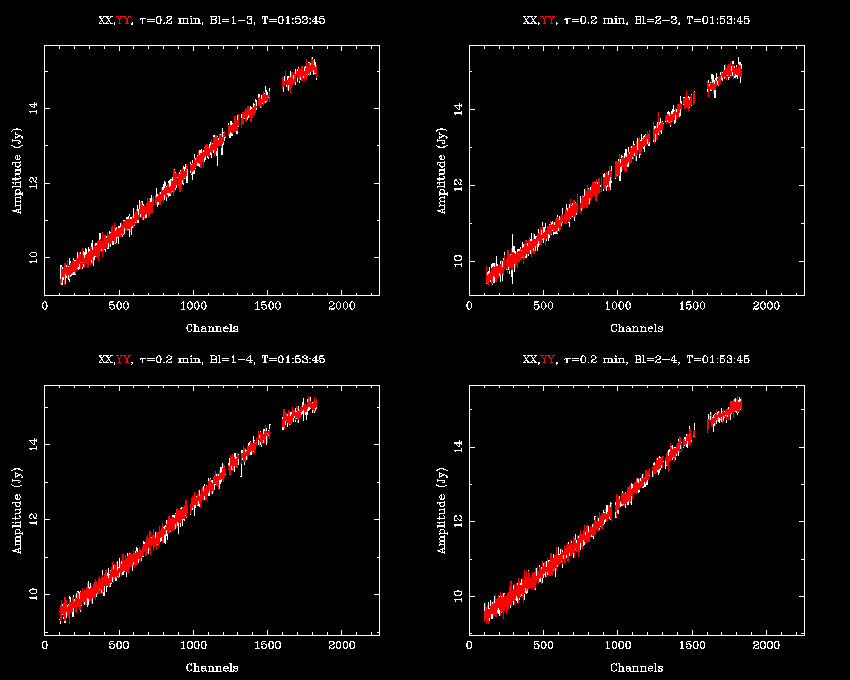

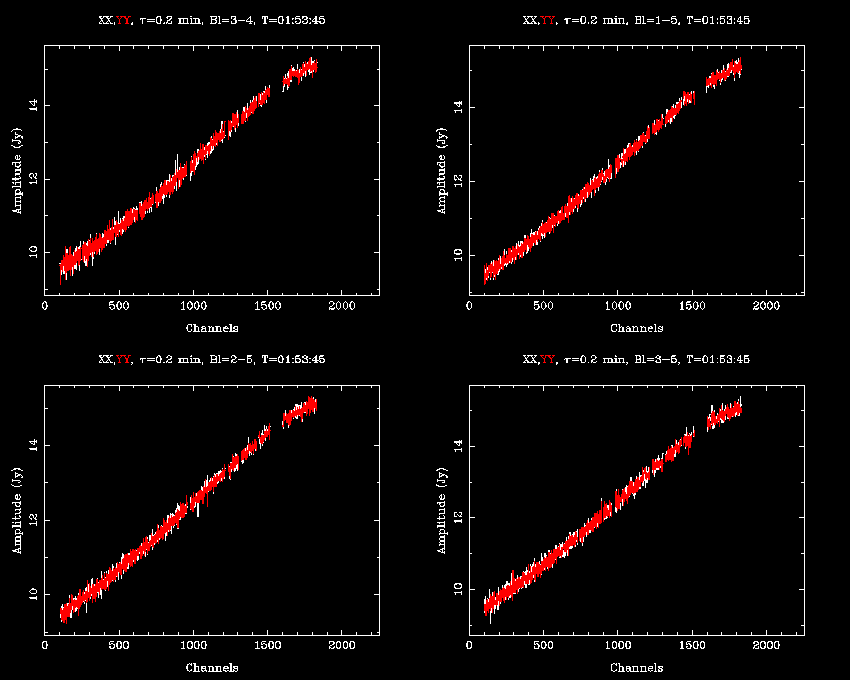

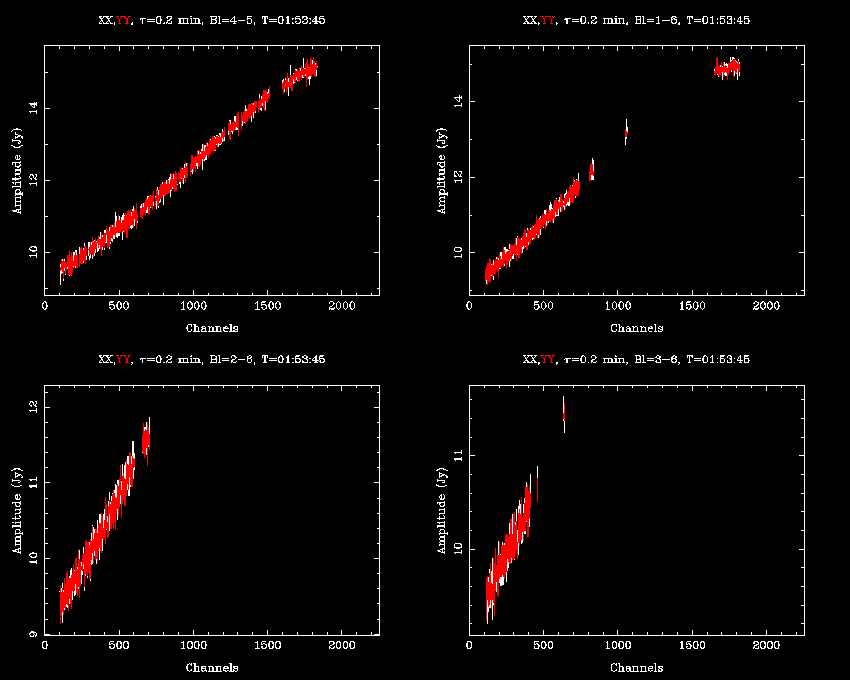

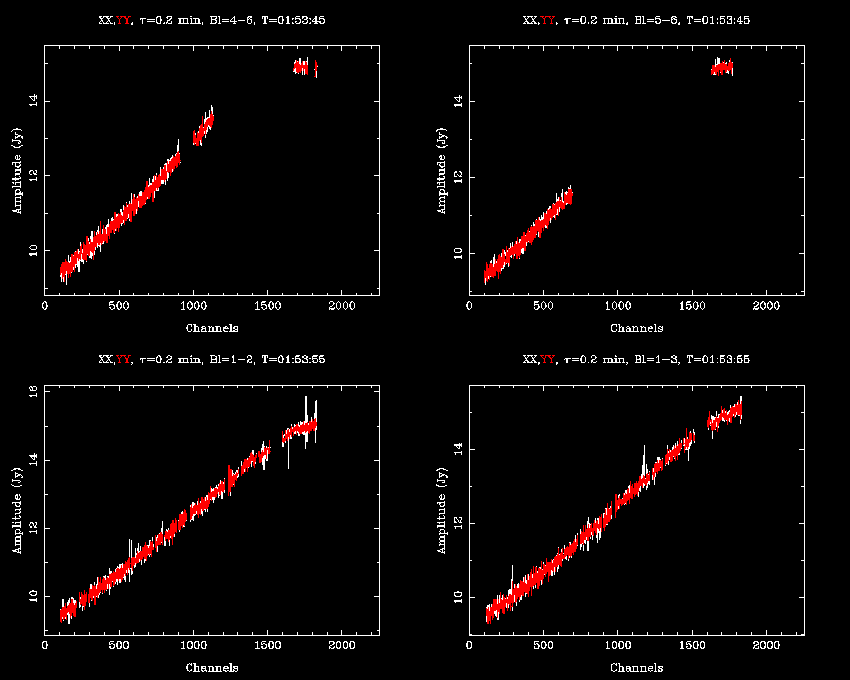

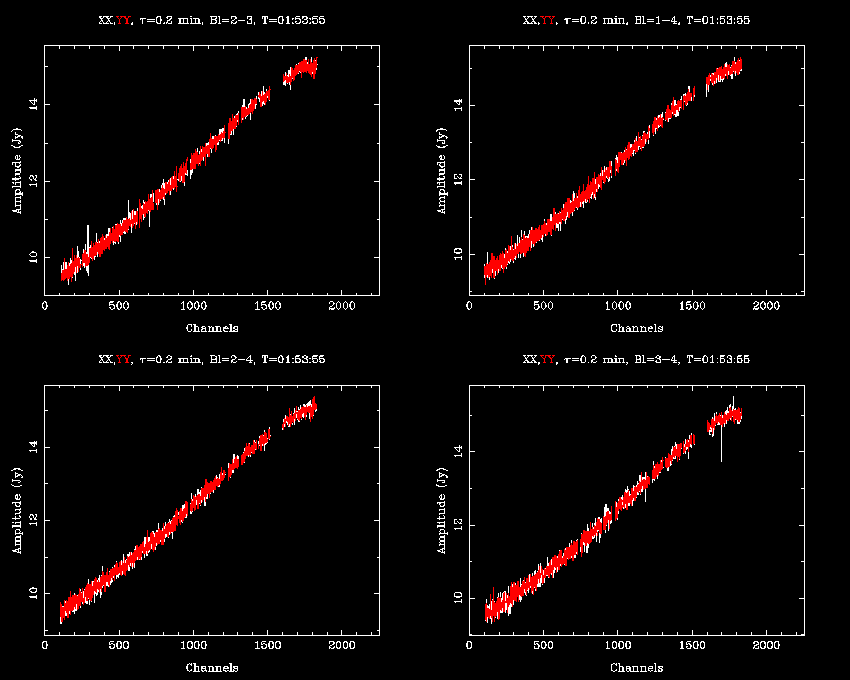

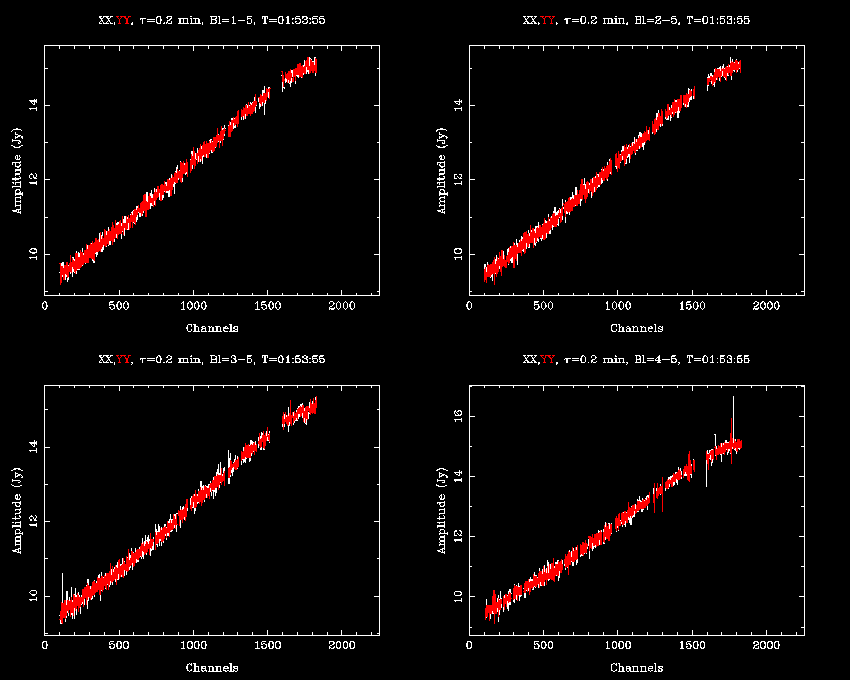

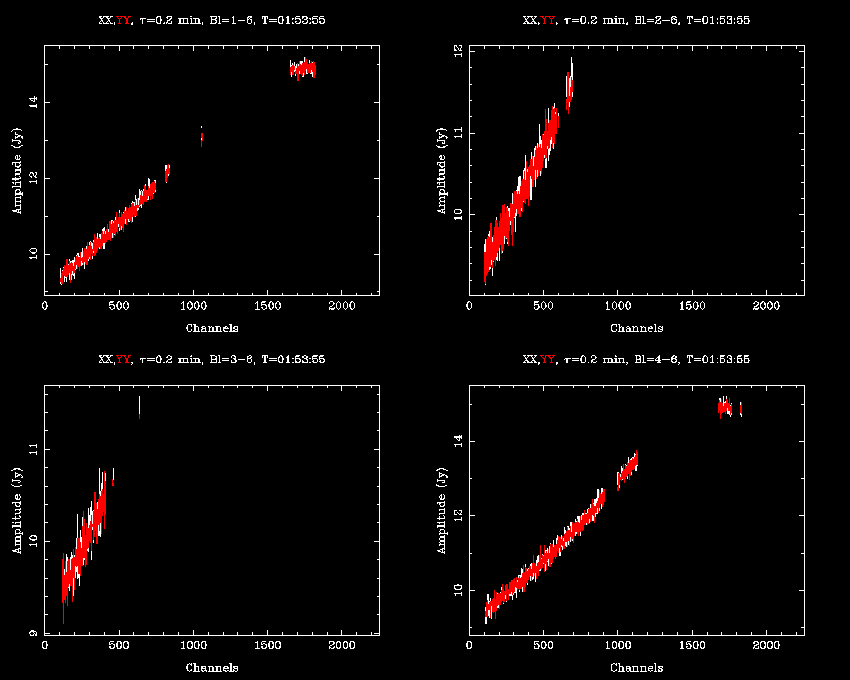

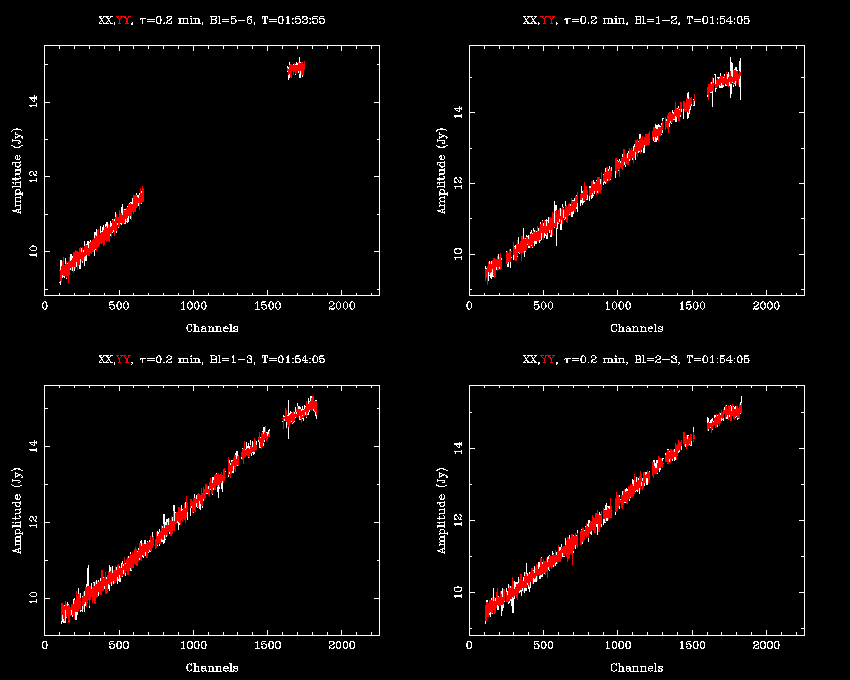

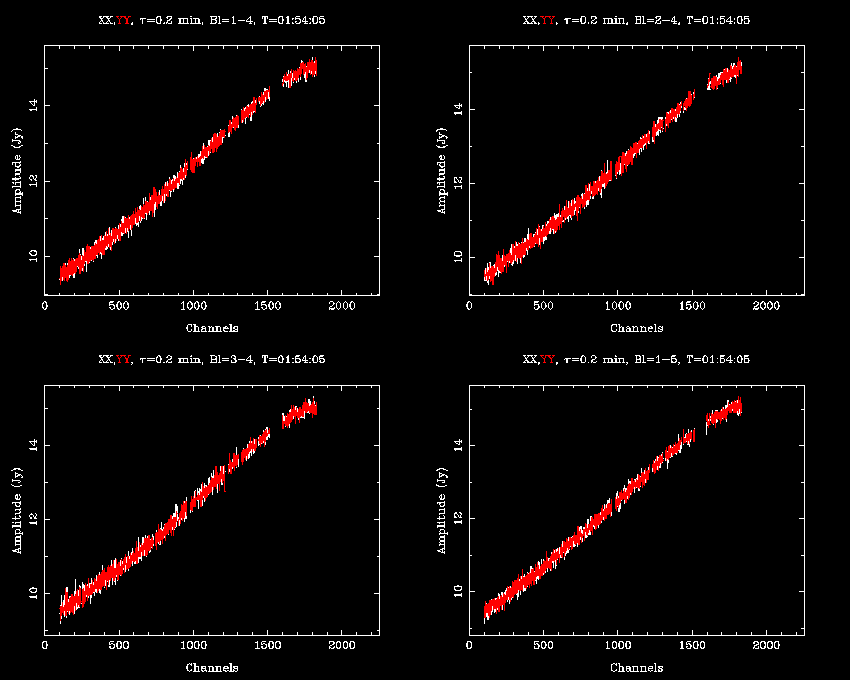

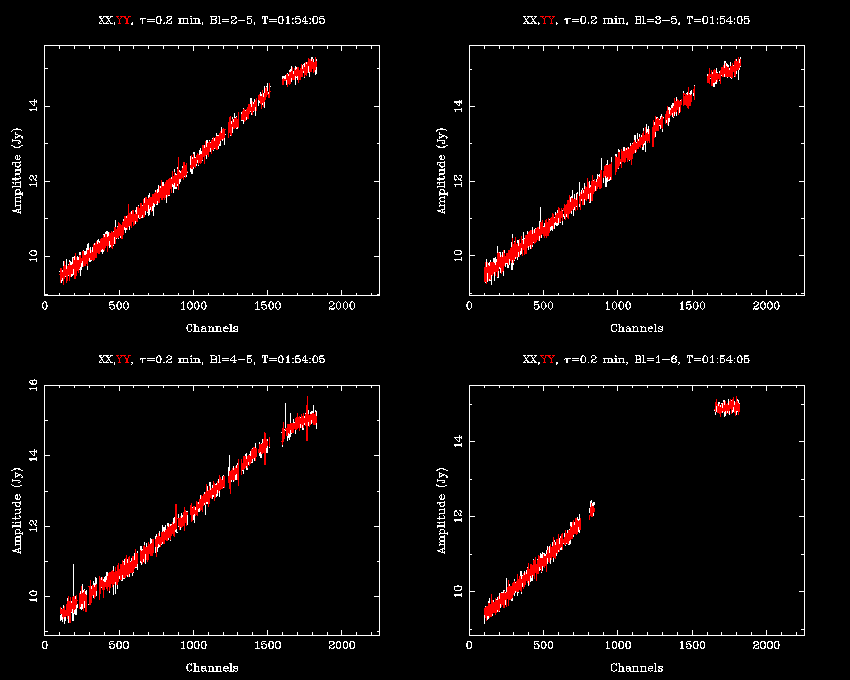

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'mfcal':  Correlations flagged or edge-rejected: 954524
  warnings.warn(msg)


MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $
Selecting parallel-hand polarisations
Reading the data ...
Number correlations accepted: 1196926
Number of frequency bands/settings: 1
Number of polarisations selected: 2
Number of solution intervals: 2
Number of passband solution intervals: 1
Initialising ...
Using post-Aug94 ATCA flux scale for 1934-638.
Using known frequency variation of 1934-638
Generating initial solution estimate ...
Doing solution refinement ...
Iter= 1, Solution Error:  0.678
Iter= 2, Solution Error:  0.028
Iter= 3, Solution Error:  0.001
Iter= 4, Solution Error:  0.000
Saving solution ...
##########Post mfcal bandpass, flux calibration##########


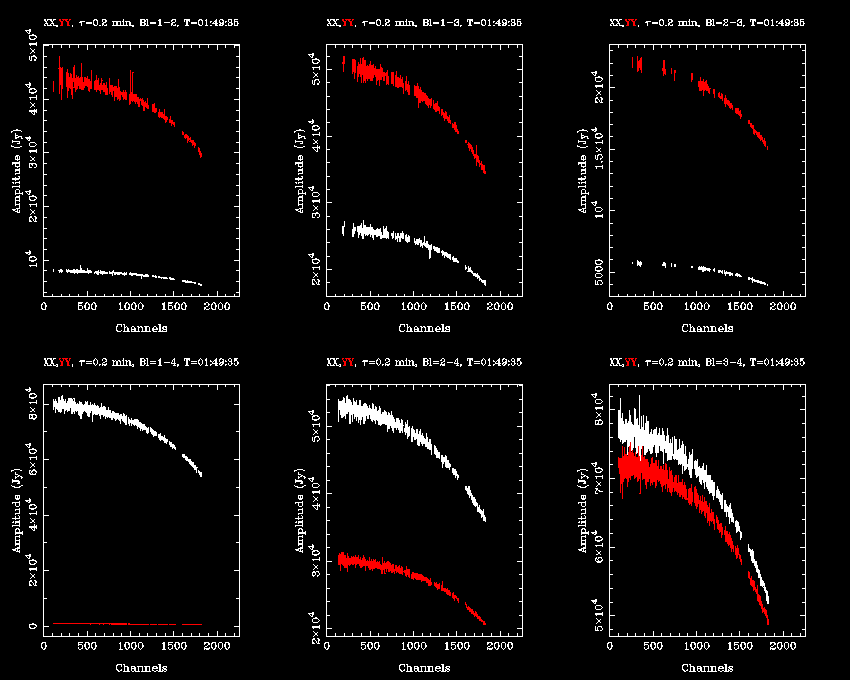

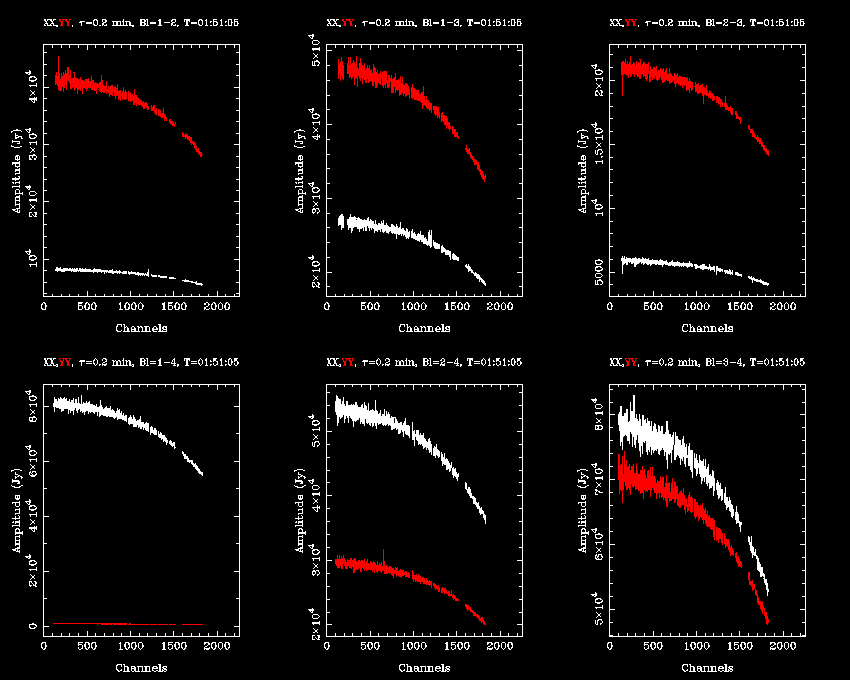

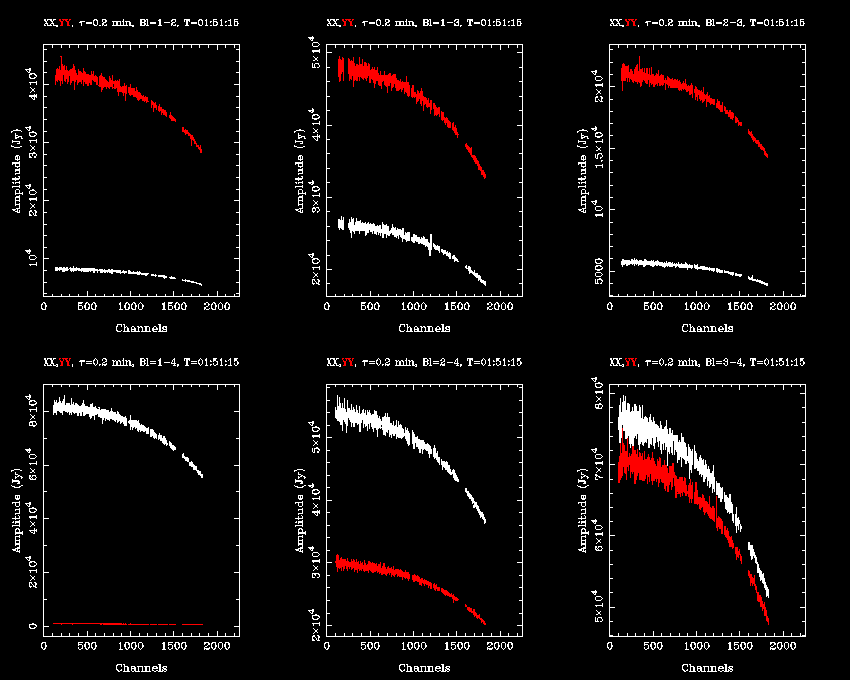

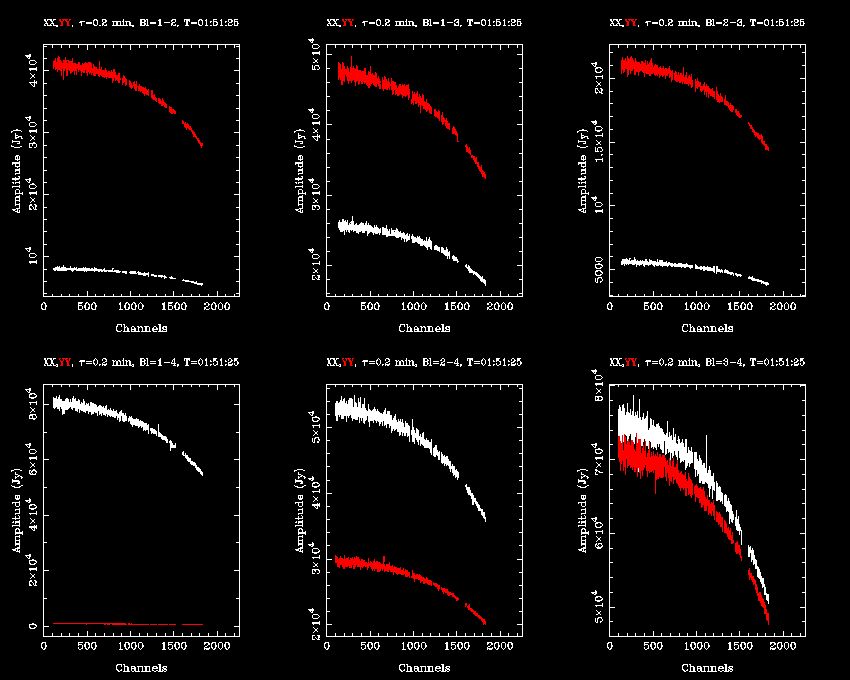

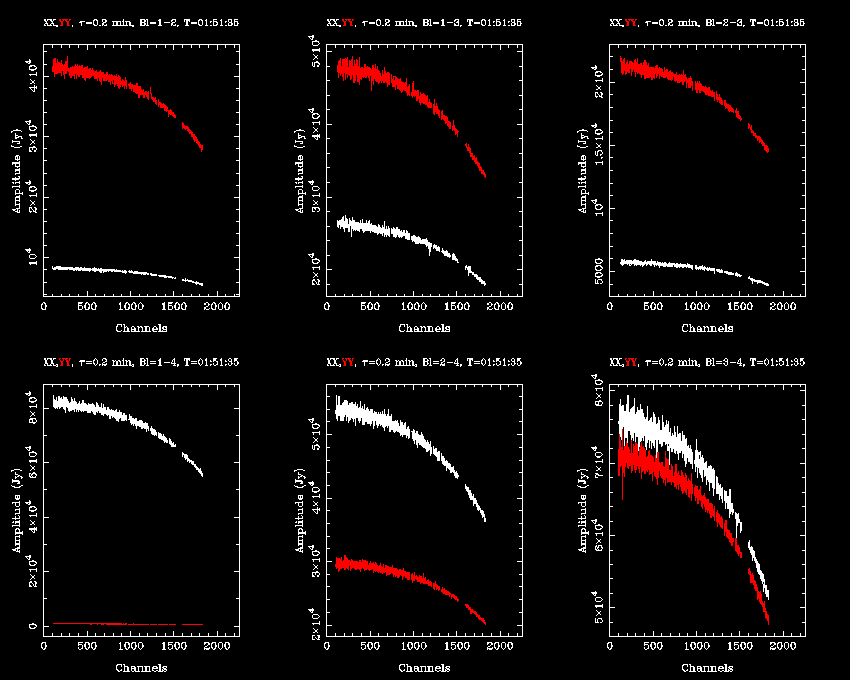

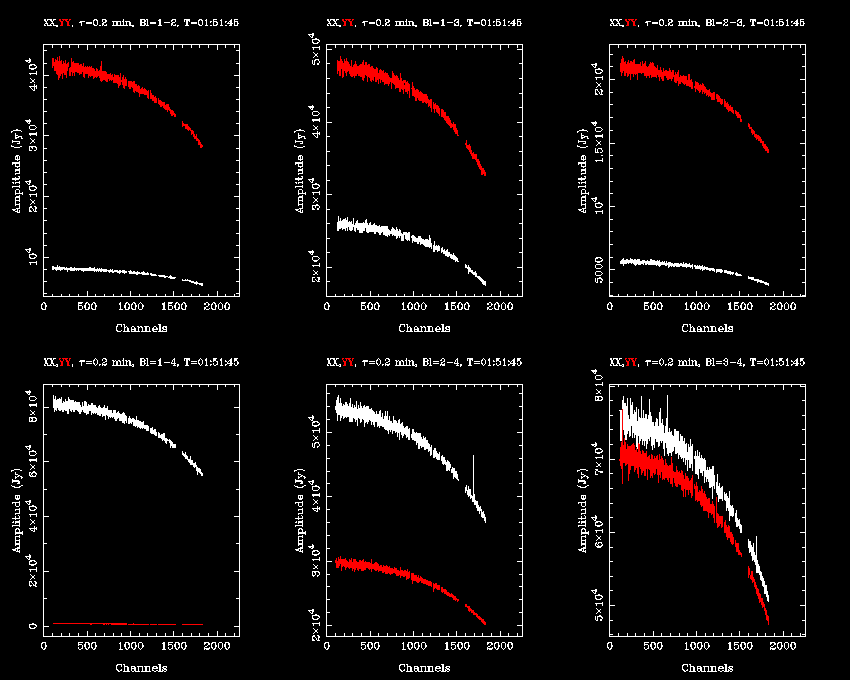

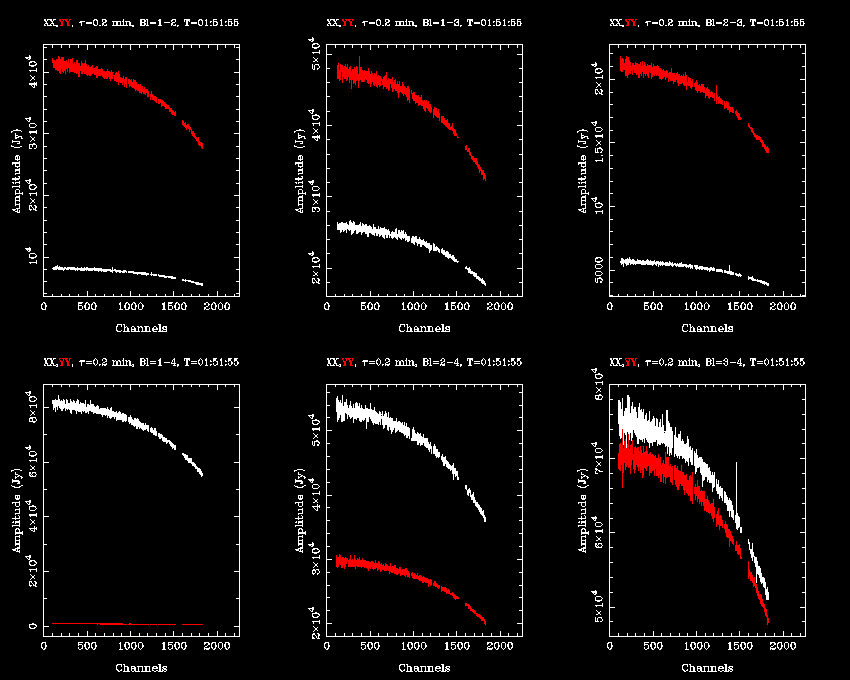

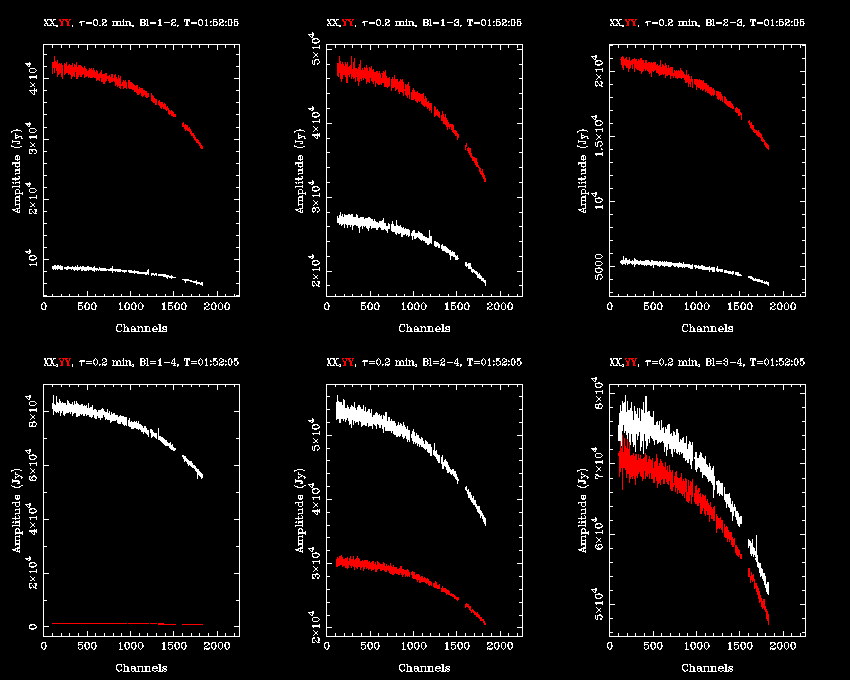

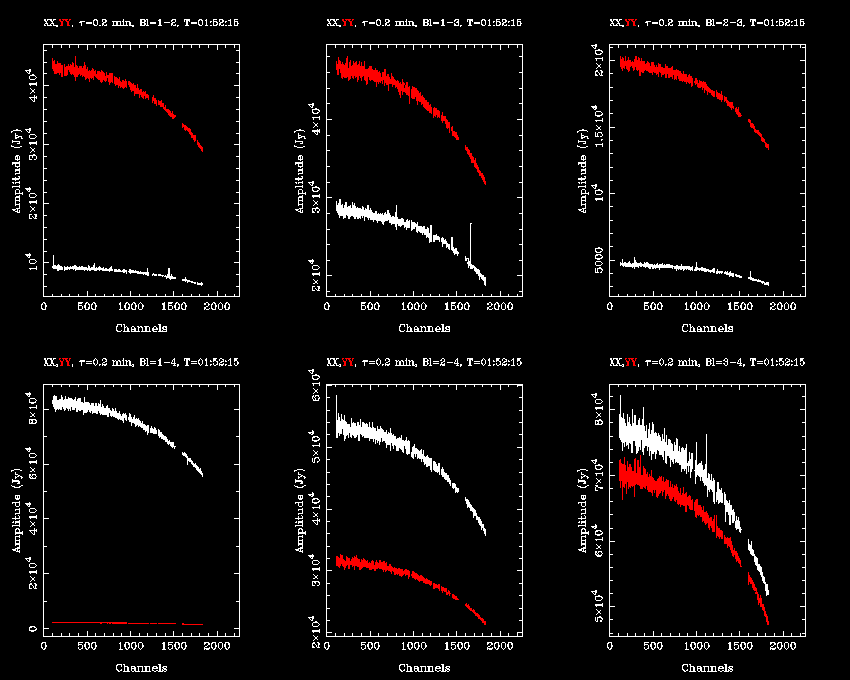

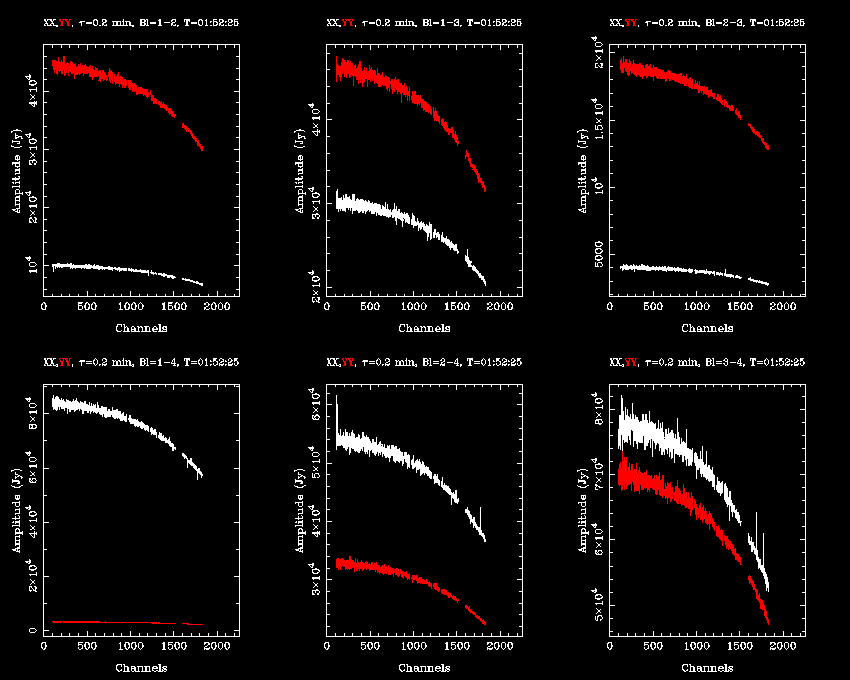

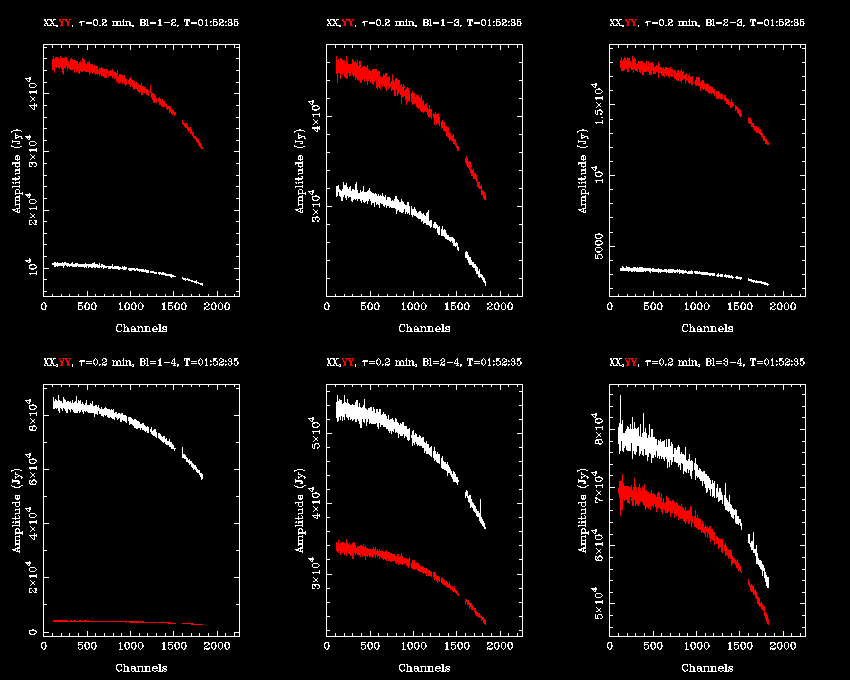

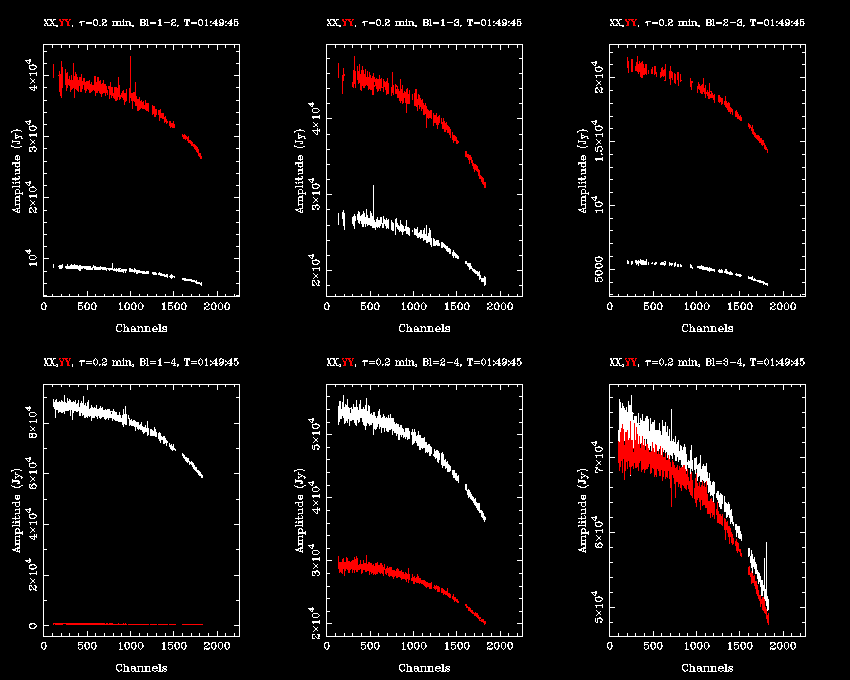

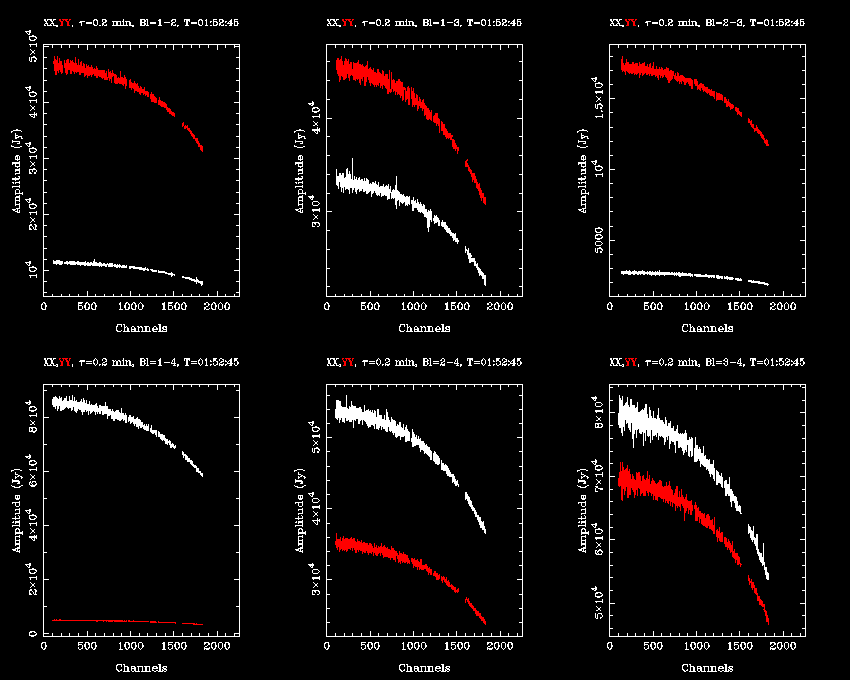

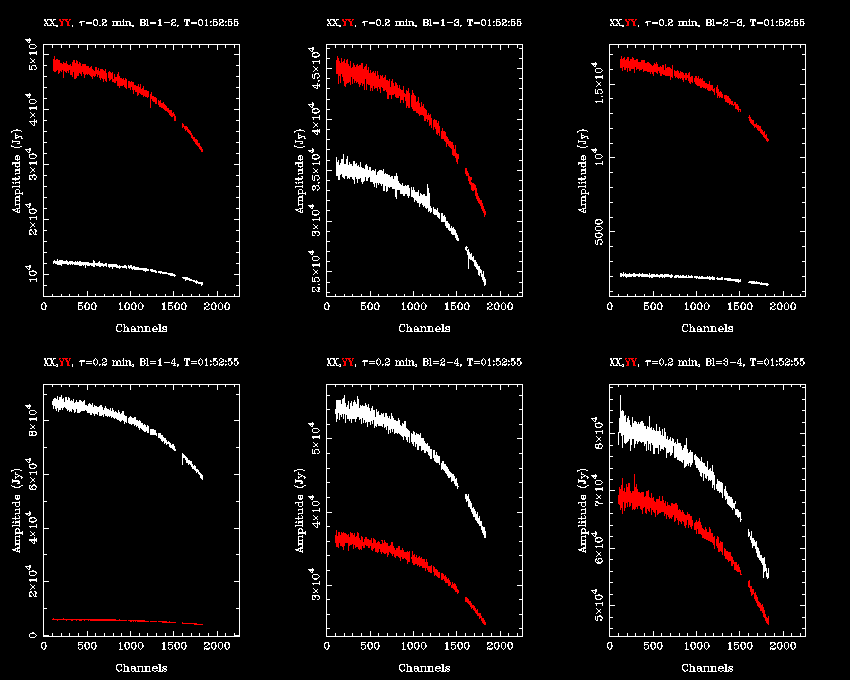

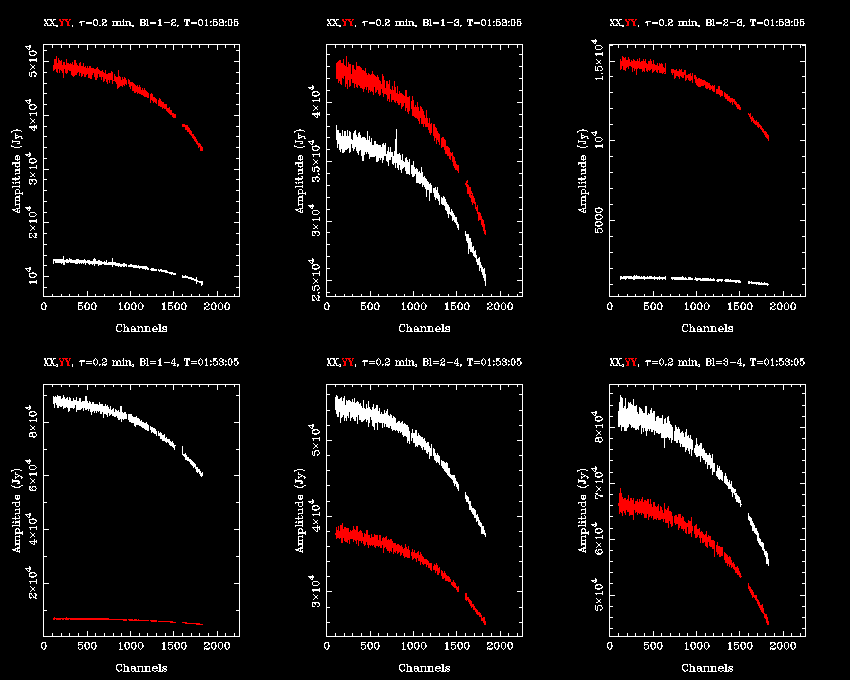

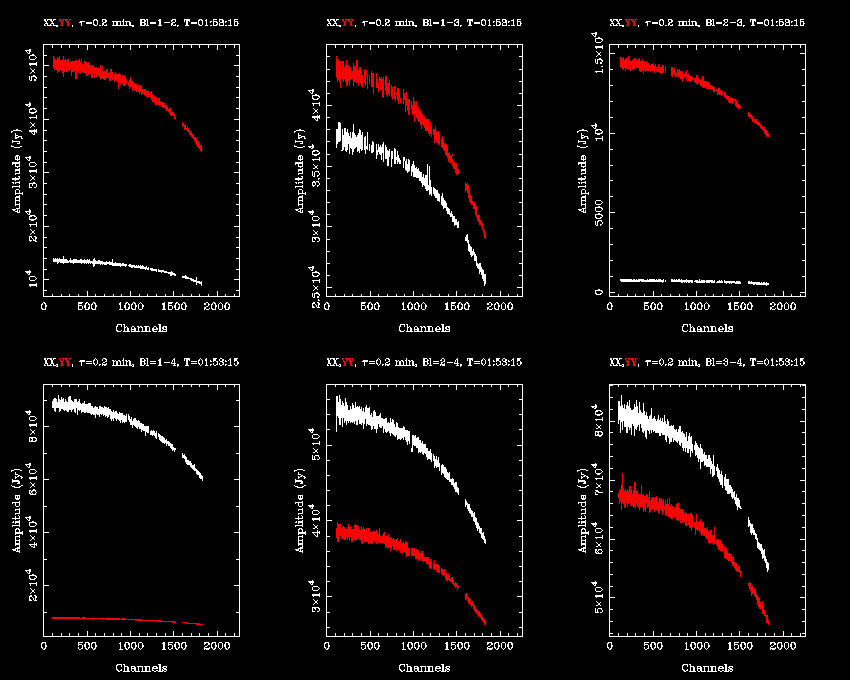

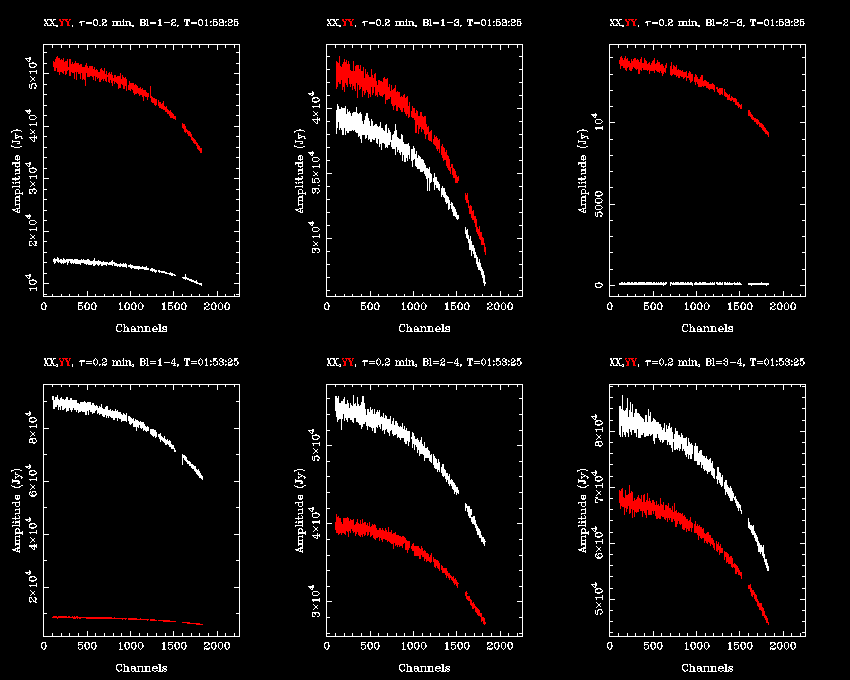

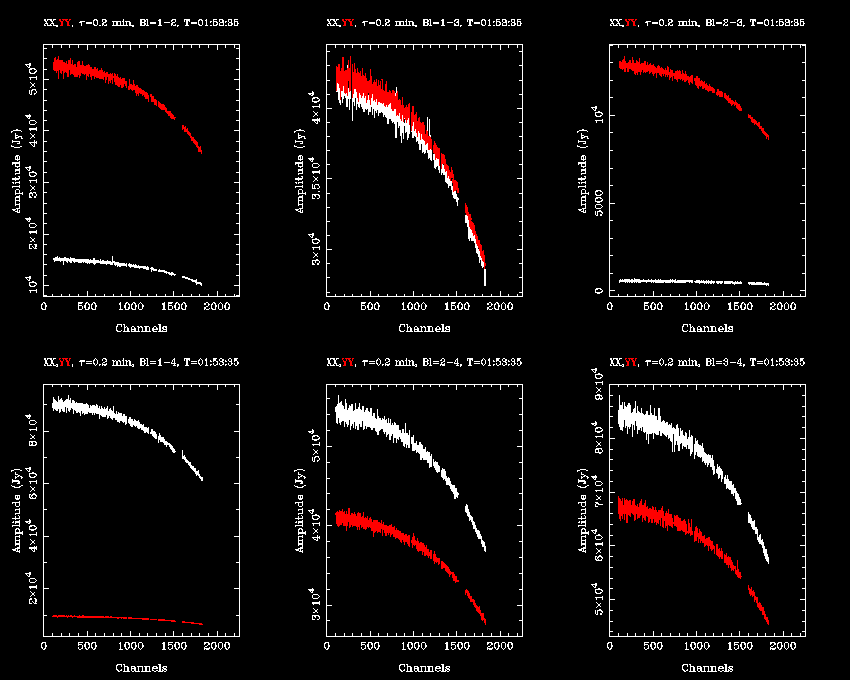

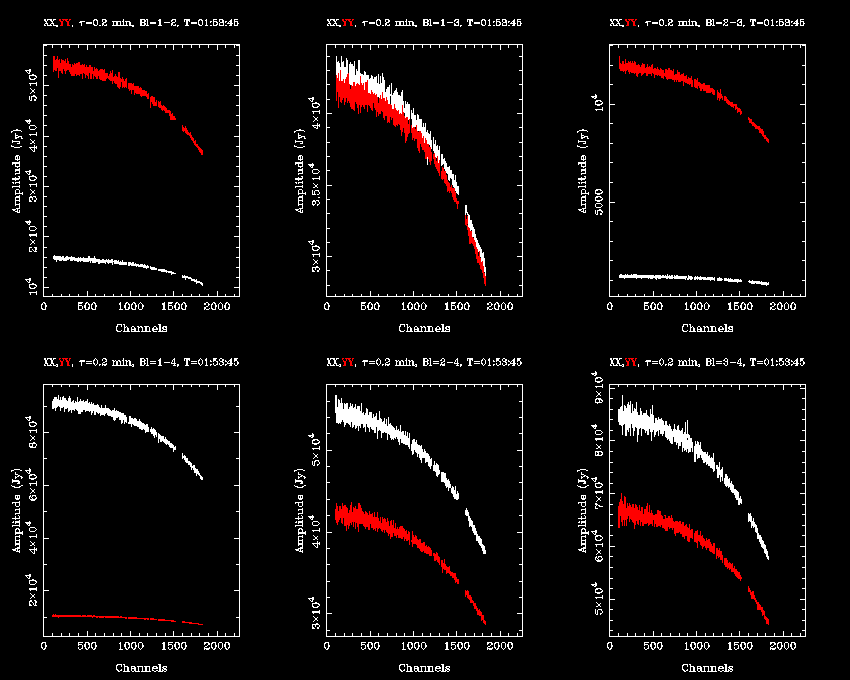

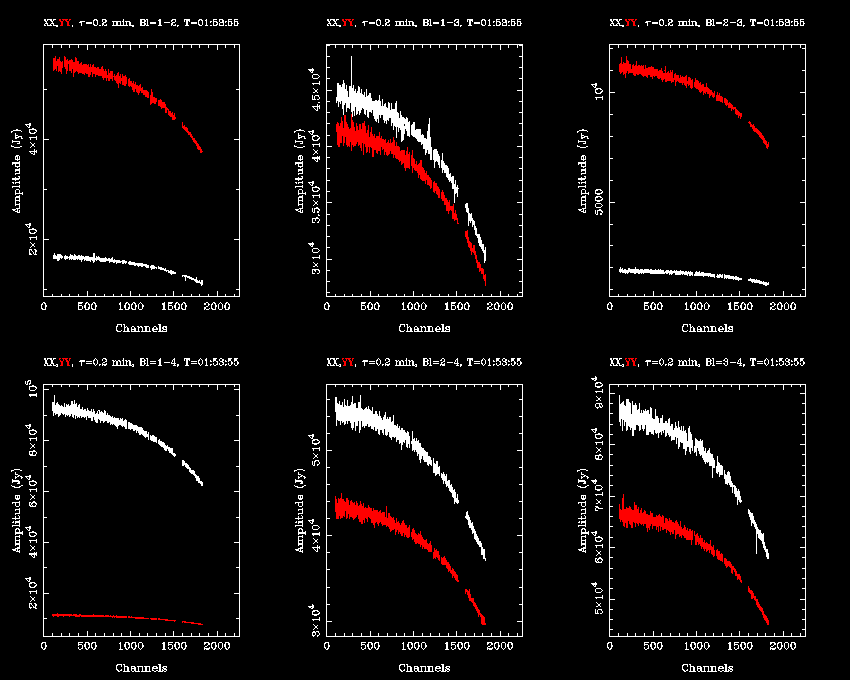

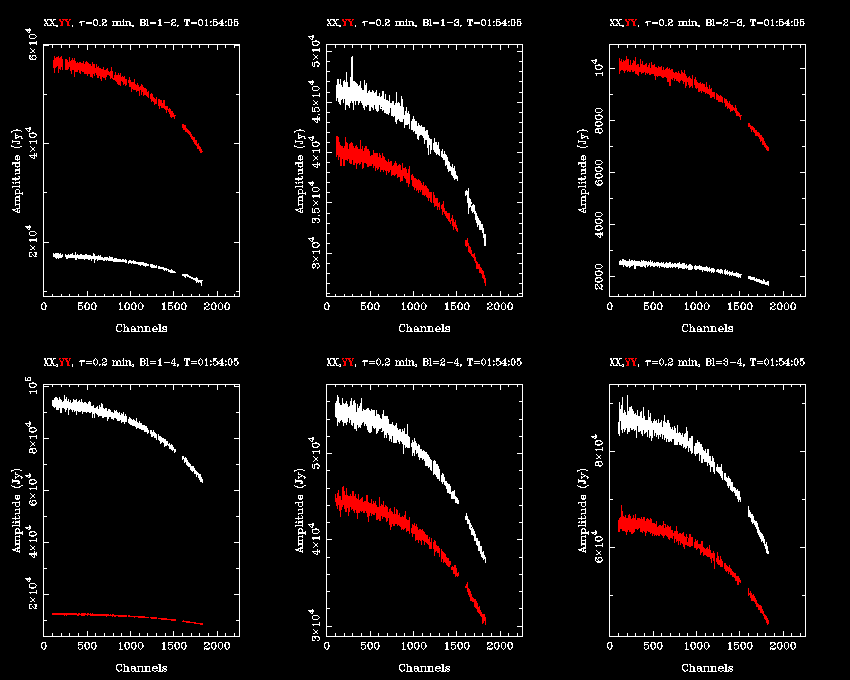

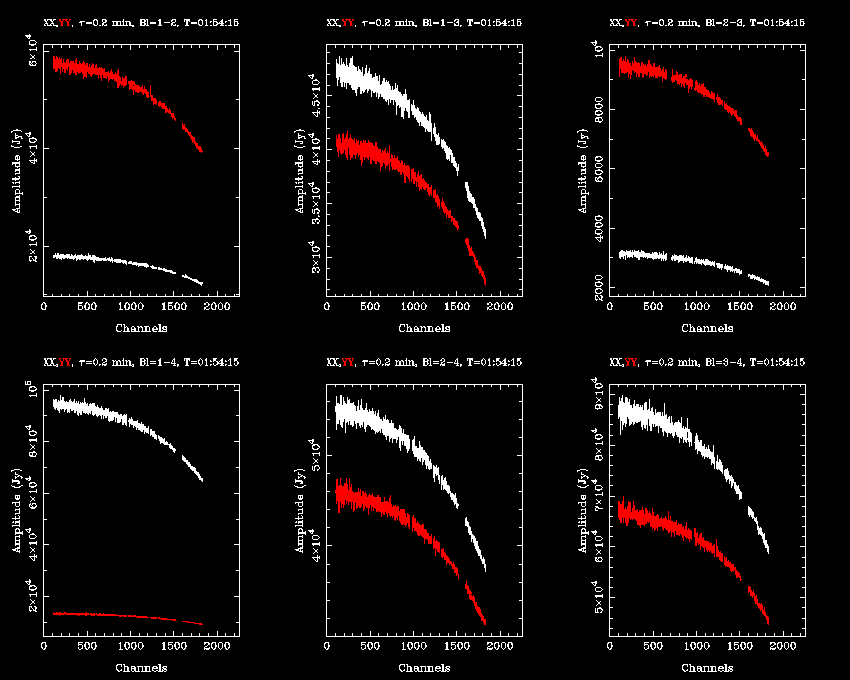

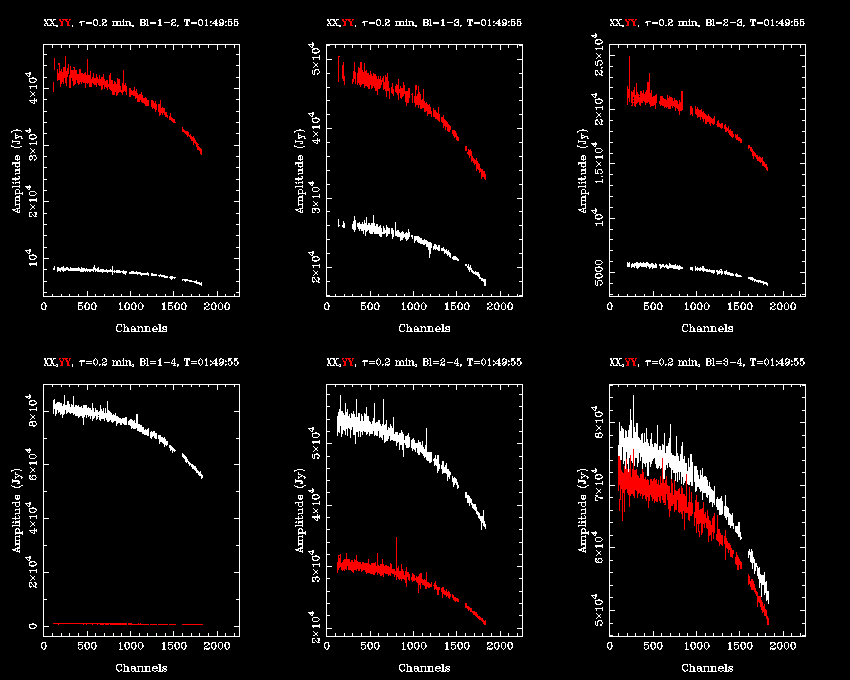

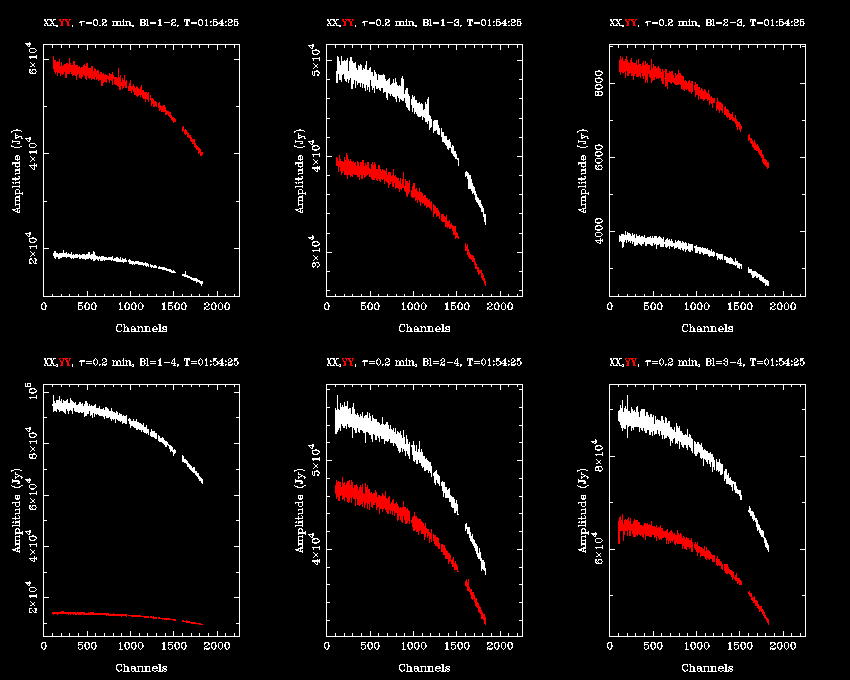

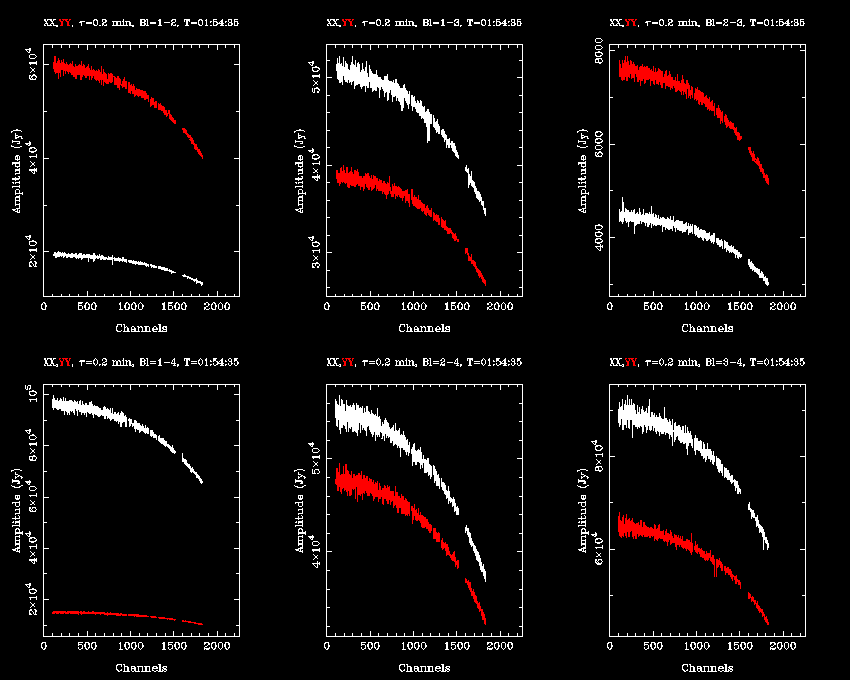

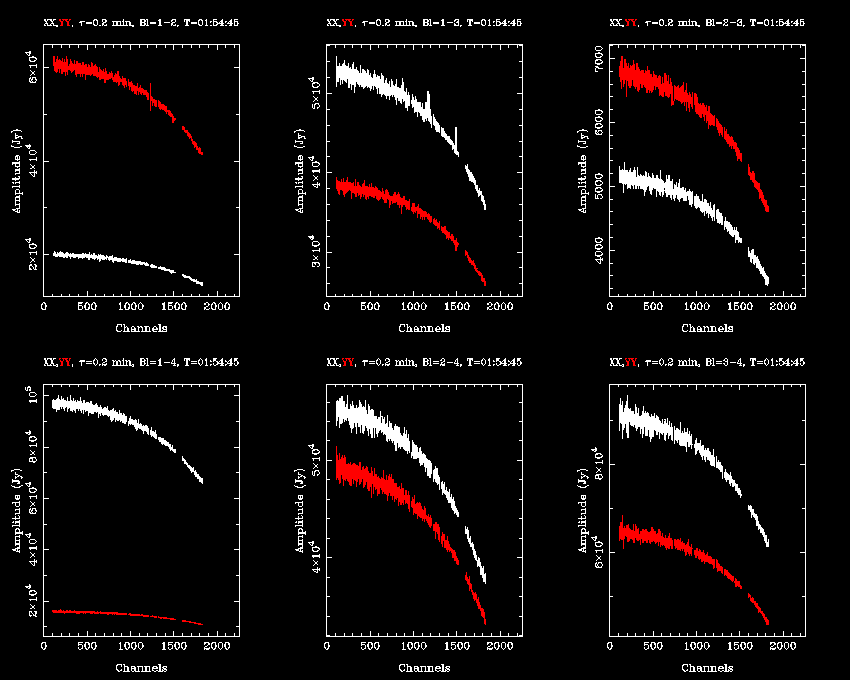

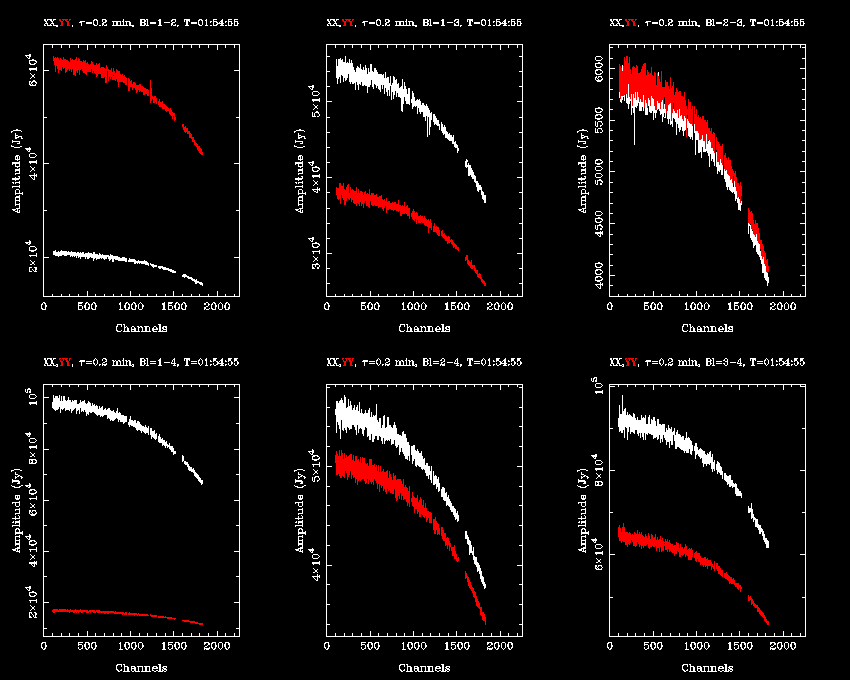

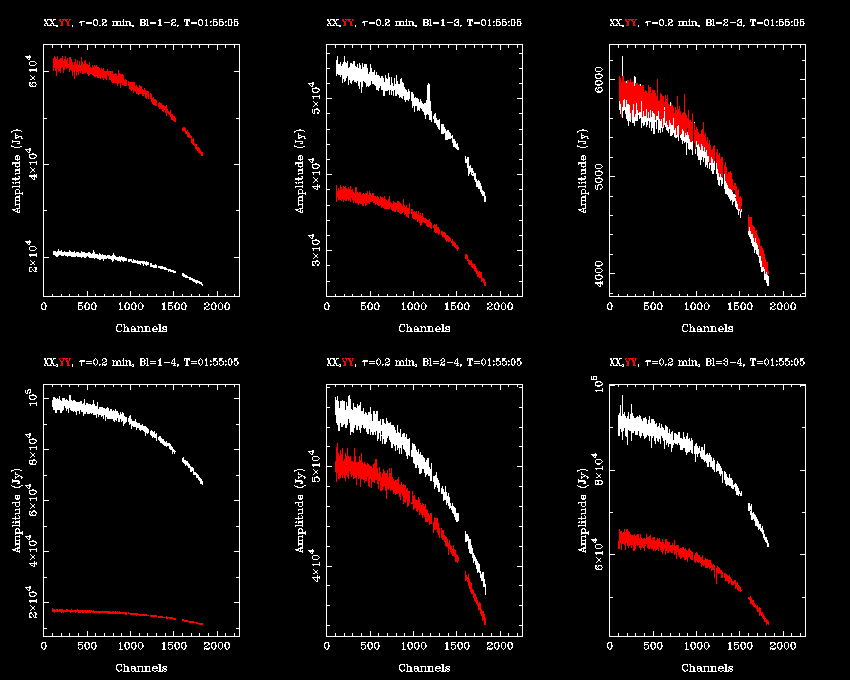

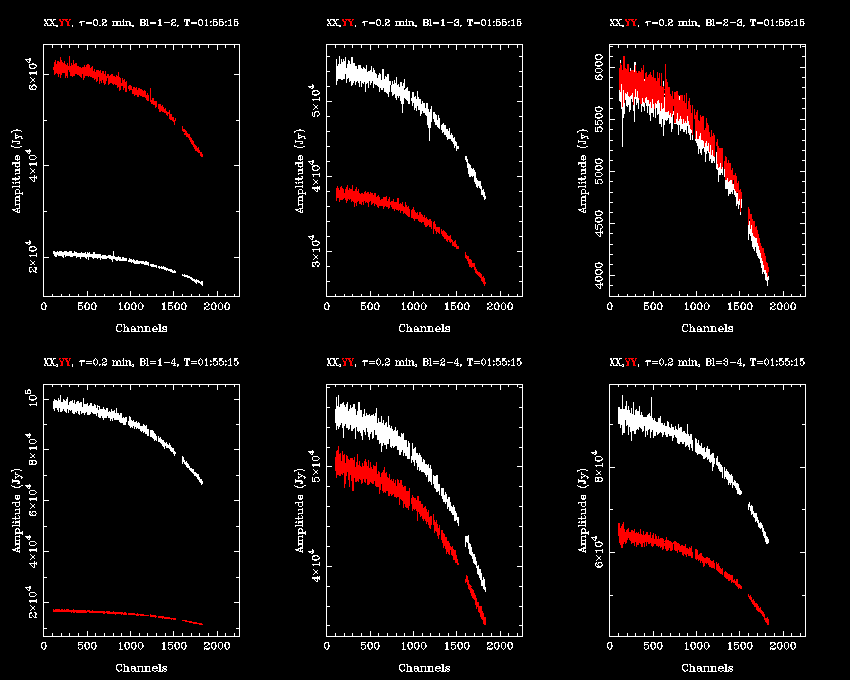

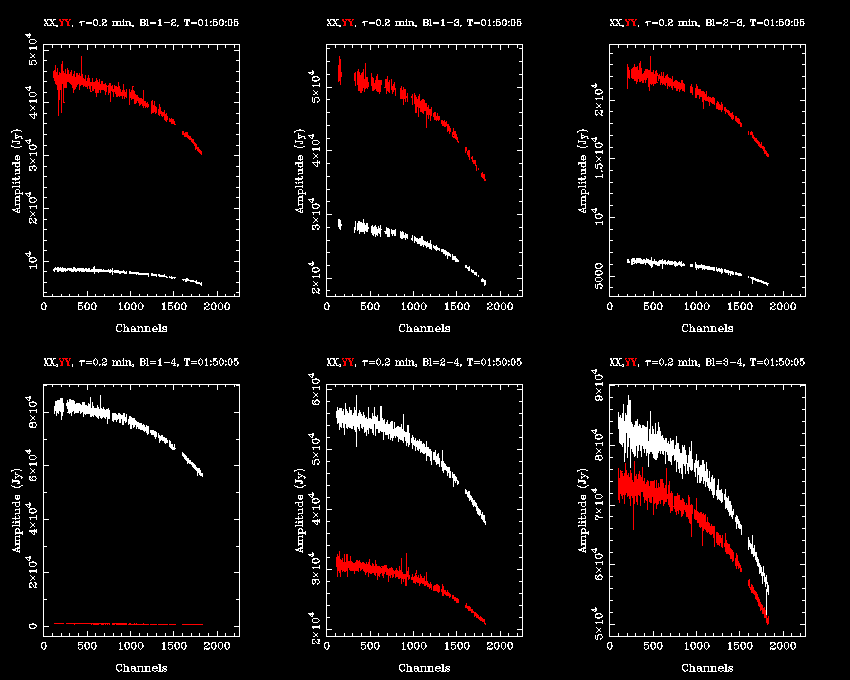

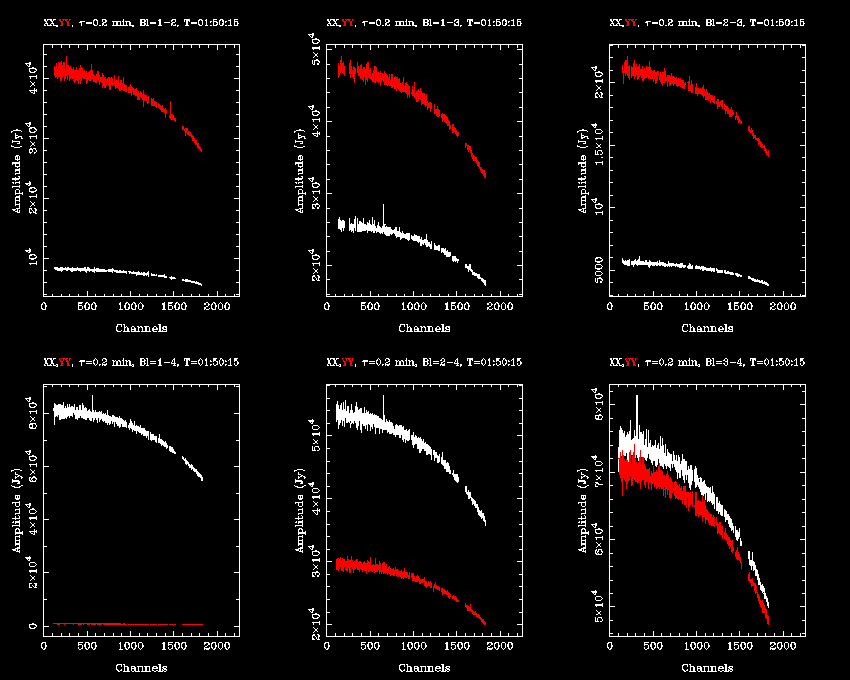

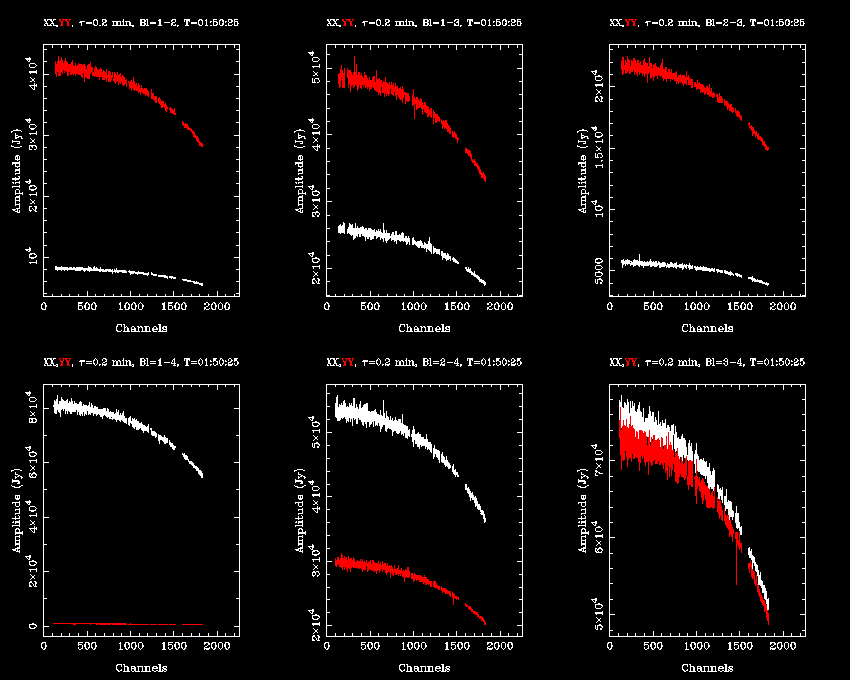

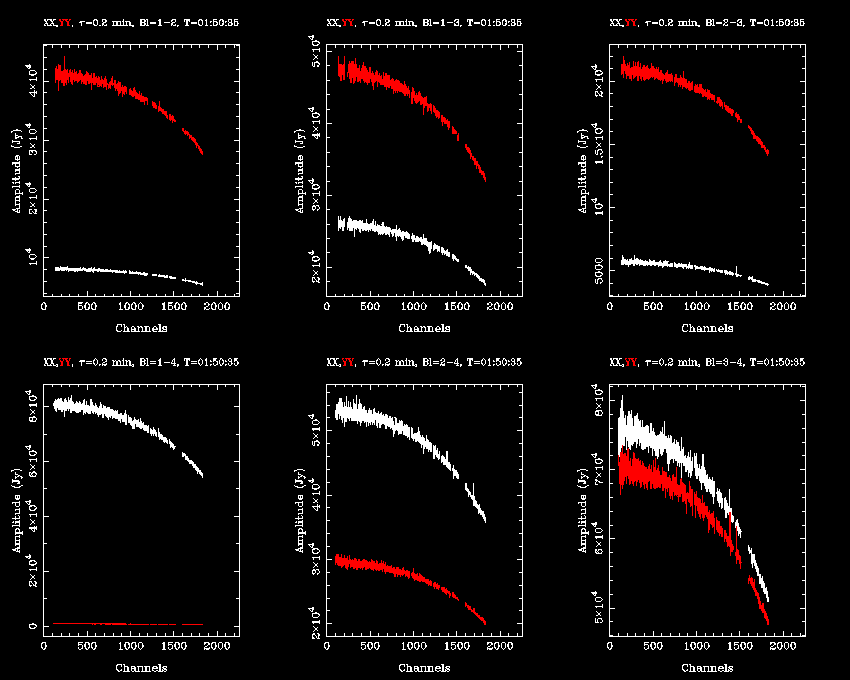

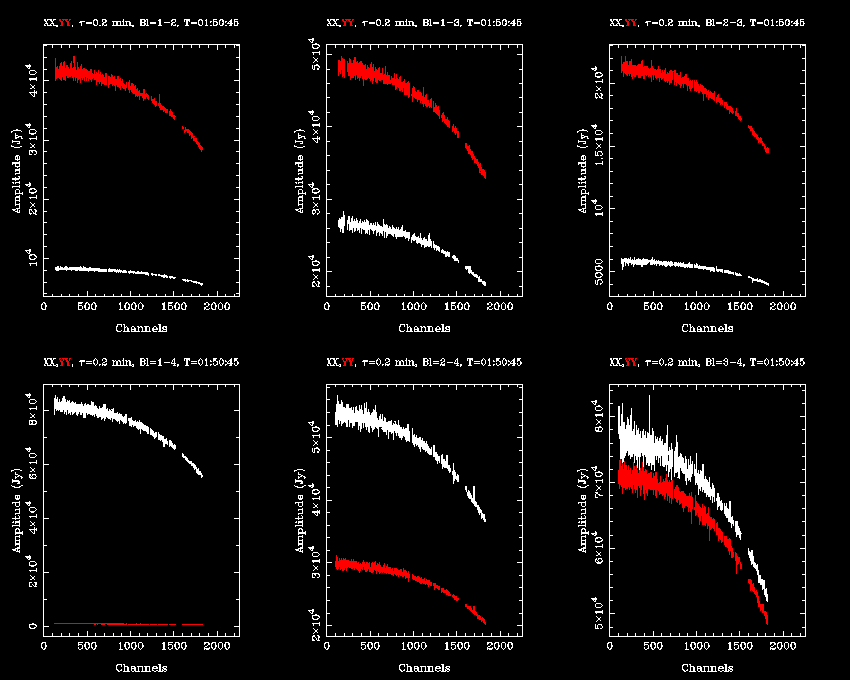

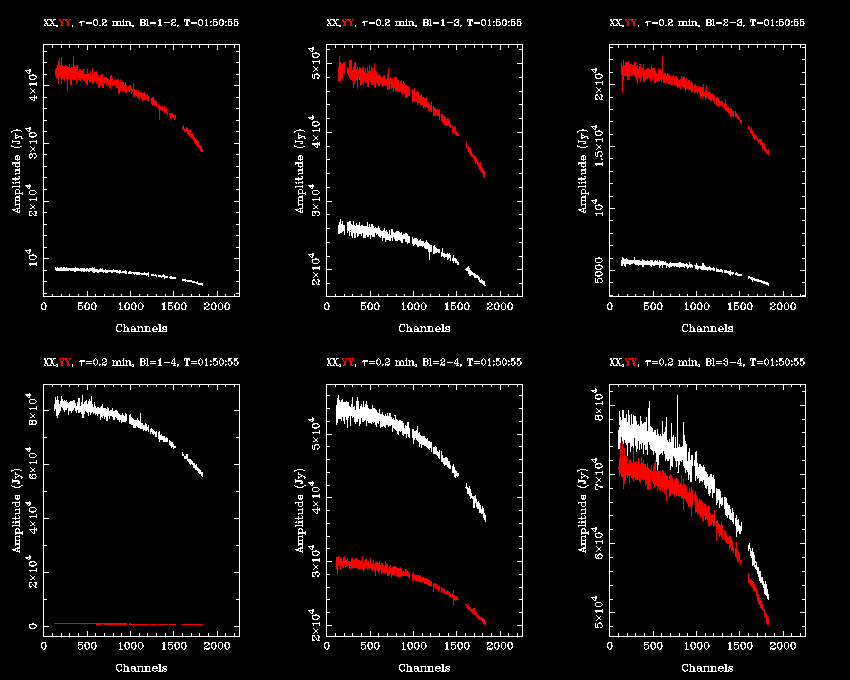

In [5]:

if source == bandflux_cal:
    # get an idea of what the data looks like before calibration
    if display_results:
        print('#'*10+"Pre mfcal bandpass, flux calibration"+'#'*10)

    # uvspec parameters
    vis = source
    stokes = "xx,yy"
    axis = "chan,amp"
    device="{0}_premfcal.png/png".format(vis)
    mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                                device=device)

    move_and_display_pngs(device,dir_name,log=None, display_results=display_results)

    # determine the bandpass shape

    # mfcal parameters
    vis = source
    refant=refant
    mir_output = miriad.mfcal(vis=vis,refant=refant)
    if display_results:
        print(mir_output.decode("utf-8"))

    # if you want to see what it looks like after mfcal
    if display_results:
        print('#'*10+"Post mfcal bandpass, flux calibration"+'#'*10)
    # uvspec parameters
    vis = source
    stokes = "xx,yy"
    axis = "chan,amp"
    device="{0}_postmfcal.png/png".format(vis)
    mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                                device=device)

    move_and_display_pngs(device,dir_name,log=None, display_results=display_results)


else:   

    # copy over the calibration solution

    # gpcopy parameters
    vis = phasecal_df.loc[h]["phasecal"]
    out = source
    mir_output = miriad.gpcopy(vis=vis,out=out)
    if display_results:
        print(mir_output.decode("utf-8"))







# Source Calibration

## Pre RFI Flagging

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC                         3";
Applying bandpass corrections to 1934-638.2100
Applying freq. dependent gain corrections to 1934-638.2100
Applying freq. dependent leakage correction to 1934-638.2100
Source: 1934-638
Stokes I
Vector Average Amplitude:   7.504E+01         Phase:   3.946E+01
             Uncertainty:   6.359E+04
Scalar Average Amplitude:   2.828E+04   Uncertainty:   4.445E+04
--------------------------------------------------------------------------------


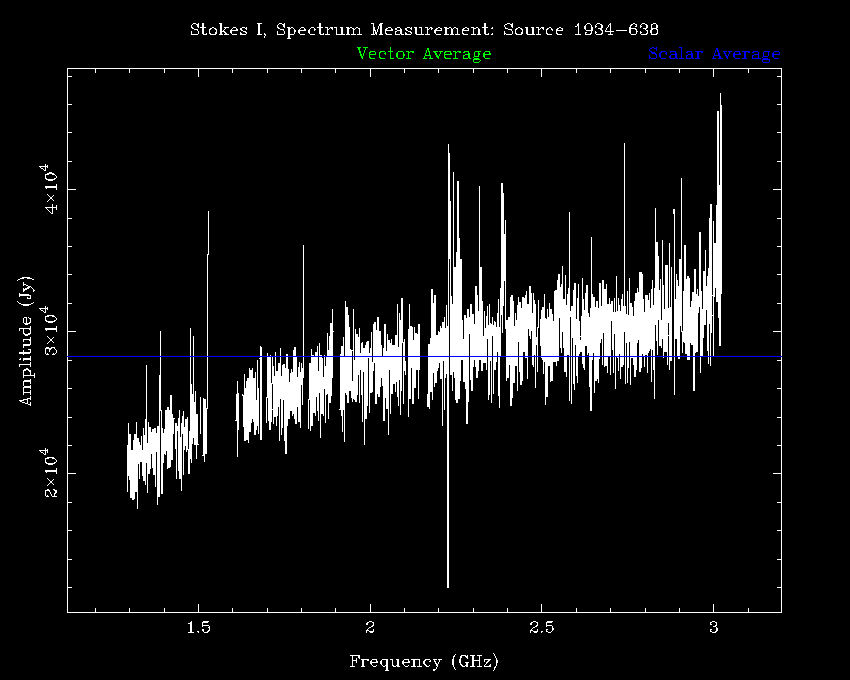

In [6]:
# uvfmeas!
vis= source
stokes ='i'
line = 'channel,2048,1,1,1'
log = 'precaluvfmeaslog{0}MHz_{1}'.format(line.split(',')[-2],source)
device="{0}_precaluvmeas.png/png".format(source)
feval="2.1"

mir_output = miriad.uvfmeas(vis=vis,stokes=stokes,device=device,line=line,
                            feval=feval,log=log)


# put it in notebook dir
im_to_save = "{0}_precaluvmeas.png".format(source)
shutil.copy(im_to_save, image_dir)

if display_results:
    print(mir_output.decode("utf-8", errors='replace'))

move_and_display_pngs(device,dir_name,log, display_results=display_results)




## RFI Flagging

In [7]:

#################### RFI FLAGGING #####################


# do this 2 or 3 times
if source == bandflux_cal:
    loop = [0,1,2]
else:
    loop = [0,1]

for l in loop: 

    # RFI FLAGGING

    # loop over stokes
    stokes_arr = ['xx','xy','yx','yy']

    for u in stokes_arr:
        # pgflag parameters
        vis = source
        stokes = str(u)+','+','.join(stokes_arr)
        command = "<b"
        device="/xs" 
        options="nodisp"
        mir_output = miriad.pgflag(vis=vis,stokes=stokes,command=command,
                            options=options, device=device)
        flagging_check = flaggingcheck_pgflag(mir_output)
        
        # add flagging_check[0] to df
        if display_results:
            print(mir_output.decode("utf-8", errors="replace"))


    if manual_flagging:
        # blflag parameters
        vis = source
        device="/xs" 
        stokes = "xx,yy"
        axis = "chan,amp"
        options="nofqav,nobase,selgen"
        mir_output = miriad.blflag(vis=vis,device=device,stokes=stokes,
                                   axis=axis,options=options)
        if display_results:
            print(mir_output.decode("utf-8", errors="replace"))

        

        # save flagging log
        log = dir_name+"/blflag.select{0}".format(l)
        try:
            shutil.move('blflag.select', log)
        except:
            pass


for i in (phasecal_df[phasecal_df["name"] == phasecal_df.loc[h]["name"]].index.values):    
    phasecal_df.set_value(i, 'percent_flagged', flagging_check[0])    

pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1934-638.2100
Applying freq. dependent gain corrections to 1934-638.2100
Applying freq. dependent leakage correction to 1934-638.2100
Applying changes to dataset
Counts of correlations within selected channels:
 channel  Originally  Currently
 Good:       2393852    2365556    Changed to bad:      28296
 Bad:        1909048    1937344    Changed to good:         0
 45.0% of the data is now flagged
pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1934-638.2100
Applying freq. dependent gain corrections to 1934-638.2100
Applying freq. dependent leakage correction to 1934-638.2100
Applying changes to dataset
Counts of correlations within selected channels:
 channel  Originally  Currently
 Good:       2365556    2346248    Changed to bad:      19308
 Bad:        1937344    1956652    Changed to good:         0
 45.5% of the data is now flagged
pgflag: Revision 1.30, 2016/10/05 23

## Post RFI Flagging

##########Post blflag source##########
UvSpec: version 1.0 21-Apr-10
Applying bandpass corrections to 1934-638.2100
Applying freq. dependent gain corrections to 1934-638.2100
Applying freq. dependent leakage correction to 1934-638.2100


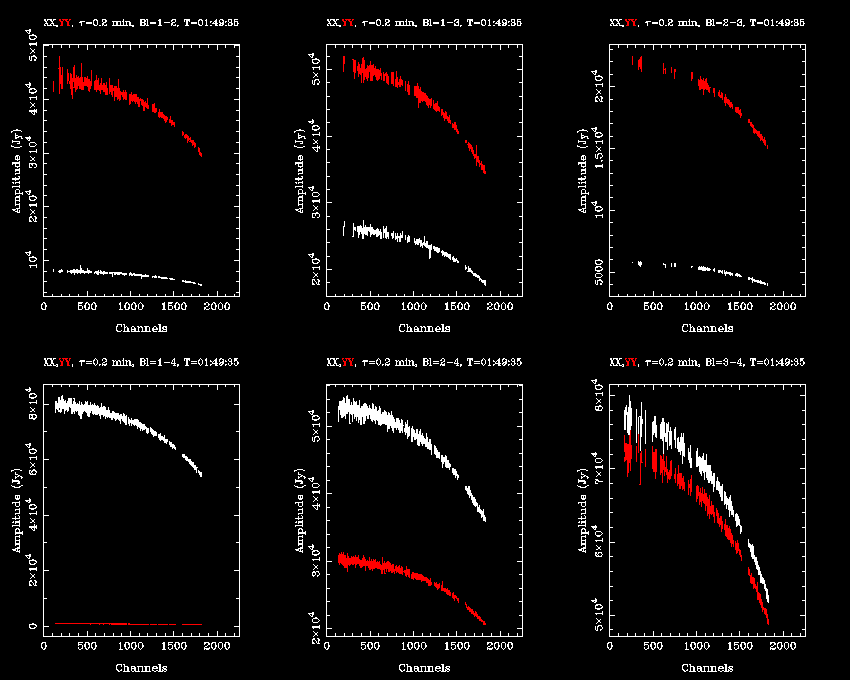

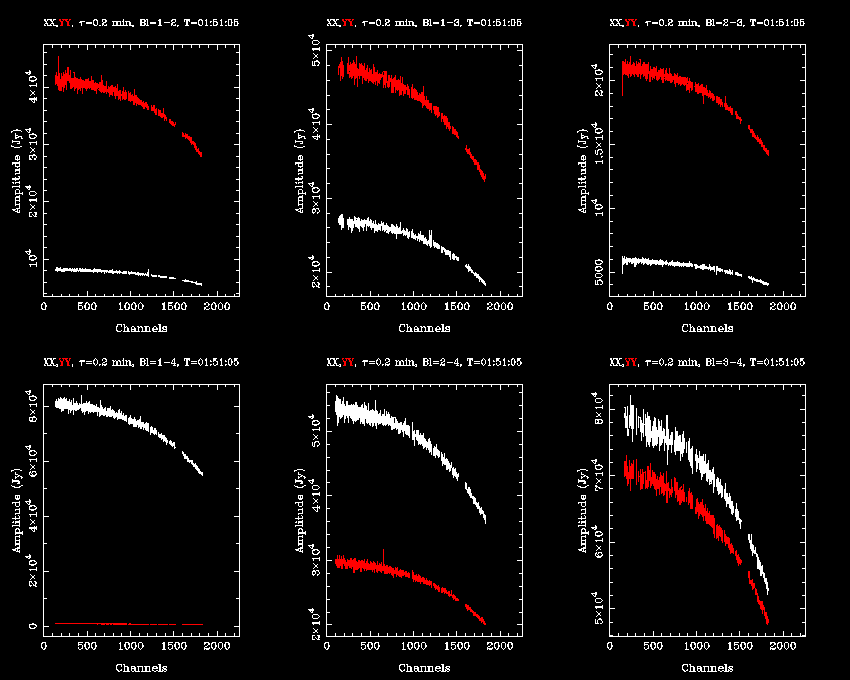

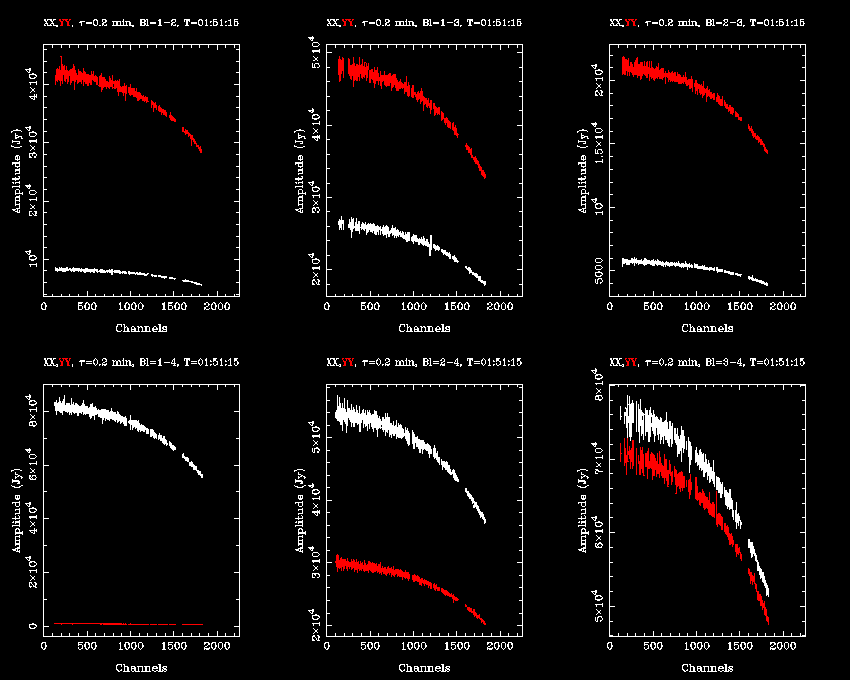

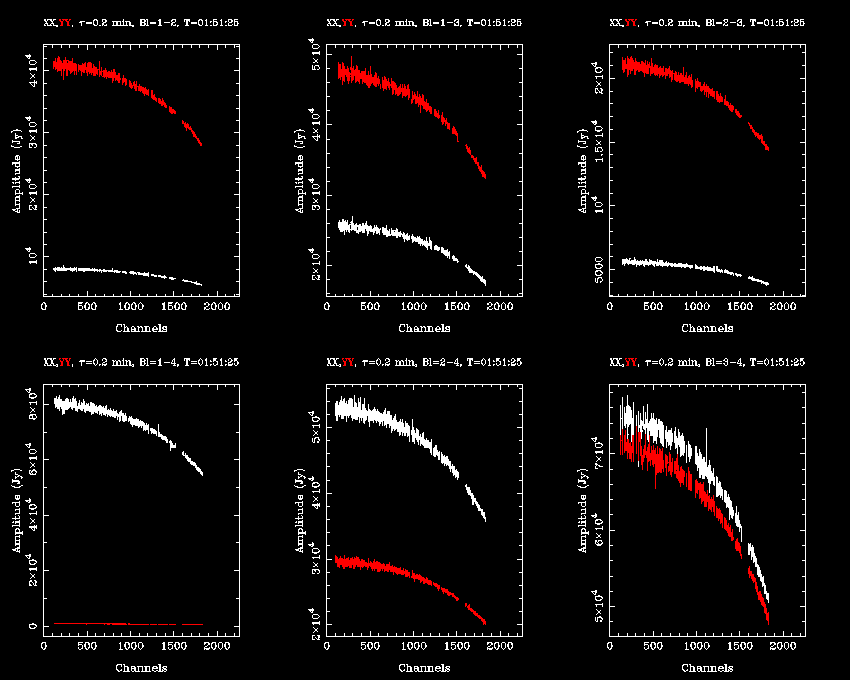

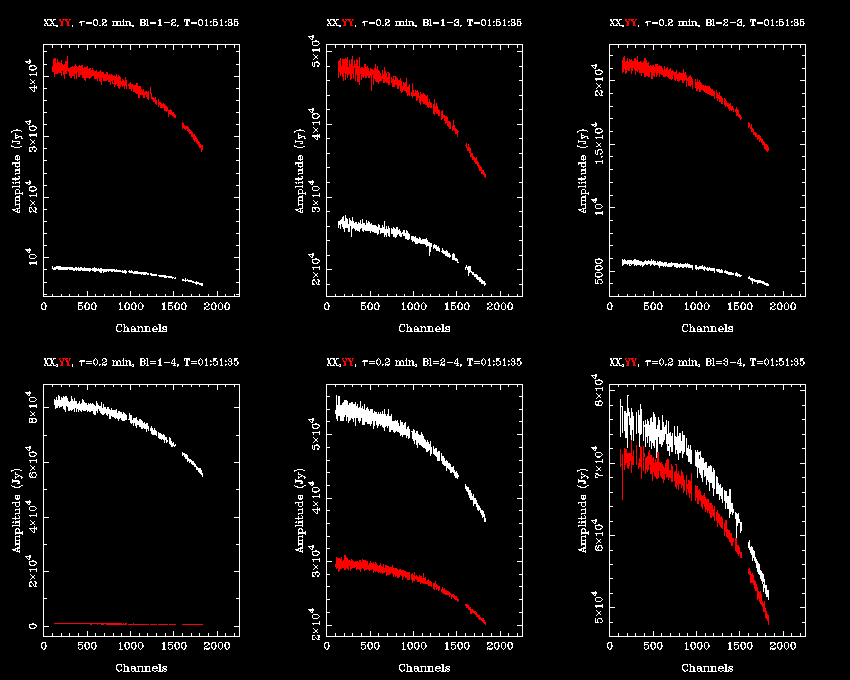

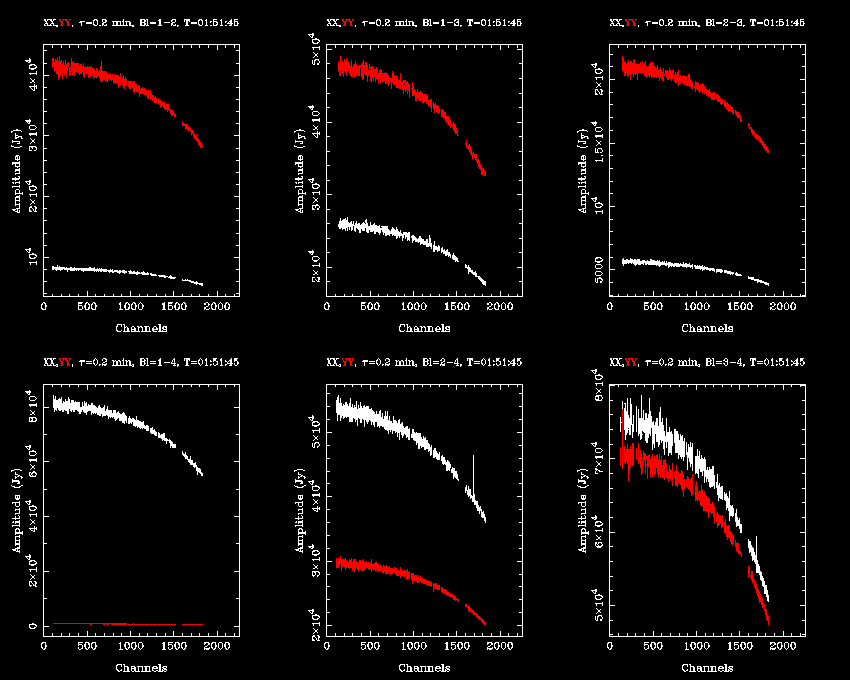

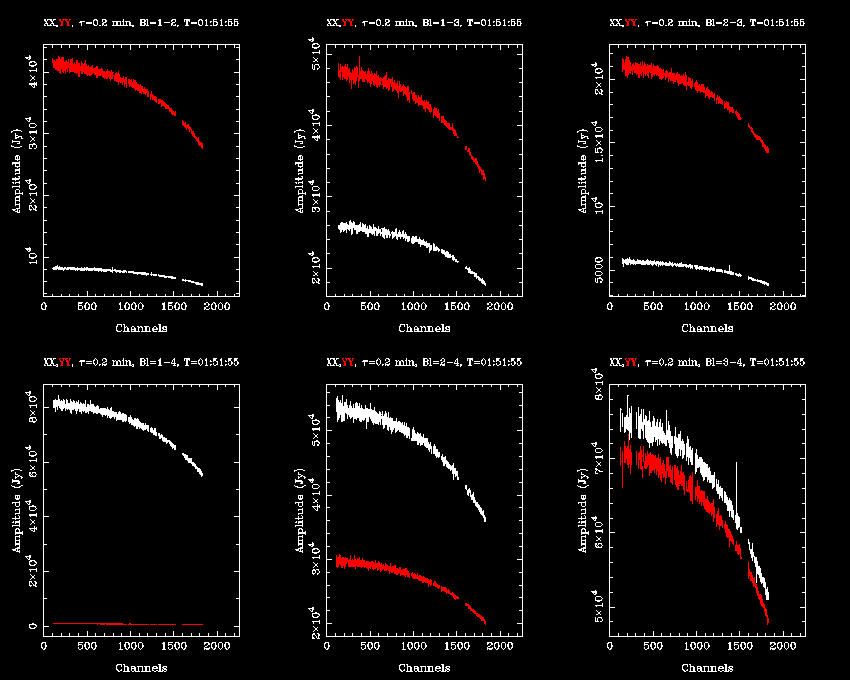

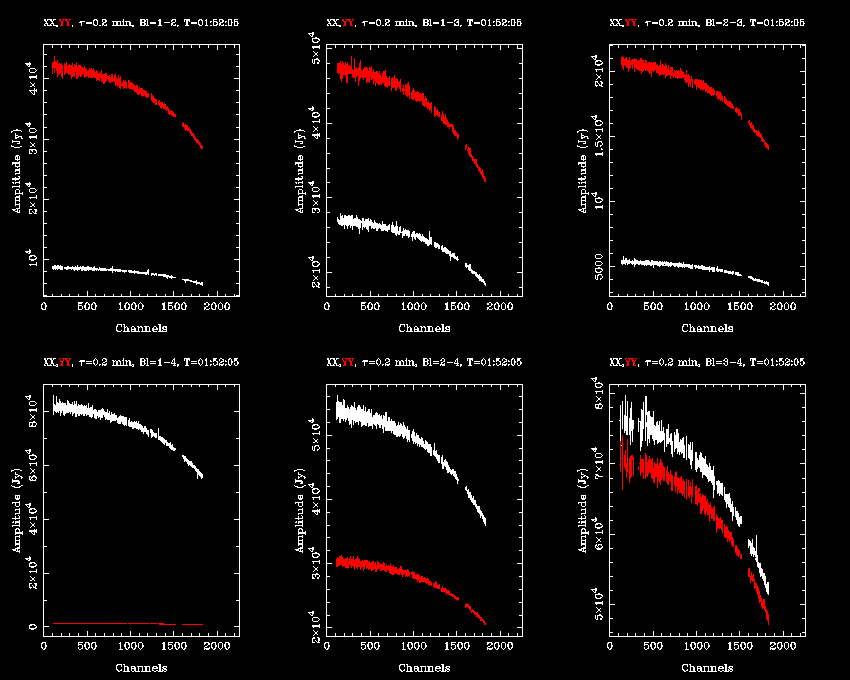

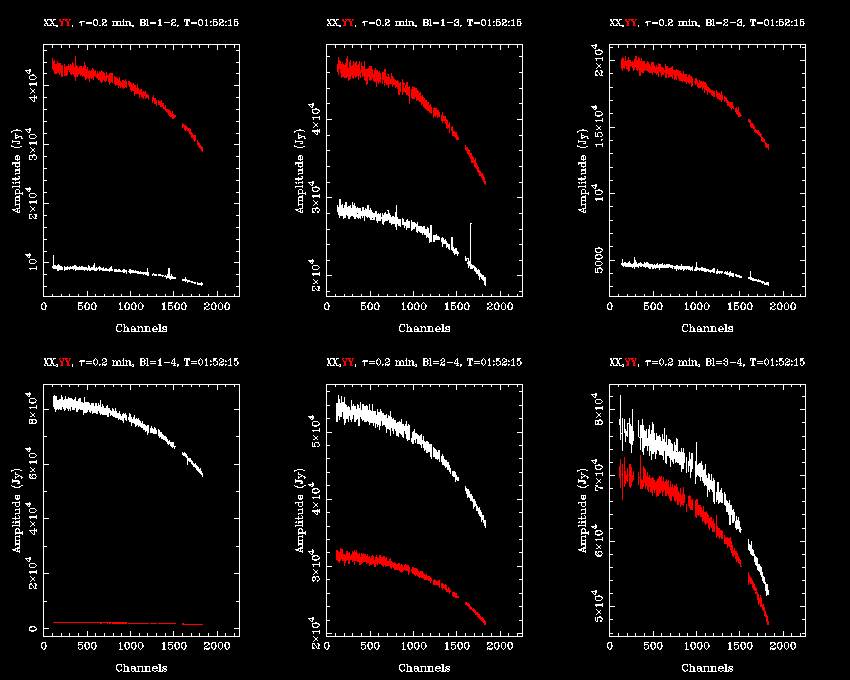

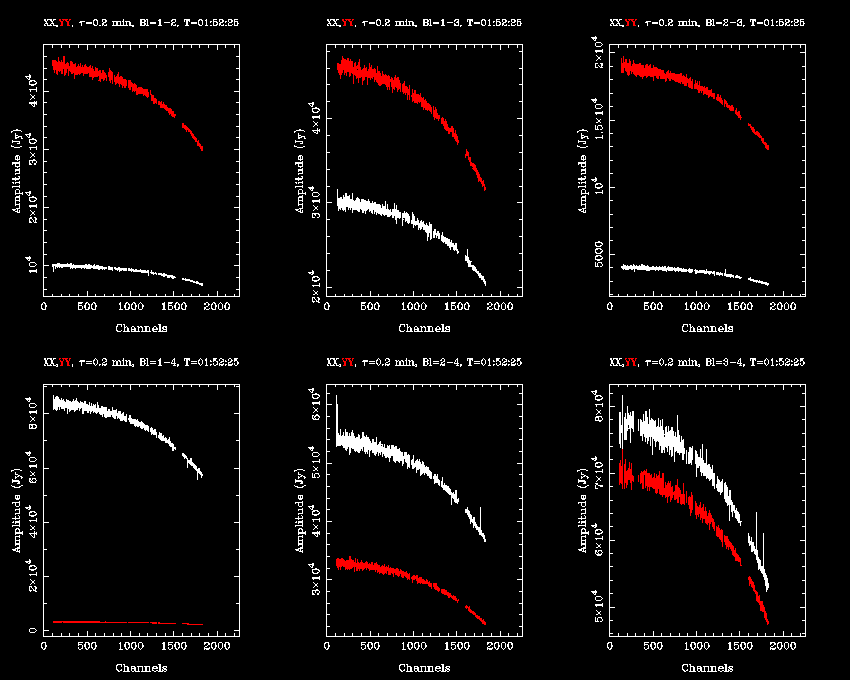

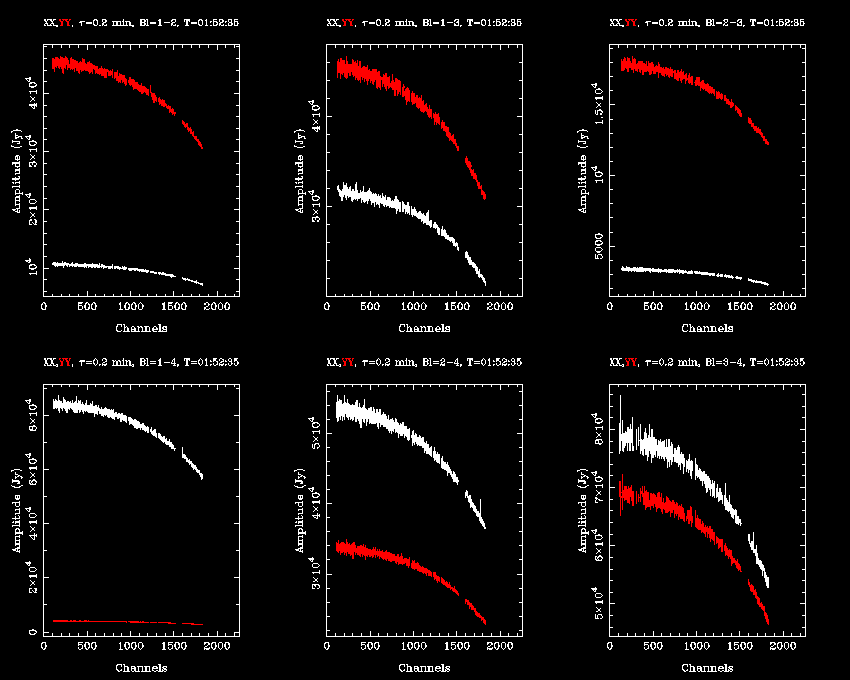

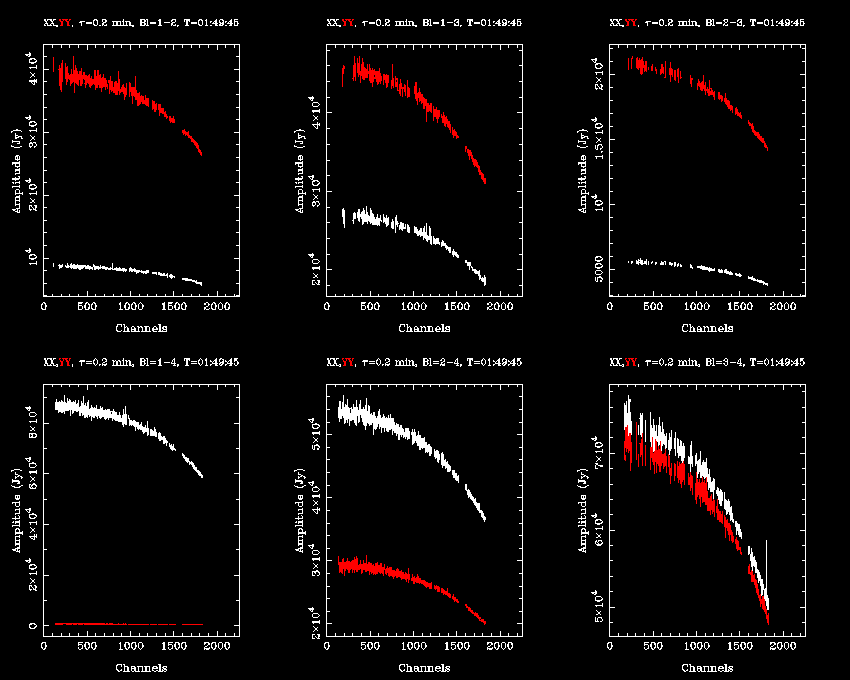

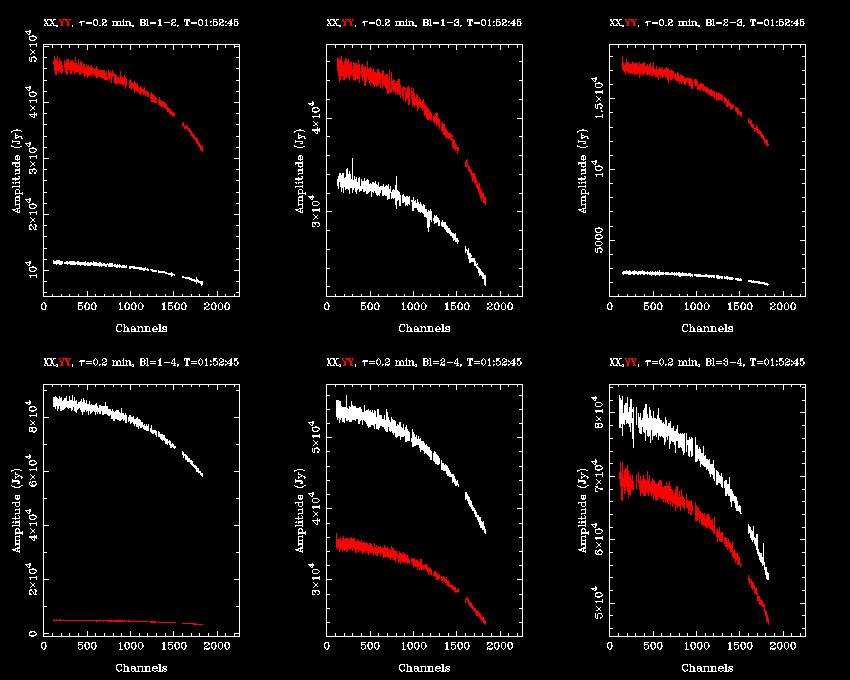

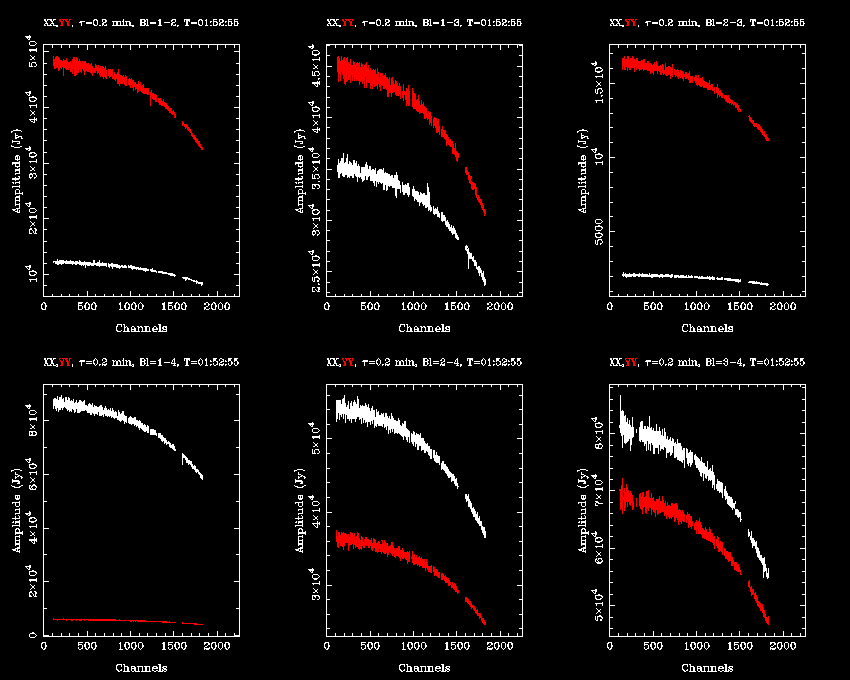

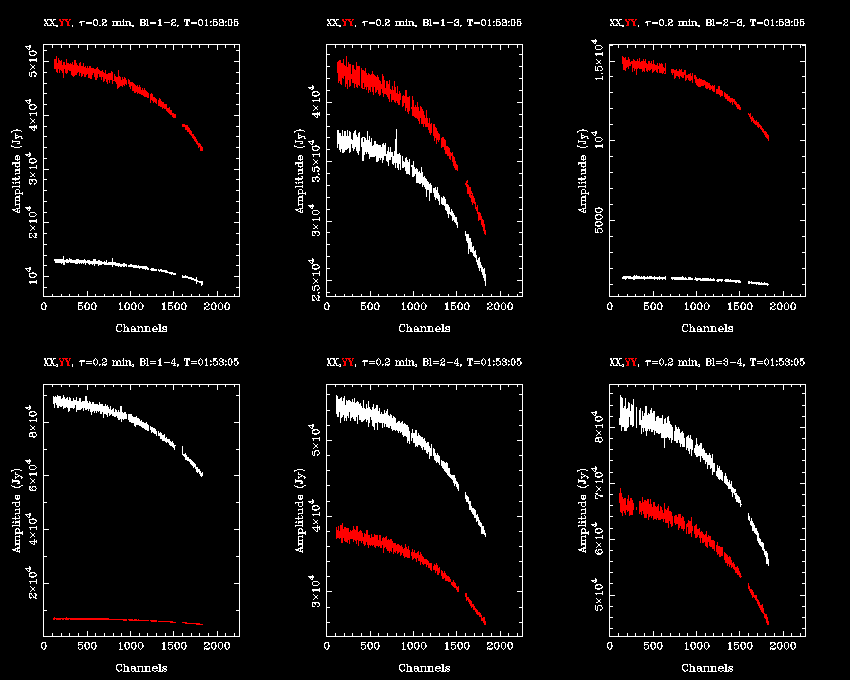

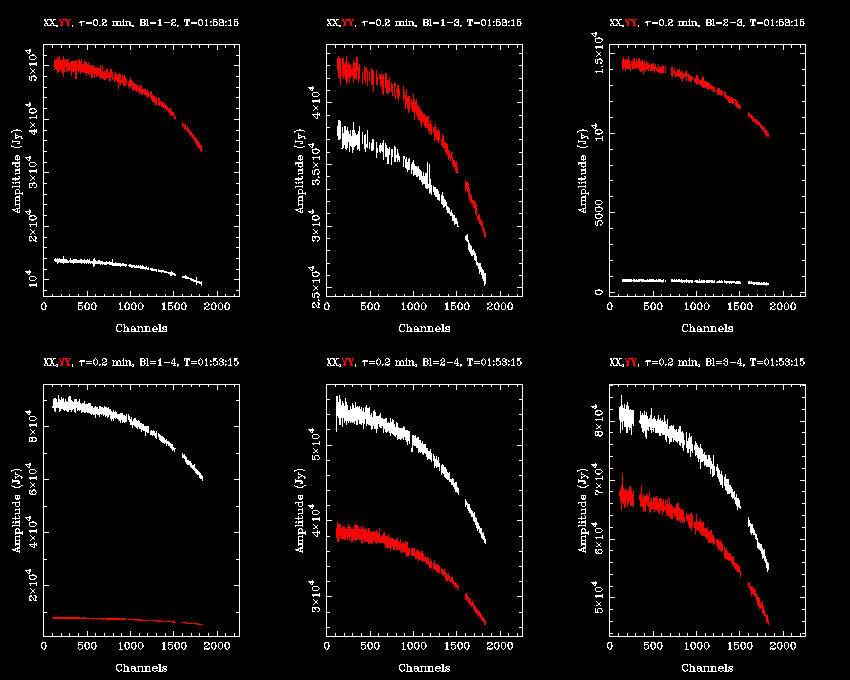

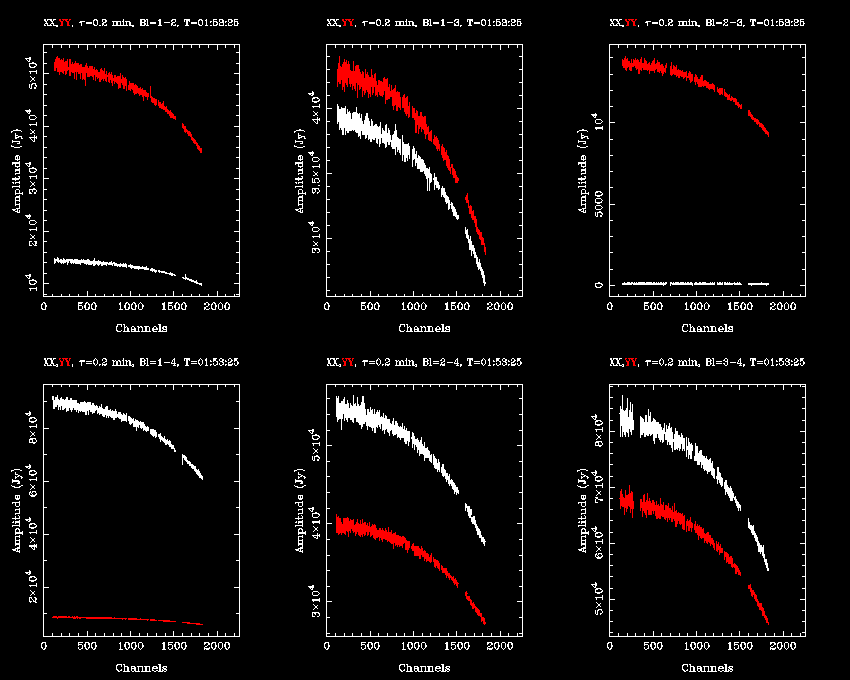

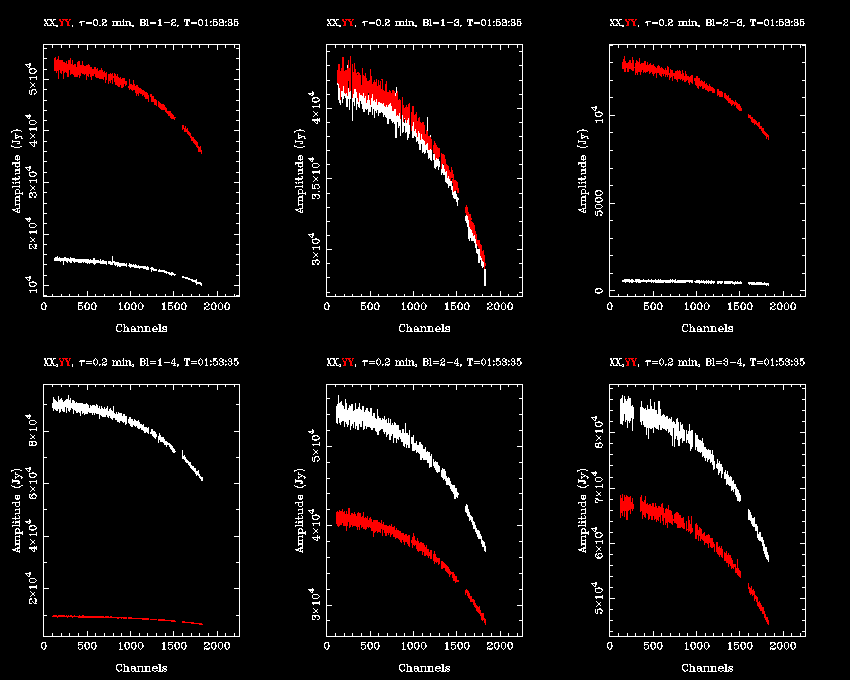

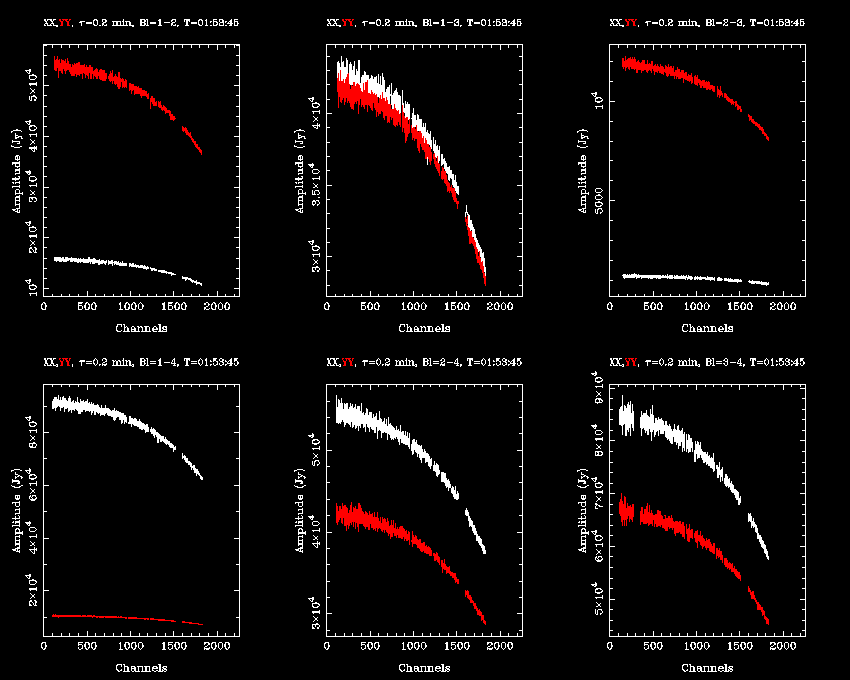

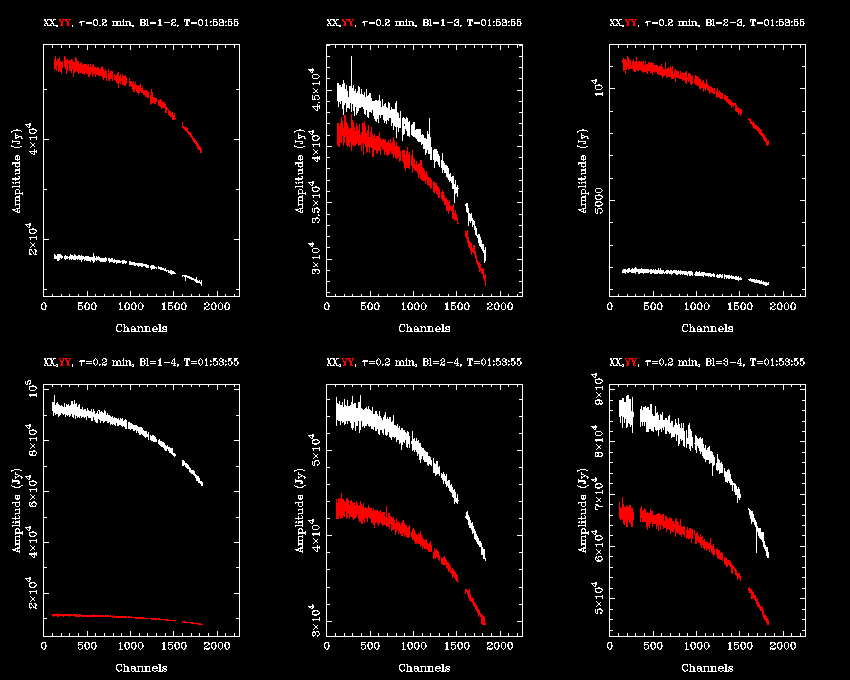

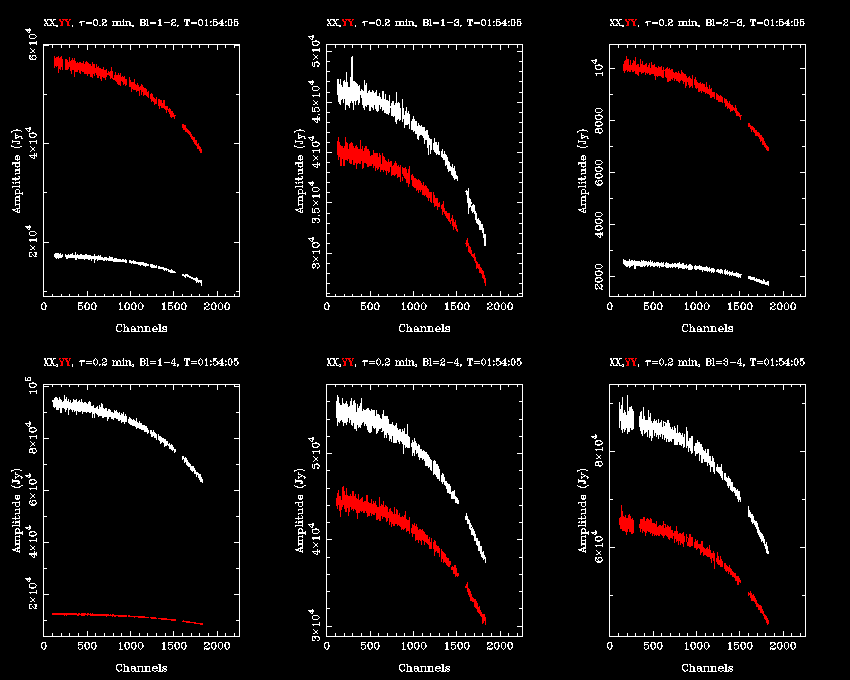

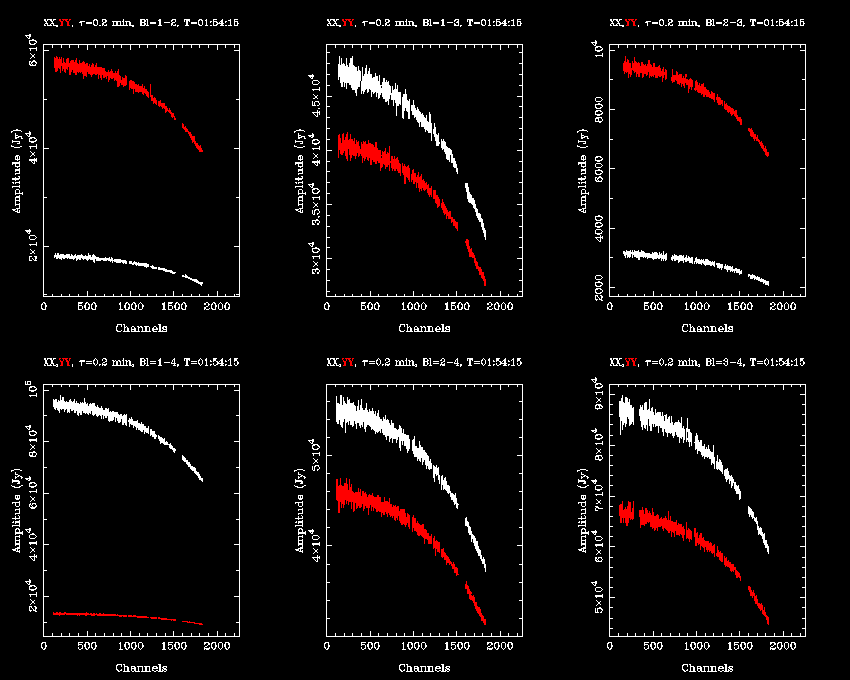

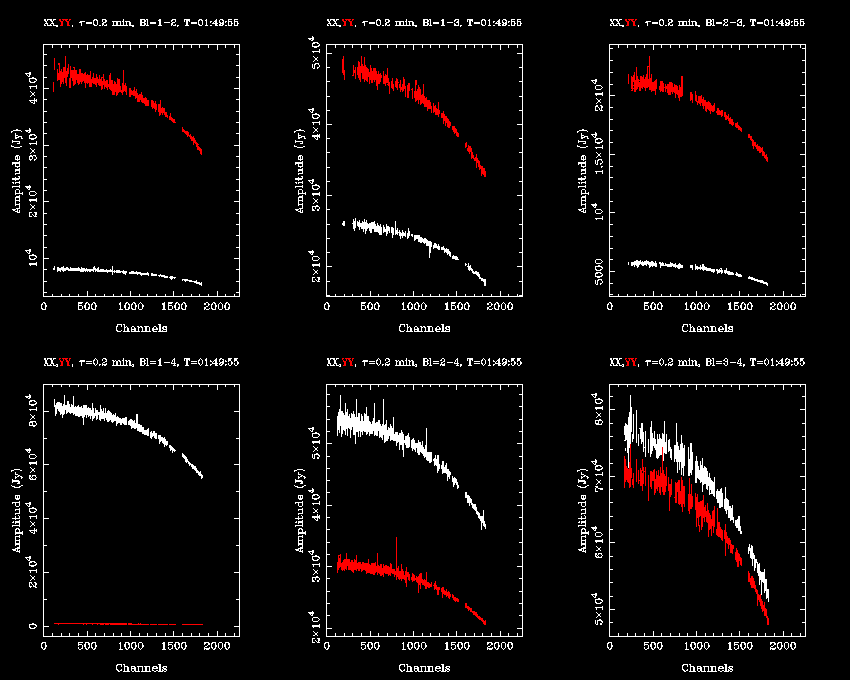

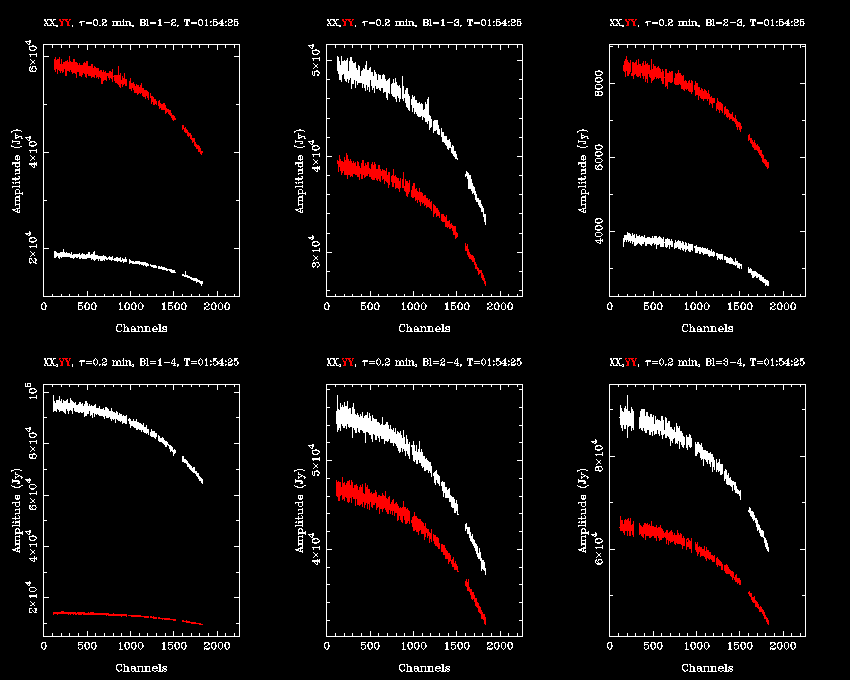

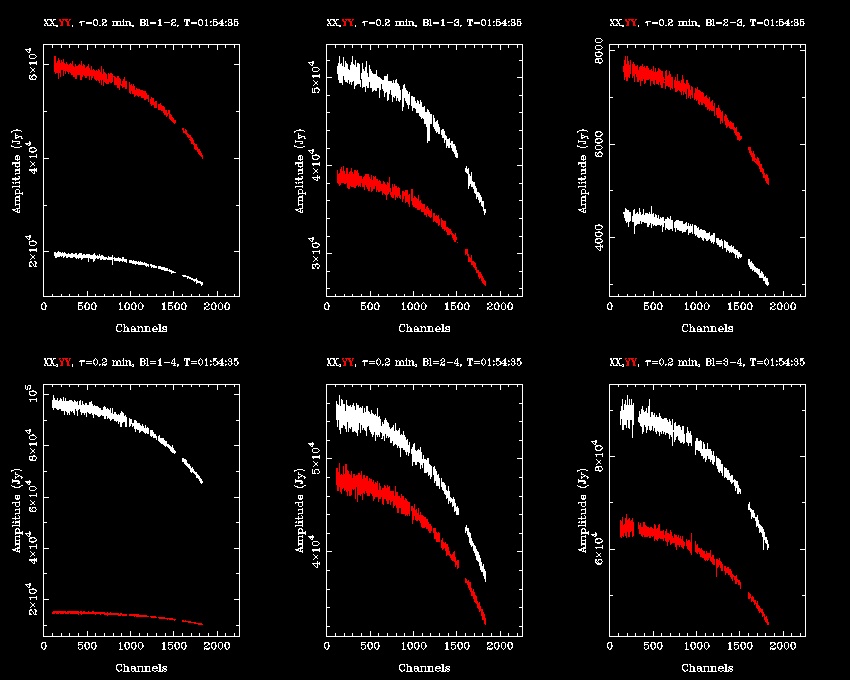

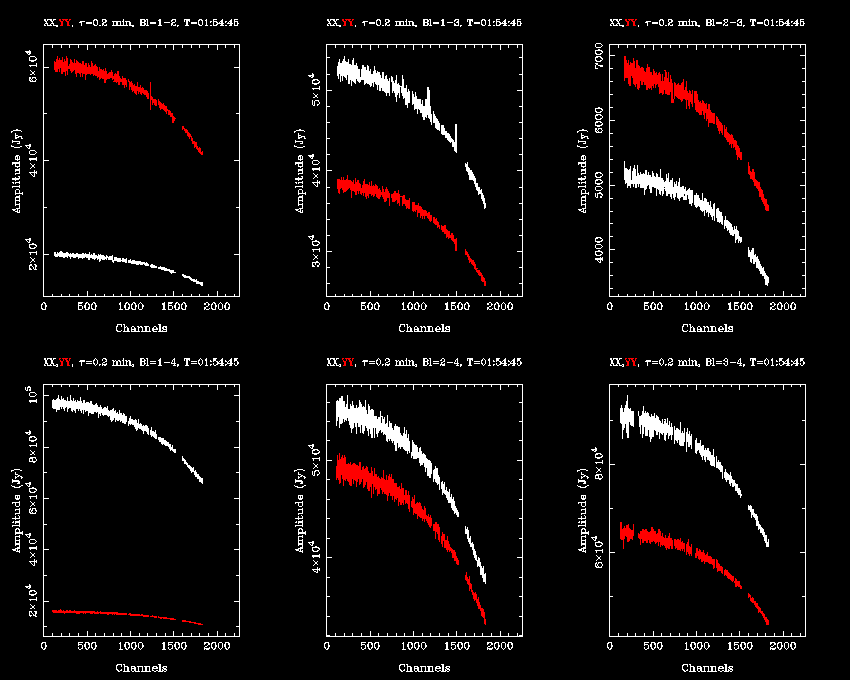

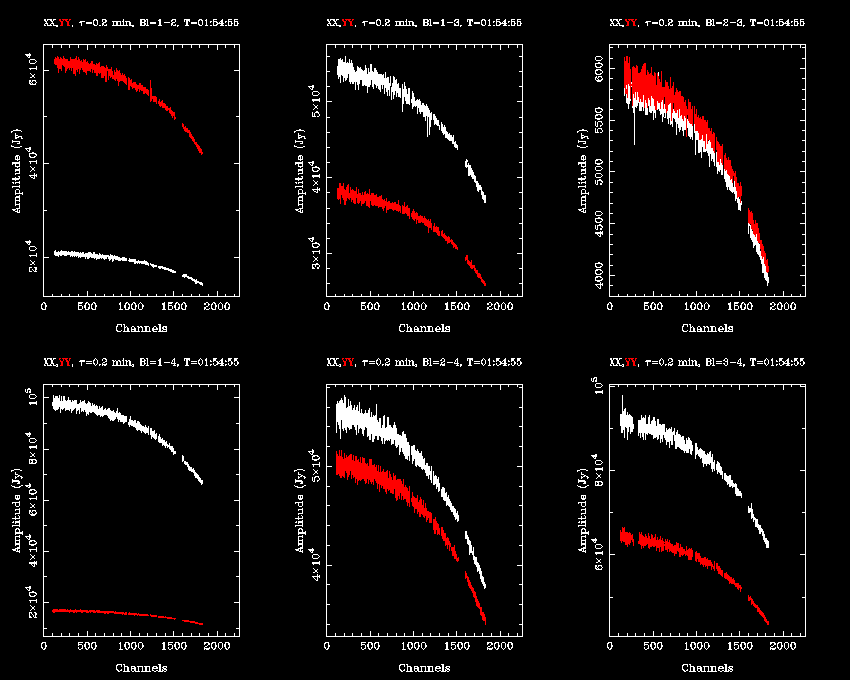

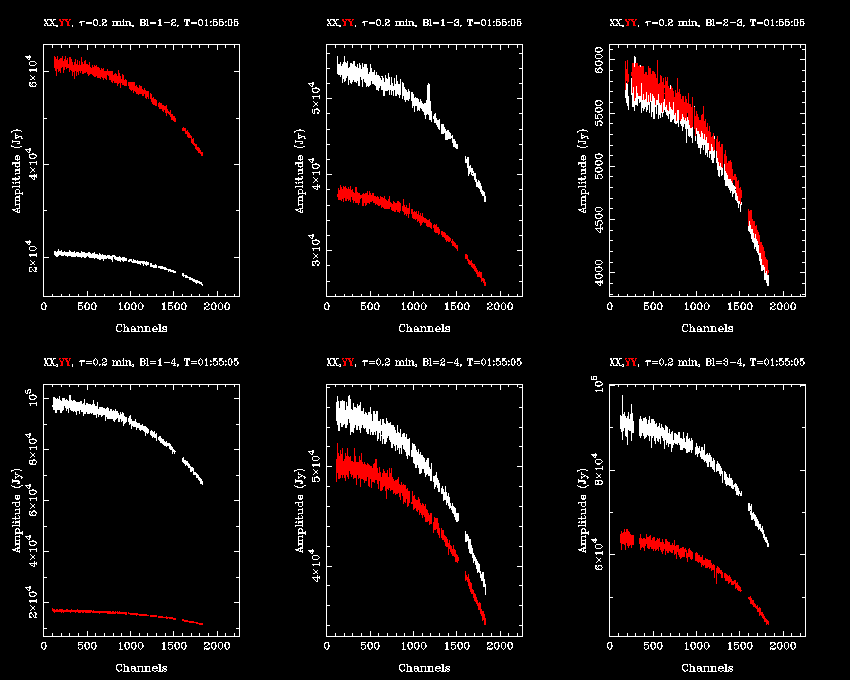

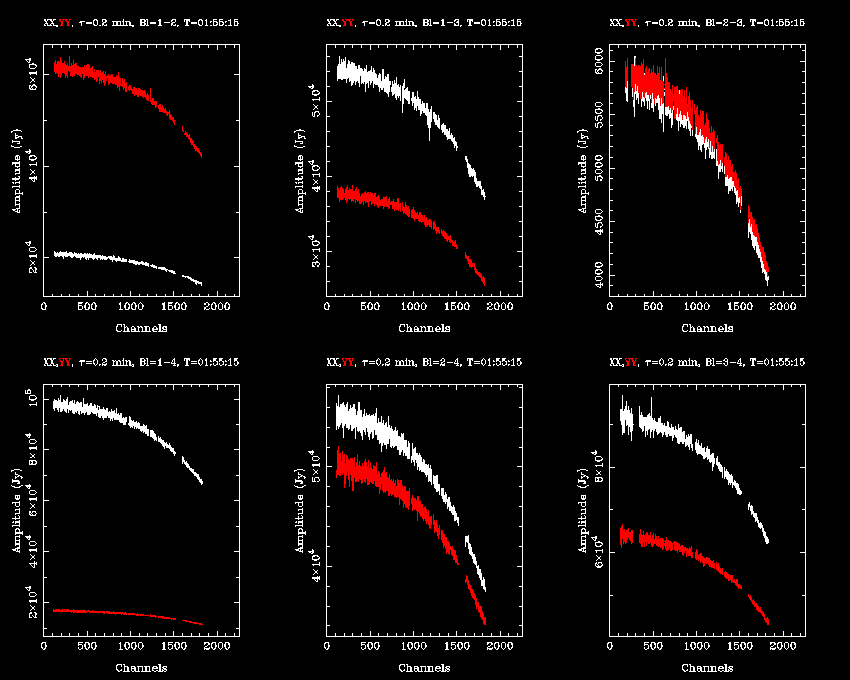

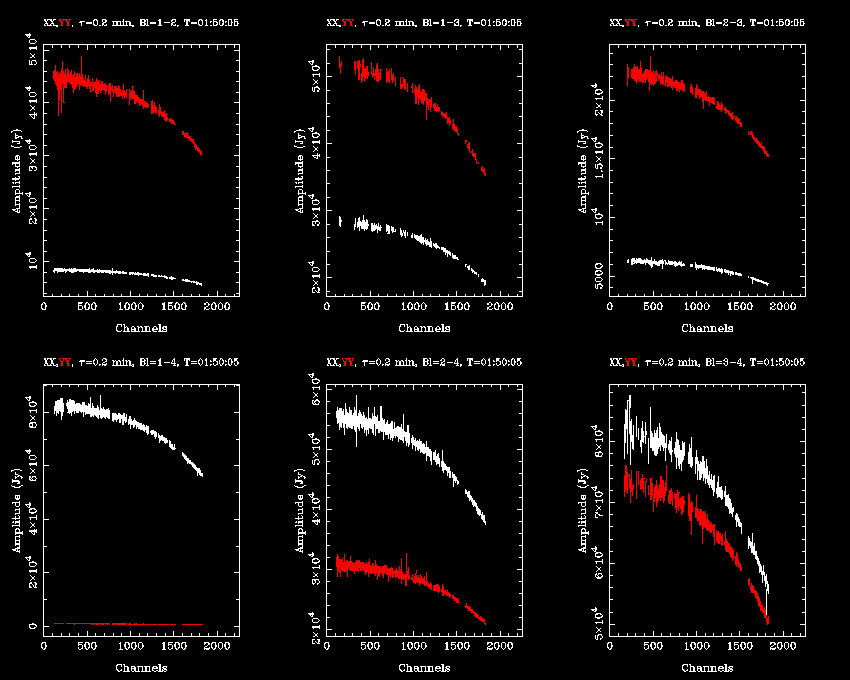

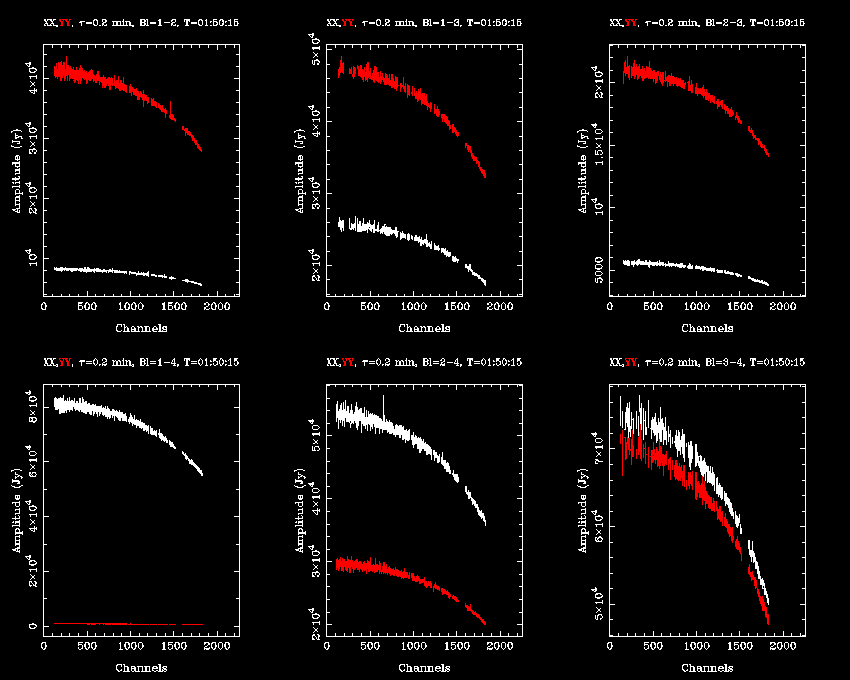

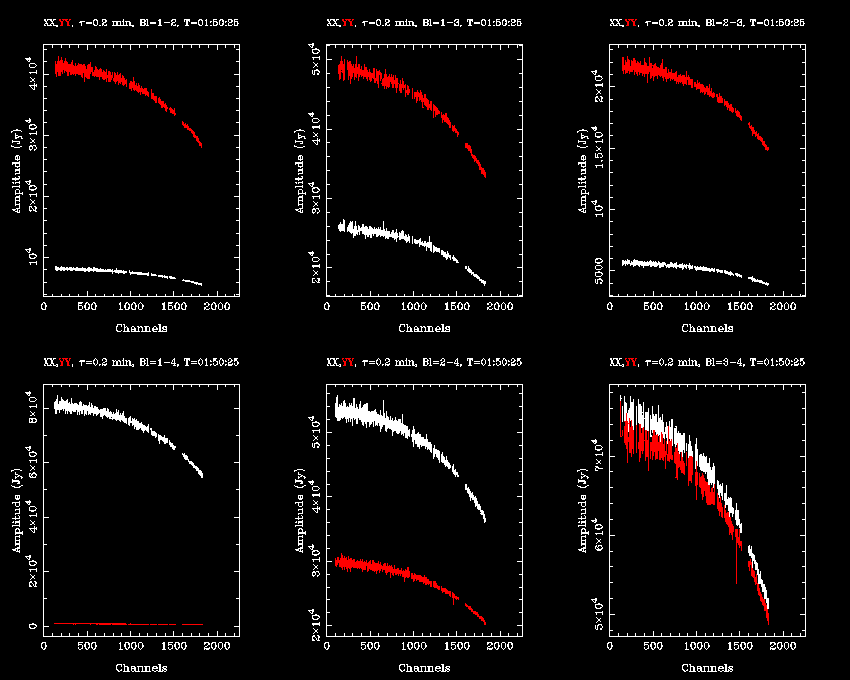

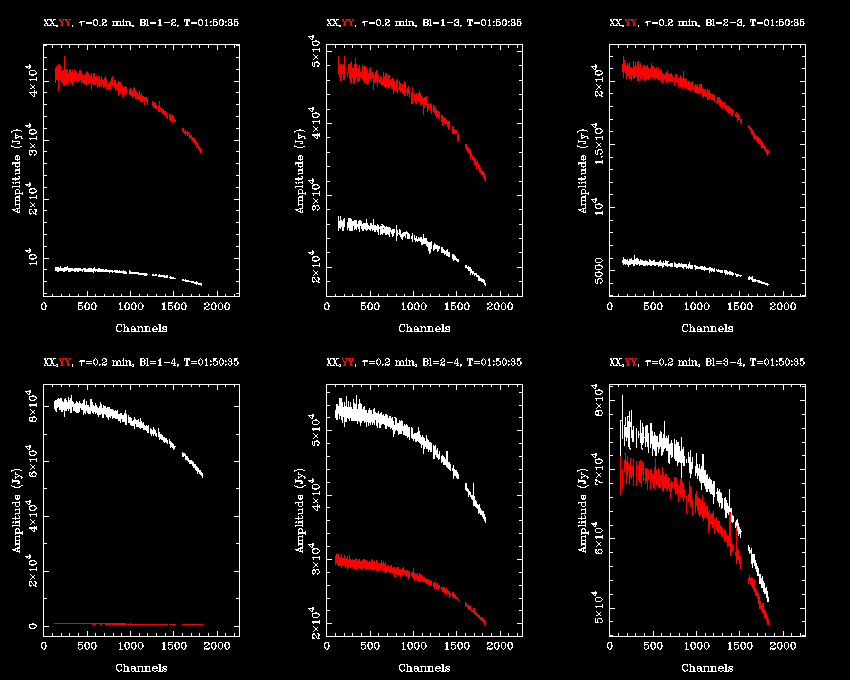

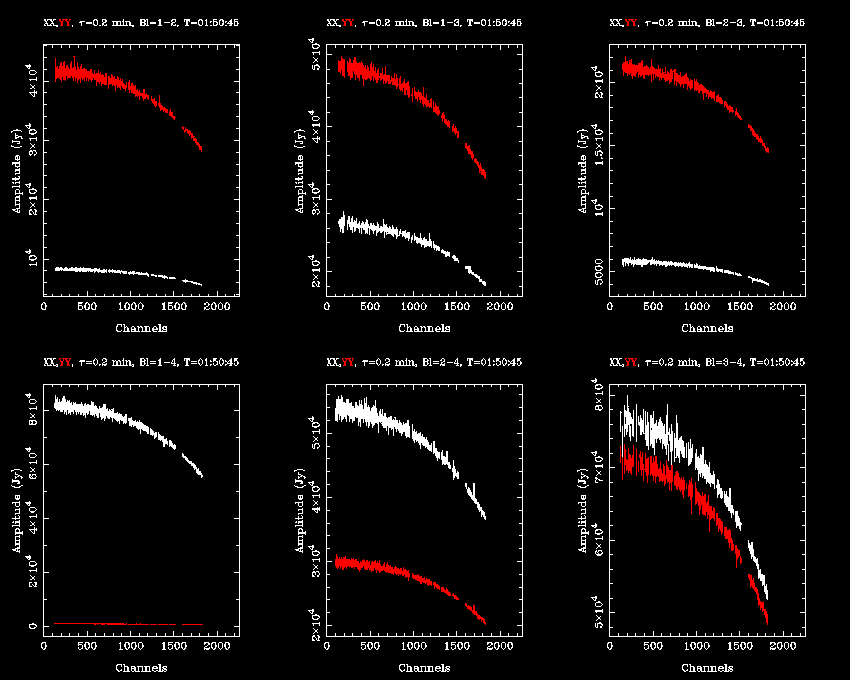

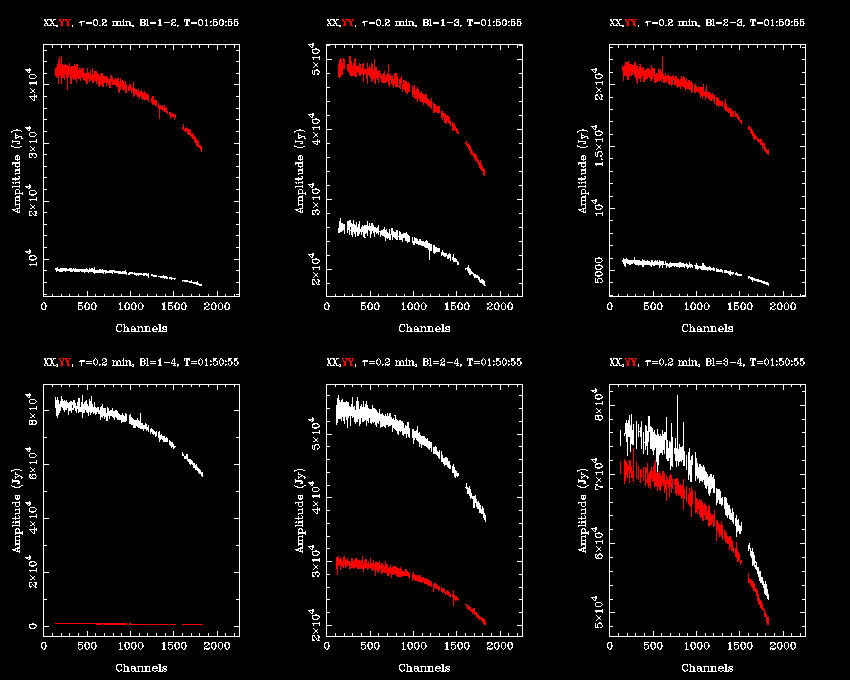

In [8]:
# if you want to see what it looks like after blflag

# uvspec parameters
if display_results:
    print('#'*10+"Post blflag source"+'#'*10)
vis = source
stokes = "xx,yy"
axis = "chan,amp"
#device="/xs"
device="{0}_postblflag.png/png".format(vis)
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

if display_results:
    print(mir_output.decode("utf-8", errors="replace"))


move_and_display_pngs(device,dir_name,log=None, display_results=display_results)



##########Check if source is resolved##########
uvplt: Revision 1.18, 2014/05/21 04:34:59 UTC

Will plot unflagged data

Applying bandpass corrections to 1934-638.2100
Applying freq. dependent gain corrections to 1934-638.2100
Applying freq. dependent leakage correction to 1934-638.2100


File # 1  = 1934-638.2100
1934-638.2100 3.1240 GHz
Read 420 visibilities from all files

Plot 420 points


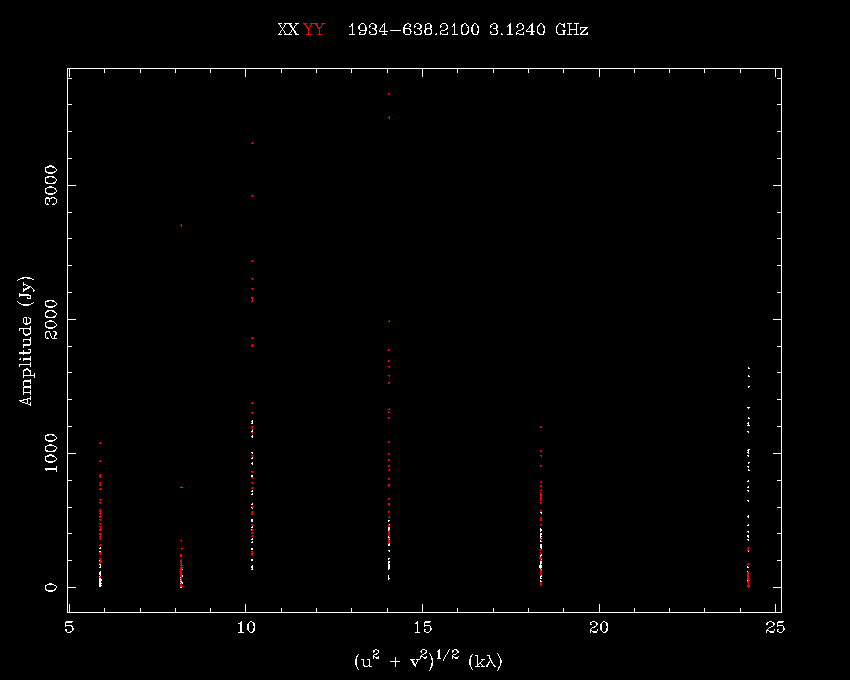

In [9]:
# done RFI flagging the source
# now apply the calibration solutions


# look at the amplitude vs time
if display_results:
    print('#'*10+"Check if source is resolved"+'#'*10)
# uvplt
vis = source
stokes = "xx,yy"
axis = "uvdistance,amplitude"
options="nobase"
device="{0}_uvdistamp.png/png".format(vis)

mir_output = miriad.uvplt(vis=vis,stokes=stokes,axis=axis,
                          options=options,device=device)
if display_results:
    print(mir_output.decode("utf-8"))

move_and_display_pngs(device,dir_name,log=None, display_results=display_results)





## Gain calibration

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'gpcal':  Number of flagged visibilities: 20
  warnings.warn(msg)


gpcal: Revision 1.22, 2016/05/01 22:31:05 UTC

Applying bandpass corrections to 1934-638.2100
Number of antennae: 6
Using leakage parameters from input as initial guess
Reading the data ...
Number of solution intervals: 35
Total visibilities read: 525
Number visibilities accepted: 505
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 12.2783,  0.0000,  0.0000,  0.0000 at   2.1794 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 10.1070,  0.0000,  0.0000,  0.0000 at   2.8092 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 11.5561,  0.0000,  0.0000,  0.0000 at   2.3771 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 13.4601,  0.0000,  0.0000,  0.0000 at   1.8633 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 14.9064,  0.0000,  0.0000,  0.0000 at   1.4006 GHz.
Iter= 1, Amplit/Phase Solution Error:   0.148
Iter= 1, Polarisation Solution Error:   0.000
Iter= 1, Overall Solution Error:        0.671
Iter= 2, Amplit/

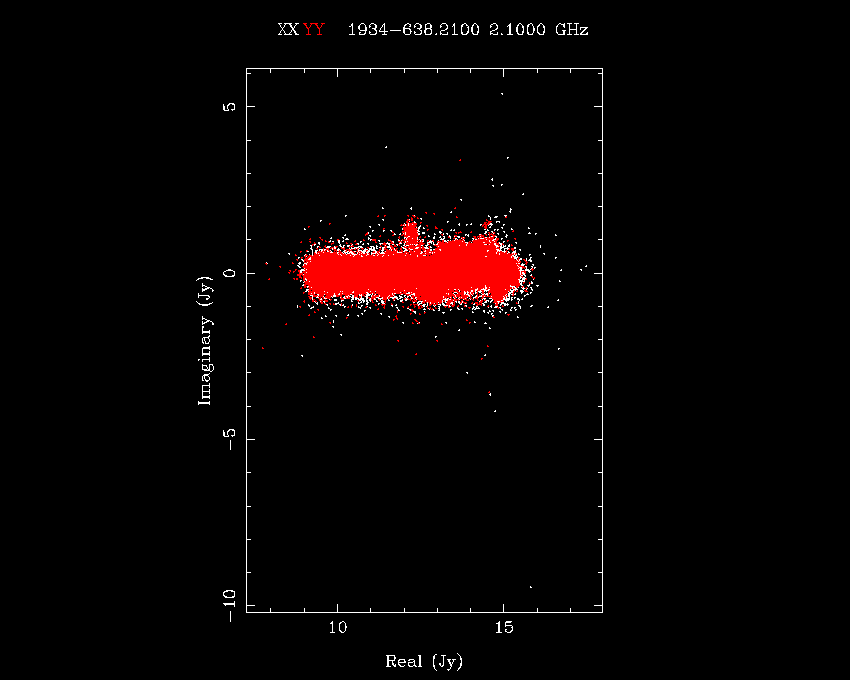

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC                         3-�=
Applying bandpass corrections to 1934-638.2100
Applying freq. dependent gain corrections to 1934-638.2100
Applying freq. dependent leakage correction to 1934-638.2100
Source: 1934-638
Stokes I
Vector Average Amplitude:   1.219E+01         Phase:   4.180E-03
             Uncertainty:   2.334E-01
Scalar Average Amplitude:   1.219E+01   Uncertainty:   2.136E-01
--------------------------------------------------------------------------------


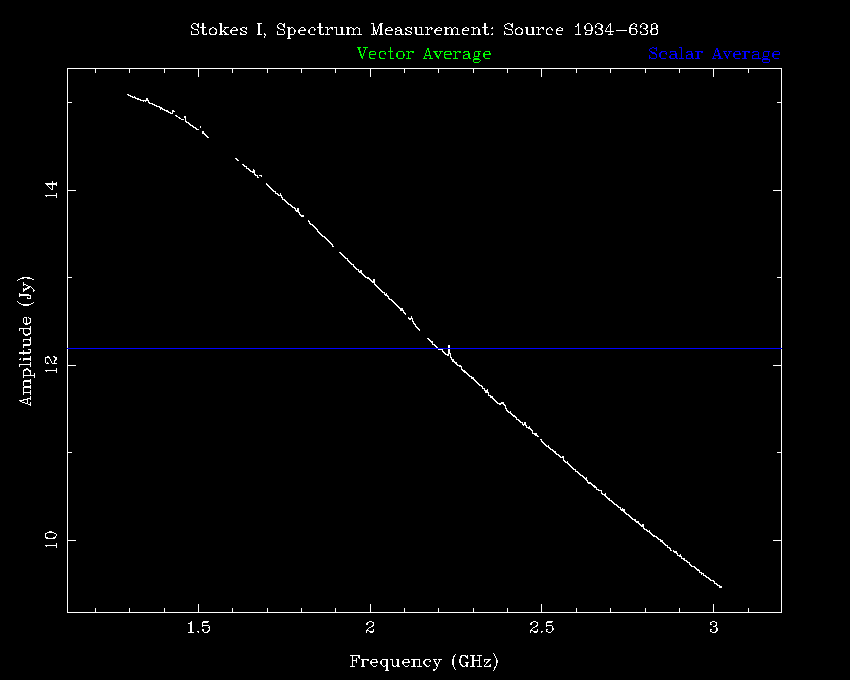

In [10]:

# gpcal parameters
vis =  source
interval="0.1"
nfbin="4"
options="xyvary"
refant=refant
mir_output = miriad.gpcal(vis=vis,interval=interval,nfbin=nfbin,
                           options=options,refant=refant)



if display_results:
    print(mir_output.decode("utf-8"))


# uvplt
vis = source
stokes = "xx,yy"
axis = "real,imag"
options="nofqav,nobase,equal"
device="{0}_realimag.png/png".format(vis)

mir_output = miriad.uvplt(vis=vis,stokes=stokes,axis=axis,
                          options=options,device=device)
if display_results:
    print(mir_output.decode("utf-8"))

move_and_display_pngs(device,dir_name,log=None, display_results=display_results)


if not (source == bandflux_cal):
    # reestablish flux
    # gpboot parameters
    vis = source
    cal = bandflux_cal

    mir_output = miriad.gpboot(vis=vis,cal=cal)
    

    if display_results:
        print(mir_output.decode("utf-8"))

# uvfmeas!
vis= source
stokes ='i'
line = 'channel,2048,1,1,1'
log = 'uvfmeaslog{0}MHz_{1}'.format(line.split(',')[-2],source)
device="{0}_postcaluvmeas.png/png".format(source)
feval="2.1"

mir_output = miriad.uvfmeas(vis=vis,stokes=stokes,device=device,line=line,
                            feval=feval,log=log)


# put it in notebook dir
im_to_save = "{0}_postcaluvmeas.png".format(source)
shutil.copy(im_to_save, image_dir)

if display_results:
    print(mir_output.decode("utf-8", errors='replace'))

move_and_display_pngs(device,dir_name,log, display_results=display_results)


flux_uvfmeas = grabflux_uvfmeas(mir_output) 
for i in (phasecal_df[phasecal_df["name"] == phasecal_df.loc[h]["name"]].index.values):    
    phasecal_df.set_value(i, 'flux', flux_uvfmeas)  
phasecal_df.to_csv(df_path)



In [15]:
phasecal_df

,flux,name,percent_flagged,phasecal
0,12.19,1934-638.2100,46.2,1934-638.2100
1,,pks1934-638.2100,,
2,,pks1740-649.2100,,
3,,pmnj1726-6427.2100,,
4,,pks1814-637.2100,,
5,,mwacsj2153.5.2100,,
6,,pks2149-28.2100,,
7,,pks2135-209.2100,,
8,,mwacsj2157.5.2100,,
9,,pks2254-367.2100,,


# Imaging

In [11]:
#################### IMAGING #####################

if source != bandflux_cal:
    # average/smoothe antenna gains
    # gpaver parameters
    vis = source
    interval = "2"

    mir_output = miriad.gpaver(vis=vis,interval=interval)
    if display_results:
        print(mir_output.decode("utf-8"))


    # uvaver parameters
    vis = source
    temp = vis.split('.')
    uvav_source = temp[0]+'.uvaver.'+temp[1]
    out= uvav_source 

    # remove it if it already exists
    # remove if it already exists
    rm_outfile(out)

    mir_output = miriad.uvaver(vis=vis,out=out)
    if display_results:
        print(mir_output.decode("utf-8"))

    # split into smaller frequency chunks

    # uvsplit parameters
    vis = uvav_source 
    maxwidth ="0.512"

    # how do I predict these file names? 
    splitname = source.split('.2100')[0]
    endings = ['.2868','.2356','.1844','.1332']
    # remove if it already exists
    rm_outfile([splitname+end for end in endings])

    mir_output = miriad.uvsplit(vis=vis,maxwidth=maxwidth)
    if display_results:
        print(mir_output.decode("utf-8"))

    freq_chunks = names_uvsplit(mir_output)


    

## Self-Cal loop

In [12]:
# Imaging
if source != bandflux_cal:
    # select the first freq chunk
    freq_chunk = freq_chunks[0]

    # do I need to image each frequency chunk? 
    #for freq_chunk in freq_chunks:
    #    print(freq_chunk)

    # loop twice so you can use self-cal
    loop = [0,1]

    for l in loop:

        if l == 1:
            ##########################################################################
            # self calibration
            if display_results:
                print('#'*10+"Selfcal"+"#"*10)
            # selfcal parameters
            vis = freq_chunk
            model=vis+".imodel"
            clip= "0.013"
            interval=1
            options="phase,mfs"

            try: 
                mir_output = miriad.selfcal(vis=vis,model=model,clip=clip,interval=interval,
                                           options=options)
                if display_results:
                    print(mir_output.decode("utf-8"))
            except:
                print("couldn't self-cal")
            ###########################################################################


        # invert parameters
        vis = freq_chunk
        map_ = freq_chunk+".imap"
        beam = freq_chunk+".ibeam"
        robust = "0.5"
        stokes = "i"
        options="mfs,double"

        # delete the files if they already exist
        rm_outfile(map_)
        rm_outfile(beam)

        mir_output = miriad.invert(vis=vis,map=map_,beam=beam,robust=robust,
                                   stokes=stokes, options=options)
        if display_results:
            print(mir_output.decode("utf-8"))


        invert_rms = grabrms_invert(mir_output)

        # look at the dirty map

    # dirty map
        # cgdisp parameters
        in_ = freq_chunk+".imap"
        beam = freq_chunk+".ibeam"
        type_="p"
        device="{0}_dirtymap.png/png".format(in_)
        laptyp = "/hms,dms"
        options="wedge"

        mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                                   options=options)
        if display_results:
            print(mir_output.decode("utf-8"))
            print('#'*10+"Dirty Map after inversion"+"#"*10)
        move_and_display_pngs(device,dir_name,log=None,display_results=display_results)


    # Dirty beam
        # cgdisp parameters
        in_= freq_chunk+".ibeam"
        type_="p"
        device="{0}_dirtybeam.png/png".format(in_)
        laptyp = "/hms,dms"
        options="wedge"
        range_="0,0,log"

        mir_output = miriad.cgdisp(in_=in_,type=type_,device=device,laptyp=laptyp,
                                   options=options,range=range_)
        if display_results:
            print(mir_output.decode("utf-8"))
            print('#'*10+"beam"+"#"*10)
        move_and_display_pngs(device,dir_name,log=None,display_results=display_results)



        # clean parameters
        map_ = freq_chunk+".imap"
        beam = freq_chunk+".ibeam"
        out = freq_chunk+".imodel"
        options="negstop,positive"
        cutoff=invert_rms
        niters="1000"

        # remove model if it already exists
        rm_outfile(out)

        mir_output = miriad.clean(map=map_,beam=beam,out=out,cutoff=cutoff,niters=niters,
                                   options=options)
        if display_results:
            print(mir_output.decode("utf-8"))


        rmscheck_clean(mir_output, display_results) 


        # restore the image

        # restor parameters
        model = freq_chunk+".imodel"
        beam = freq_chunk+".ibeam"
        map_ = freq_chunk+".imap"
        out = freq_chunk+".irestor"
        mode=""#"residual"

        # remove restored image if it already exists
        rm_outfile(out)

        mir_output = miriad.restor(model=model,map=map_,beam=beam,out=out, mode=mode)
        if display_results:
            print(mir_output.decode("utf-8"))

        



## Cleaned Image

In [13]:
# look at the cleaned image

if source != bandflux_cal:

    # cgdisp parameters
    in_ = freq_chunk+".irestor"
    beam = freq_chunk+".ibeam"
    type_="p"
    device="{0}_cleanedimage.png/png".format(in_)
    laptyp = "/hms,dms"
    options="wedge"
    range_="0,0,log"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                               options=options,range=range_)

    # put it in notebook dir
    im_to_save = '{0}_cleanedimage.png'.format(in_)
    shutil.copy(im_to_save, image_dir)

    if display_results:
        print(mir_output.decode("utf-8"))
        print('#'*10+"Cleaned image"+"#"*10)
    move_and_display_pngs(device,dir_name,log=None, display_results=display_results)




    # measure the flux density of the source

    # imfit parameters
    in_ = freq_chunk+".irestor"
    region="quarter"
    object_="point"
    spar="1,0,0"
    out=freq_chunk+".iresidual"
    options="residual"

    # remove residual image if it already exists
    rm_outfile(out)

    mir_output = miriad.imfit(in_=in_,region=region,object=object_,spar=spar, out=out,
                               options=options)
    if display_results:
            print(mir_output.decode("utf-8"))

    peakflux= grabpeak_imfit(mir_output)



    # look at the cleaned image after the central source is subtracted by imfit



    # cgdisp parameters
    in_ = freq_chunk+".iresidual"
    beam = freq_chunk+".ibeam"
    type_="p"
    device="{0}_cleanedsubtracted.png/png".format(in_)
    laptyp = "/hms,dms"
    options="wedge"
    range_="0,0,log"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                               options=options,range=range_)
    if display_results:
        print(mir_output.decode("utf-8"))
        print('#'*10+"Cleaned image - central source"+"#"*10)
    move_and_display_pngs(device,dir_name,log=None, display_results=display_results)


## dynamic range estimation

In [14]:
if source != bandflux_cal:
# estimate the dynamic range of the image

    # imhist parameters
    in_ = freq_chunk+".iresidual"
    region="quarter"
    device="{0}_imhist.png/png".format(in_)
    options="nbin,100"

    mir_output = miriad.imhist(in_=in_,region=region, device=device,
                               options=options)
    if display_results:
        print(mir_output.decode("utf-8"))
        print('#'*10+"imhist"+"#"*10)
    move_and_display_pngs(device,dir_name,log=None, display_results=display_results)



    rms_imhist= grabrms_imhist(mir_output)

    dynamic_range = float(peakflux[0])/float(rms_imhist)

    if display_results:
        print('dynamic range: {0}'.format(round(dynamic_range)))

